In [236]:
# 분석 라이브러리 
import pandas as pd
import numpy as np
# 시각화 라이브러리 
import matplotlib.pyplot as plt

import seaborn as sns
from datetime import datetime

import re


In [237]:
# promo_code 결측치 많음 


# 필요 함수 

# 데이터 타입 변경 
def columns_datetype_change(data,columns, datetype):
    data[columns] = pd.to_datetime(data[columns], errors='coerce') #convert to datetime64[ns]
    # want to format the datetime columns
    if datetype == 'datetime64':
        data[columns] = data[columns].dt.strftime('%Y-%m-%d %H:%M')

#결측치 확인
def null_check(data):
    return (data.isnull().sum() / data.shape[0]) * 100


# 정수형, 실수형 제외한 나머지 데이터타입의 유니크값 
def columns_unique(data):
    for c in data.columns:
        if data[c].dtype not in ['int64', 'float64']:
            print(f'-----------{c}----------')
            print(data[f'{c}'].unique())

def memory_small(data):
    for c in data.columns:
        if data[c].dtype == 'int64':
            data[c]=data[c].astype('int32')
        elif data[c].dtype == 'object' and data[c].nunique()<10:
            data[c] = data[c].astype('category')

In [238]:
# transaction_new 구매시도 또는 확정한 주문 데이터 1254585*16 / 고객의 구매 정보 / 주문일자, 고객id, 예약id, 세션id, 프로모션 코드, 결제성공여부, 배송비, 배송제한날짜, 결제금액
import pandas as pd

df_transaction = pd.read_csv('transaction_new.csv', on_bad_lines='skip')

df_transaction.head()

created_at  customer_id  \
0  2018-07-29T15:22:01.458193Z         5868   
1  2018-07-30T12:40:22.365620Z         4774   
2  2018-09-15T11:51:17.365620Z         4774   
3  2018-11-01T11:23:48.365620Z         4774   
4  2018-12-18T11:20:30.365620Z         4774   

                             booking_id                            session_id  \
0  186e2bee-0637-4710-8981-50c2d737bc42  3abaa6ce-e320-4e51-9469-d9f3fa328e86   
1  caadb57b-e808-4f94-9e96-8a7d4c9898db  2ee5ead1-f13e-4759-92df-7ff48475e970   
2  6000fffb-9c1a-4f4a-9296-bc8f6b622b50  93325fb6-eb00-4268-bb0e-6471795a0ad0   
3  f5e530a7-4350-4cd1-a3bc-525b5037bcab  bcad5a61-1b67-448d-8ff4-781d67bc56e4   
4  0efc0594-dbbf-4f9a-b0b0-a488cfddf8a2  df1042ab-13e6-4072-b9d2-64a81974c51a   

  payment_method payment_status  promo_amount   promo_code  shipment_fee  \
0     Debit Card        Success          1415  WEEKENDSERU         10000   
1    Credit Card        Success             0          NaN         10000   
2            OVO        Success             0          NaN         10000   
3    Credit Card        Success             0          NaN             0   
4    Credit Card        Success             0          NaN             0   

           shipment_date_limit  shipment_location_lat  shipment_location_long  \
0  2018-08-03T05:07:24.812676Z              -8.227893              111.969107   
1  2018-08-03T01:29:03.415705Z               3.013470              107.802514   
2  2018-09-18T08:41:49.422380Z              -2.579428              115.743885   
3  2018-11-05T17:42:27.954235Z              -3.602334              120.363824   
4  2018-12-23T17:24:07.361785Z              -3.602334              120.363824   

   total_amount  product_id  quantity  item_price  
0        199832       54728         1      191247  
1        155526       16193         1      145526  
2        550696       53686         4      135174  
3        271012       20228         1      271012  
4        198753       55220         1      198753

In [239]:
df_transaction.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1254585 entries, 0 to 1254584
Data columns (total 16 columns):
 #   Column                  Non-Null Count    Dtype  
---  ------                  --------------    -----  
 0   created_at              1254585 non-null  object 
 1   customer_id             1254585 non-null  int64  
 2   booking_id              1254585 non-null  object 
 3   session_id              1254585 non-null  object 
 4   payment_method          1254585 non-null  object 
 5   payment_status          1254585 non-null  object 
 6   promo_amount            1254585 non-null  int64  
 7   promo_code              481139 non-null   object 
 8   shipment_fee            1254585 non-null  int64  
 9   shipment_date_limit     1254585 non-null  object 
 10  shipment_location_lat   1254585 non-null  float64
 11  shipment_location_long  1254585 non-null  float64
 12  total_amount            1254585 non-null  int64  
 13  product_id              1254585 non-null  int64  
 14  qu

In [240]:
# 데이터 타입 변경하기 
columns_datetype_change(df_transaction, 'created_at', 'datetime64')
columns_datetype_change(df_transaction, 'shipment_date_limit', 'datetime64')

In [241]:
df_transaction.head()

created_at  customer_id                            booking_id  \
0  2018-07-29 15:22         5868  186e2bee-0637-4710-8981-50c2d737bc42   
1  2018-07-30 12:40         4774  caadb57b-e808-4f94-9e96-8a7d4c9898db   
2  2018-09-15 11:51         4774  6000fffb-9c1a-4f4a-9296-bc8f6b622b50   
3  2018-11-01 11:23         4774  f5e530a7-4350-4cd1-a3bc-525b5037bcab   
4  2018-12-18 11:20         4774  0efc0594-dbbf-4f9a-b0b0-a488cfddf8a2   

                             session_id payment_method payment_status  \
0  3abaa6ce-e320-4e51-9469-d9f3fa328e86     Debit Card        Success   
1  2ee5ead1-f13e-4759-92df-7ff48475e970    Credit Card        Success   
2  93325fb6-eb00-4268-bb0e-6471795a0ad0            OVO        Success   
3  bcad5a61-1b67-448d-8ff4-781d67bc56e4    Credit Card        Success   
4  df1042ab-13e6-4072-b9d2-64a81974c51a    Credit Card        Success   

   promo_amount   promo_code  shipment_fee shipment_date_limit  \
0          1415  WEEKENDSERU         10000    2018-08-03 05:07   
1             0          NaN         10000    2018-08-03 01:29   
2             0          NaN         10000    2018-09-18 08:41   
3             0          NaN             0    2018-11-05 17:42   
4             0          NaN             0    2018-12-23 17:24   

   shipment_location_lat  shipment_location_long  total_amount  product_id  \
0              -8.227893              111.969107        199832       54728   
1               3.013470              107.802514        155526       16193   
2              -2.579428              115.743885        550696       53686   
3              -3.602334              120.363824        271012       20228   
4              -3.602334              120.363824        198753       55220   

   quantity  item_price  
0         1      191247  
1         1      145526  
2         4      135174  
3         1      271012  
4         1      198753

In [242]:
null_check(df_transaction)

created_at                 0.000000
customer_id                0.000000
booking_id                 0.000000
session_id                 0.000000
payment_method             0.000000
payment_status             0.000000
promo_amount               0.000000
promo_code                61.649549
shipment_fee               0.000000
shipment_date_limit        0.000000
shipment_location_lat      0.000000
shipment_location_long     0.000000
total_amount               0.000000
product_id                 0.000000
quantity                   0.000000
item_price                 0.000000
dtype: float64

In [243]:
# Convert columns to datetime format
df_transaction['shipment_date_limit'] = pd.to_datetime(df_transaction['shipment_date_limit'])
df_transaction['created_at'] = pd.to_datetime(df_transaction['created_at'])

# 배송기간 = shipment date limit - created at
df_transaction['shipment_date'] = (df_transaction['shipment_date_limit'] - df_transaction['created_at']).dt.days

df_transaction

created_at  customer_id  \
0       2018-07-29 15:22:00         5868   
1       2018-07-30 12:40:00         4774   
2       2018-09-15 11:51:00         4774   
3       2018-11-01 11:23:00         4774   
4       2018-12-18 11:20:00         4774   
...                     ...          ...   
1254580 2021-09-21 22:10:00        25121   
1254581 2021-12-09 07:35:00        34829   
1254582 2021-12-11 01:20:00        99645   
1254583 2019-12-18 11:01:00        87319   
1254584 2019-12-19 12:47:00        58180   

                                   booking_id  \
0        186e2bee-0637-4710-8981-50c2d737bc42   
1        caadb57b-e808-4f94-9e96-8a7d4c9898db   
2        6000fffb-9c1a-4f4a-9296-bc8f6b622b50   
3        f5e530a7-4350-4cd1-a3bc-525b5037bcab   
4        0efc0594-dbbf-4f9a-b0b0-a488cfddf8a2   
...                                       ...   
1254580  66f02fa4-c62e-497a-8b6e-be239009b50a   
1254581  ccde6b83-ee42-4cce-b2cd-976574886eac   
1254582  5bcd3434-1dc6-44bb-ae63-fd19714cbd6c   
1254583  af7f291a-b01b-4bfd-89a9-237b16368b15   
1254584  b242e188-5f94-4448-a038-c5865842374b   

                                   session_id payment_method payment_status  \
0        3abaa6ce-e320-4e51-9469-d9f3fa328e86     Debit Card        Success   
1        2ee5ead1-f13e-4759-92df-7ff48475e970    Credit Card        Success   
2        93325fb6-eb00-4268-bb0e-6471795a0ad0            OVO        Success   
3        bcad5a61-1b67-448d-8ff4-781d67bc56e4    Credit Card        Success   
4        df1042ab-13e6-4072-b9d2-64a81974c51a    Credit Card        Success   
...                                       ...            ...            ...   
1254580  484eecde-9f4a-42de-a8df-7ce6668101f4     Debit Card         Failed   
1254581  954e1211-4d45-4d0b-ba84-53e80119592c            OVO        Success   
1254582  e6e6c108-abd0-49a2-b0a5-691117f9cfe1    Credit Card        Success   
1254583  bb6e5426-a3f3-426a-b99d-79173eaa234b    Credit Card        Success   
1254584  5e3183df-198b-40e0-b861-27ef694a832a          Gopay        Success   

         promo_amount   promo_code  shipment_fee shipment_date_limit  \
0                1415  WEEKENDSERU         10000 2018-08-03 05:07:00   
1                   0          NaN         10000 2018-08-03 01:29:00   
2                   0          NaN         10000 2018-09-18 08:41:00   
3                   0          NaN             0 2018-11-05 17:42:00   
4                   0          NaN             0 2018-12-23 17:24:00   
...               ...          ...           ...                 ...   
1254580             0          NaN             0 2021-09-27 00:43:00   
1254581          5010       AZ2022         10000 2021-12-12 07:52:00   
1254582          2181  WEEKENDSERU          5000 2021-12-12 13:28:00   
1254583          4503       AZ2022             0 2019-12-23 22:56:00   
1254584          4724      BUYMORE         10000 2019-12-23 06:02:00   

         shipment_location_lat  shipment_location_long  total_amount  \
0                    -8.227893              111.969107        199832   
1                     3.013470              107.802514        155526   
2                    -2.579428              115.743885        550696   
3                    -3.602334              120.363824        271012   
4                    -3.602334              120.363824        198753   
...                        ...                     ...           ...   
1254580              -6.869535              111.077145        226820   
1254581              -8.677264              115.176947        359203   
1254582              -6.185498              106.831093       1158159   
1254583              -7.155977              110.891858        184143   
1254584              -6.155983              106.723535        365963   

         product_id  quantity  item_price  shipment_date  
0             54728         1      191247              4  
1             16193         1      145526              3  
2             53686         4      135174  

In [244]:
df_transaction.loc[df_transaction['promo_code'].isnull(),'promo_code'] ='Nopromo'

# 현재 총합에서 (수량*제품값 + 배송비 - 할인가) 값이 맞지 않아서 데이터 nan값 대체하거나 그대로 두고 진행해야함 

In [245]:
df_transaction['created_at'] = pd.to_datetime(df_transaction['created_at'])
print(df_transaction['created_at'].dtype)
# Now you can use the .dt accessor on 'created_at' column
unique_years = df_transaction['created_at'].dt.year.unique()

print(unique_years)

datetime64[ns]
[2018 2019 2020 2021 2022 2017 2016]


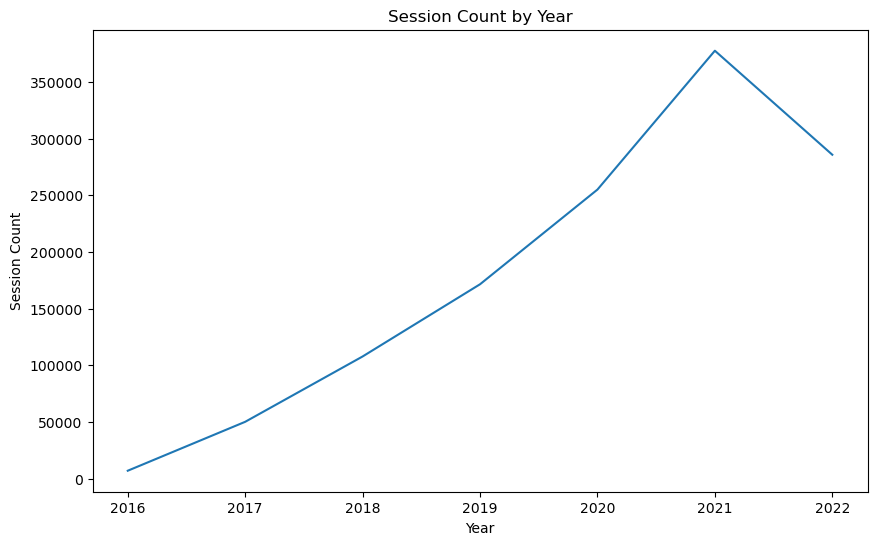

In [246]:
plt.subplots(figsize=(10, 6))  # Adjust the figsize as needed
df_transaction.groupby(df_transaction.created_at.dt.year).count()['session_id'].plot.line()

# Adding labels and title
plt.xlabel('Year')
plt.ylabel('Session Count')
plt.title('Session Count by Year');

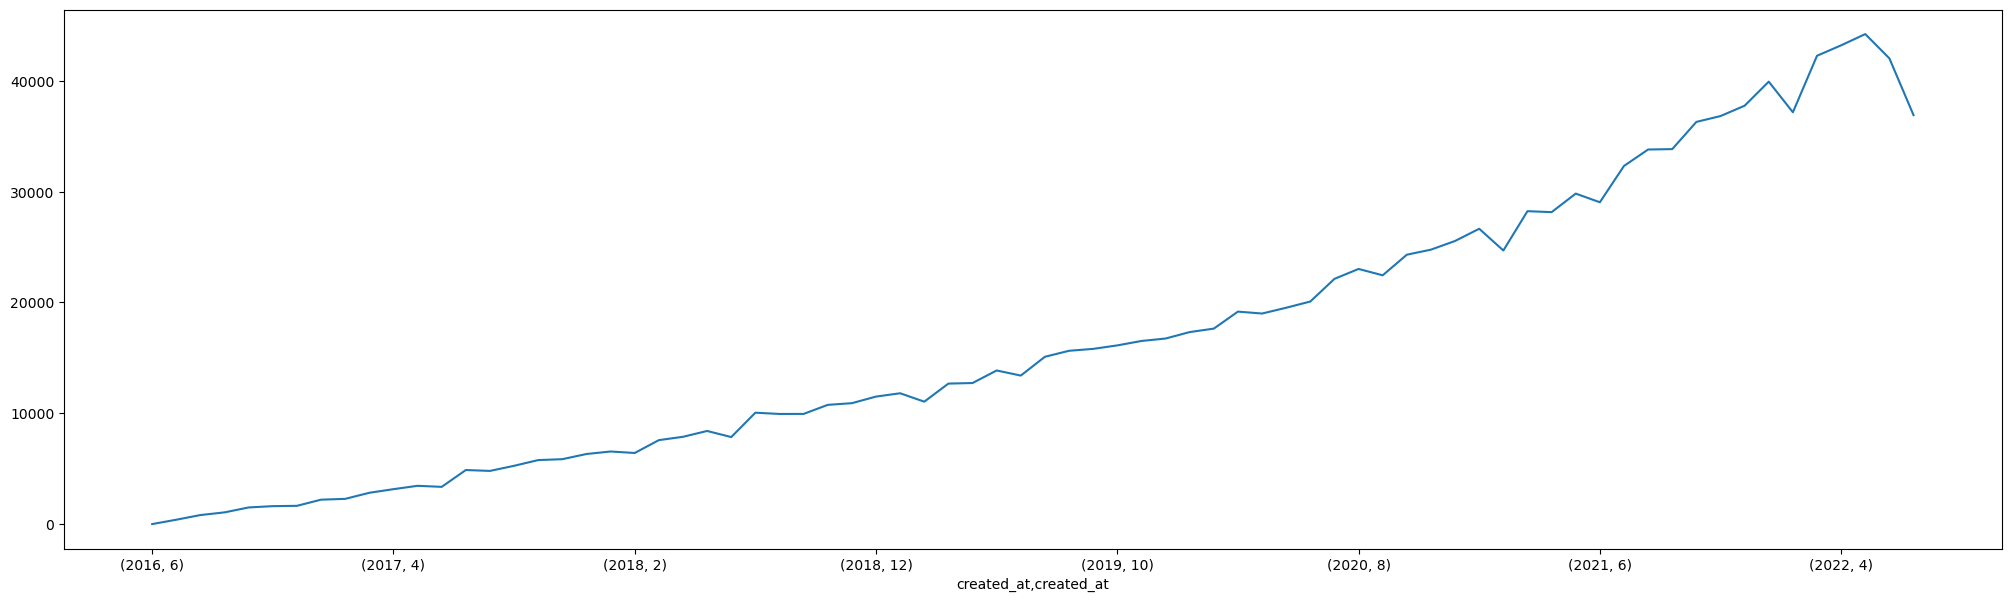

In [247]:
plt.subplots(figsize=(25,7))
col = df_transaction['created_at'].dt
df_transaction_year = df_transaction.groupby([col.year, col.month])['customer_id'].count()
df_transaction_year.plot.line();

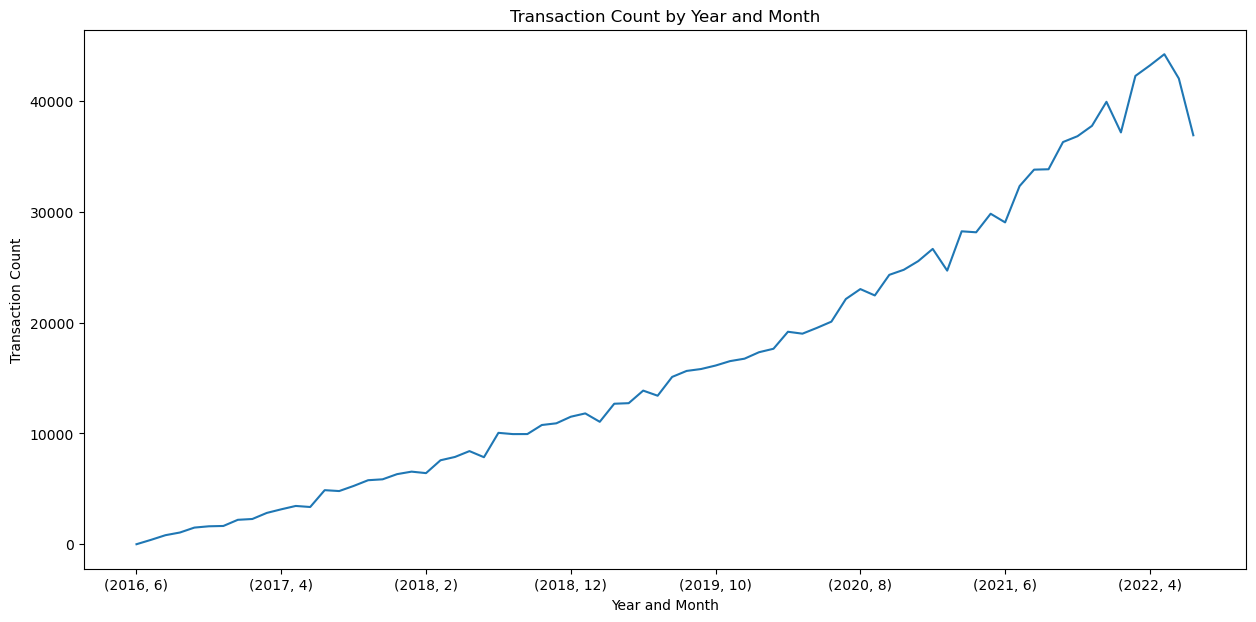

In [248]:
df_transaction['created_at_new2'] = pd.to_datetime(df_transaction['created_at'])

# Group by year and month, and count the occurrences
col = df_transaction['created_at_new2'].dt
df_transaction_new_year = df_transaction.groupby([col.year, col.month])['customer_id'].count()

# Create a line plot of counts
plt.subplots(figsize=(15, 7))  # Adjust the figsize as needed
df_transaction_new_year.plot.line()

# Adding labels and title
plt.xlabel('Year and Month')
plt.ylabel('Transaction Count')
plt.title('Transaction Count by Year and Month')

plt.show()

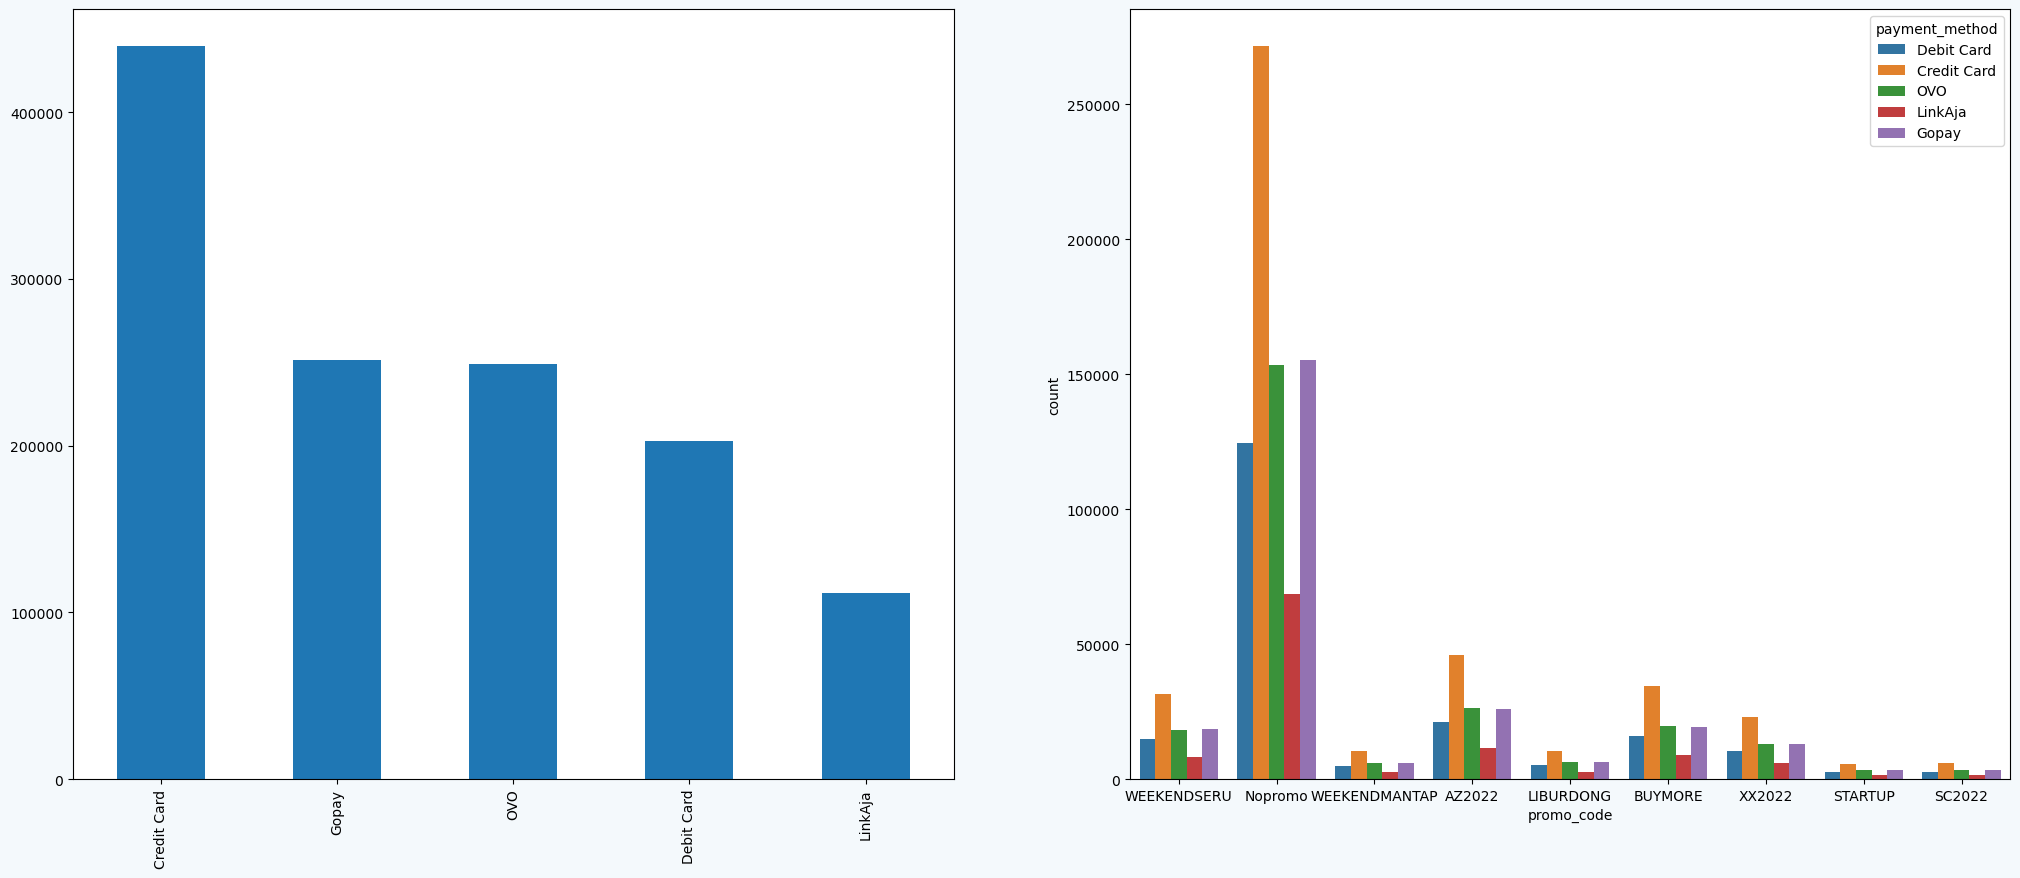

In [249]:
# payment method

fig, axes = plt.subplots(1,2,figsize=(25,10), facecolor = '#F4F9FC')

# 지불 방식 분포 
df_transaction.payment_method.value_counts().plot.bar(ax=axes[0])

# 프로모션별 지불방식 분포
sns.countplot(data=df_transaction, x='promo_code', hue='payment_method',ax=axes[1]);

결제방식은 신용카드 이용률이 가장 높게 나옴 
프로모션 별 결제 방식도 신용카드 이용률이 높다 

In [250]:
# 배송 limit와 created_at 시간 차이 
# 지역 별로 거래 동향 파악해보기 - 소비지출이 높은 지역

In [251]:
df_transaction.item_price.describe()

count    1.254585e+06
mean     2.499744e+05
std      1.118733e+05
min      5.600000e+03
25%      1.683730e+05
50%      2.335400e+05
75%      3.136470e+05
max      1.200357e+06
Name: item_price, dtype: float64

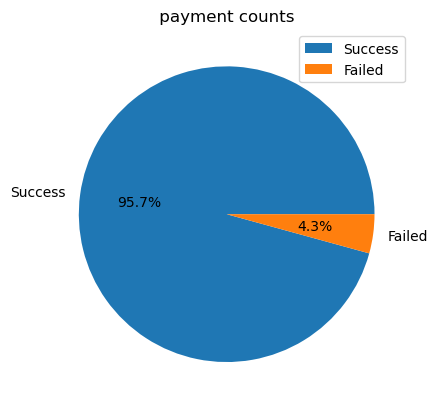

In [252]:
# 결제성공여부
counts = df_transaction['payment_status'].value_counts()
counts.plot(kind='pie', autopct='%1.1f%%')

plt.title(' payment counts ')
plt.legend()
plt.ylabel('')

plt.show()

In [253]:
# 거래 성공
success_transaction = df_transaction[df_transaction['payment_status']=='Success']

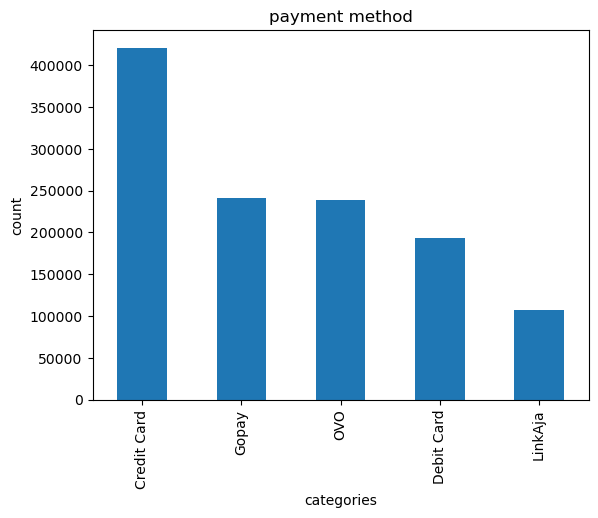

In [254]:
# 거래한 결제 수단

counts = success_transaction['payment_method'].value_counts()
counts.plot(kind='bar')

plt.xlabel('categories')
plt.ylabel('count')
plt.title('payment method')
plt.show()

In [255]:
# 거래 실패
fail_transaction = df_transaction[df_transaction['payment_status']=='Failed']

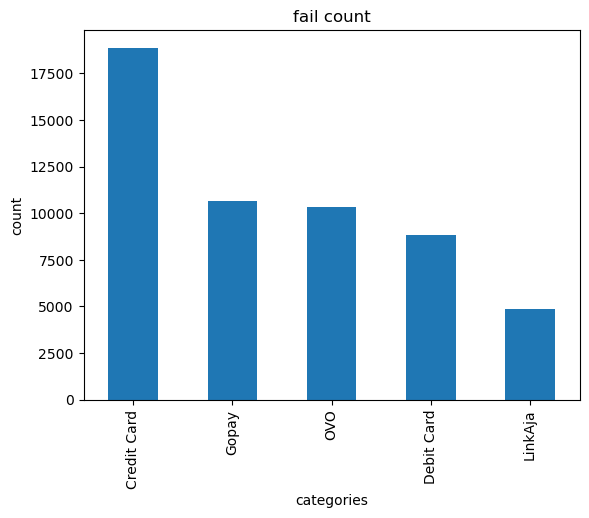

In [256]:
# 거래실패 결제수단
counts = fail_transaction['payment_method'].value_counts()
counts.plot(kind='bar')
 
plt.xlabel('categories')
plt.ylabel('count')
plt.title('fail count')

plt.show()

Success    0.957317
Failed     0.042683
Name: payment_status, dtype: float64


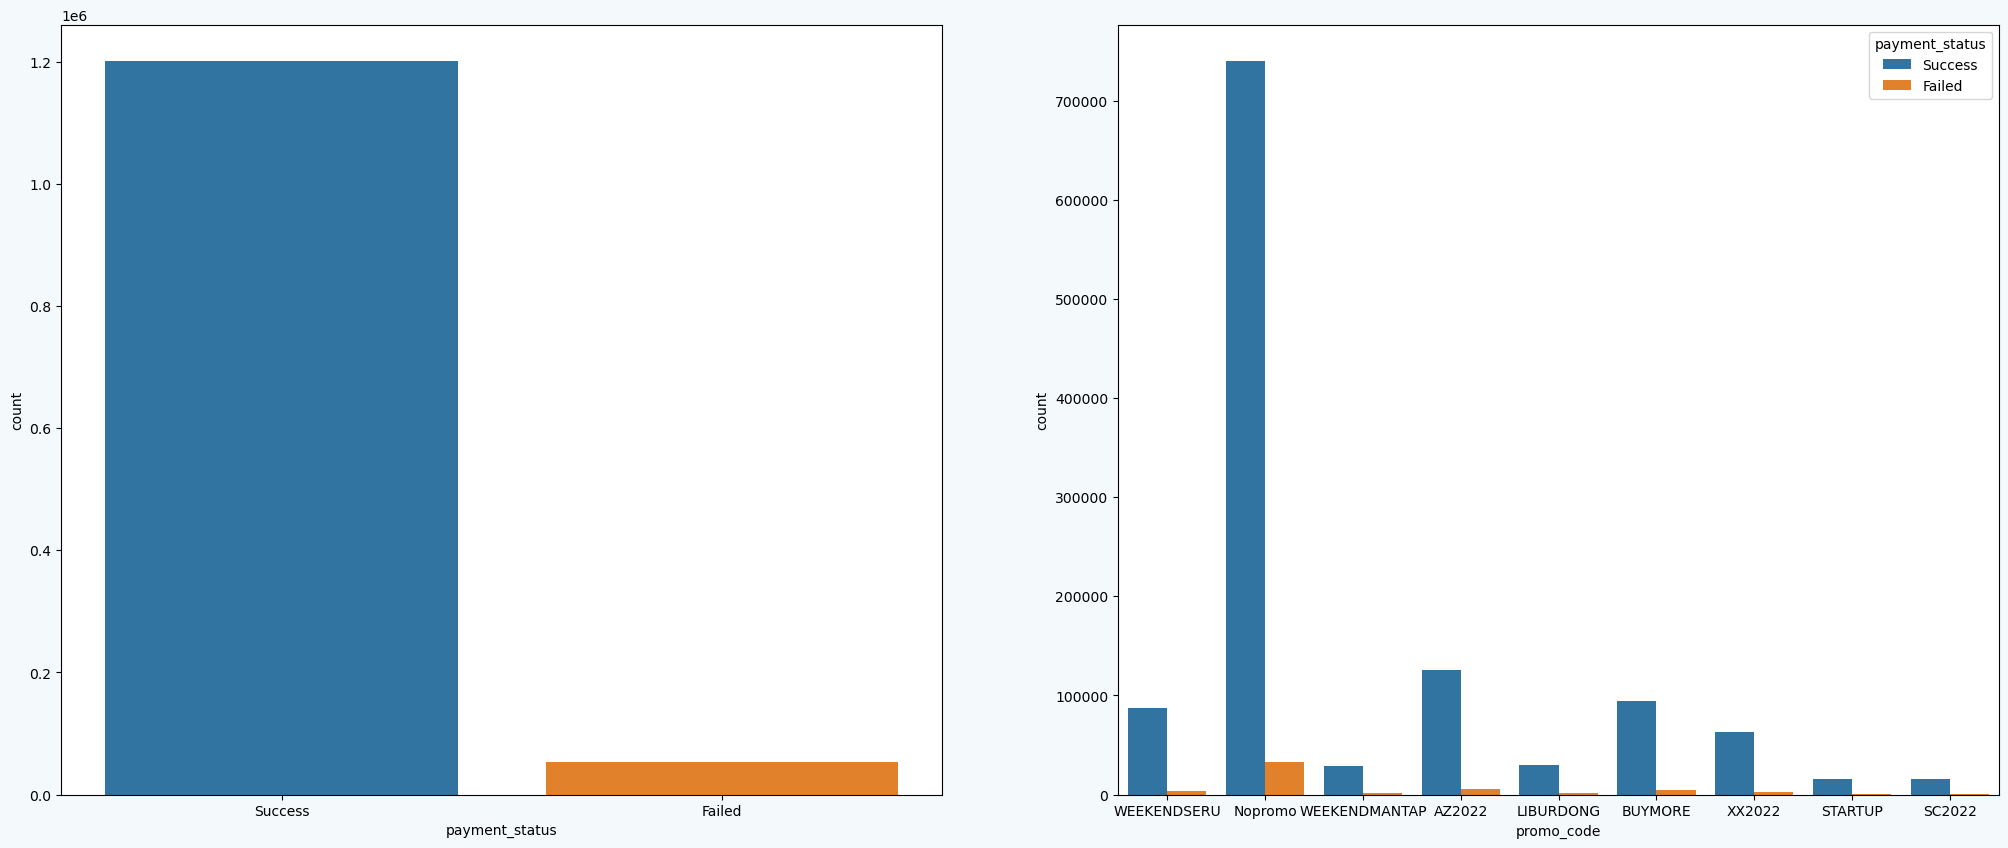

In [257]:
# payment_statu

fig, axes = plt.subplots(1,2, figsize=(25, 10), facecolor='#F4F9FC')

# 결제 성공 여부
sns.countplot(x='payment_status', data=df_transaction, ax=axes[0])

# 결제 성공 비율
print(df_transaction.payment_status.value_counts(normalize=True))

# 프로모션별 비율 
sns.countplot(x='promo_code', data=df_transaction, hue='payment_status', ax=axes[1]);

결제 성공 : 96% / 결제 실패 : 4%

결제 실패 이유..? - 잔액부족인가 

no promotion (promo_code 미적용) 많은 비중 차지함 

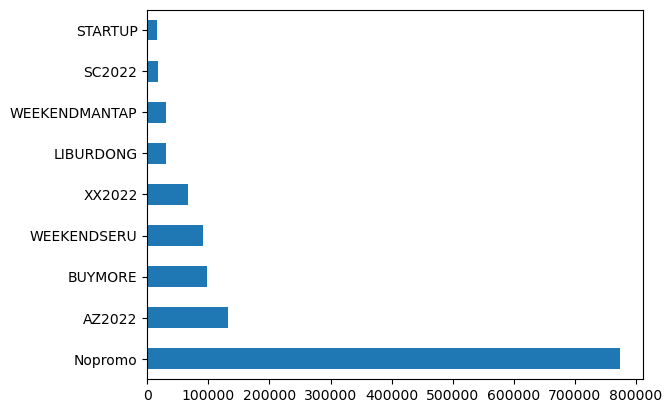

In [258]:
df_transaction.promo_code.value_counts().plot.barh();

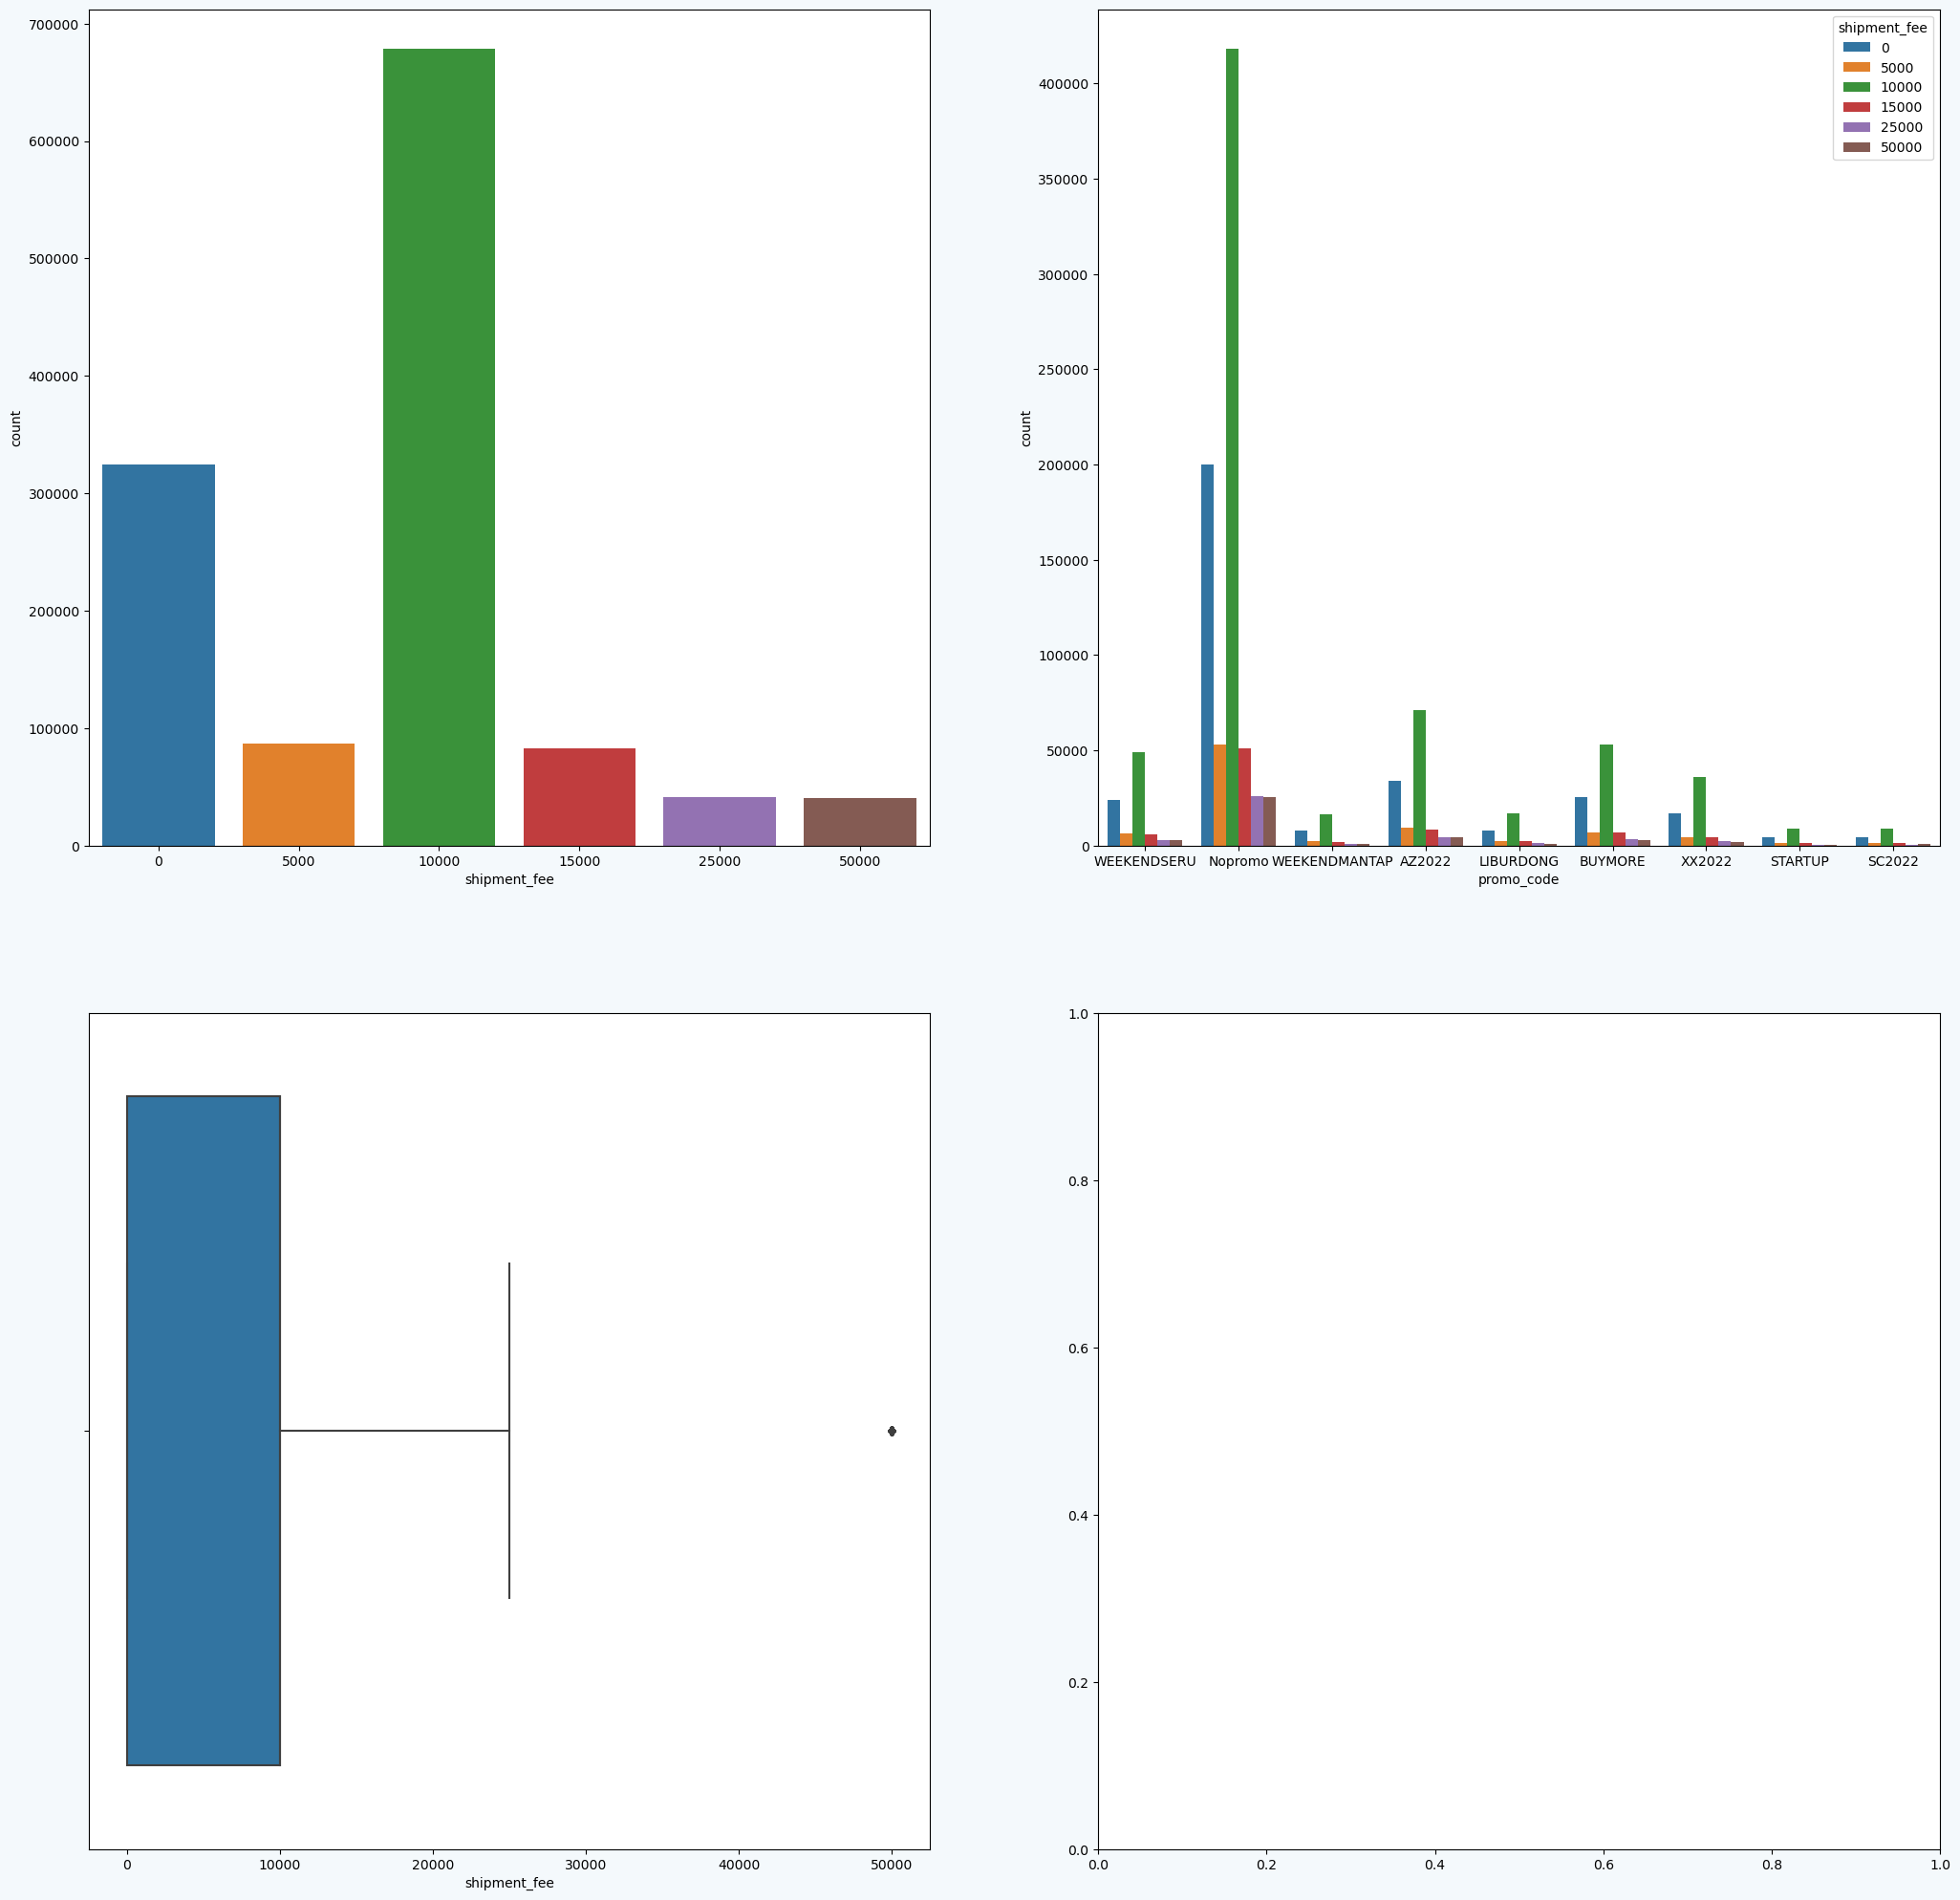

In [259]:
# 배달비 

fig, axes= plt.subplots(2,2, figsize=(25,25), facecolor='#F4F9FC')

# 배달비 분포도
sns.countplot(data= df_transaction, x='shipment_fee', ax=axes[0,0])

# 프로모션별 배달비 분포도
sns.countplot(data=df_transaction, x='promo_code', hue='shipment_fee', ax=axes[0,1])

# 배달비 boxplot
sns.boxplot(data=df_transaction, x='shipment_fee', ax=axes[1,0]);

배달비는 10000이 압도적으로 많음 / 프로모션별도 비슷한 추이 

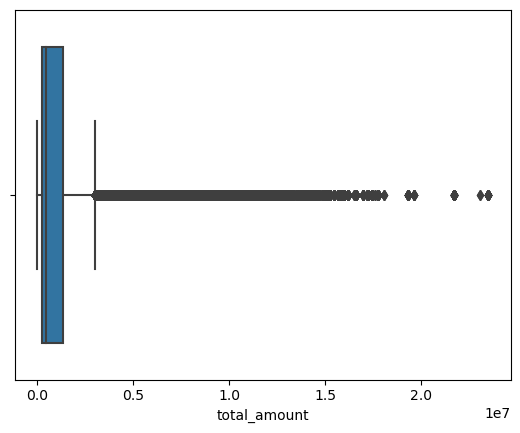

In [260]:
# 총 가격
sns.boxplot(data=df_transaction, x='total_amount');

아웃라이어 제거하면, 사용자가 어떤 물건을 샀는 지 파악 불가능 

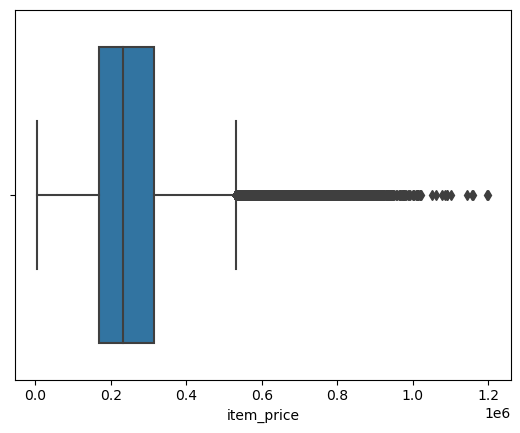

In [261]:
# item price 
sns.boxplot(data=df_transaction, x='item_price');

In [262]:
df_transaction.item_price.describe()

count    1.254585e+06
mean     2.499744e+05
std      1.118733e+05
min      5.600000e+03
25%      1.683730e+05
50%      2.335400e+05
75%      3.136470e+05
max      1.200357e+06
Name: item_price, dtype: float64

아웃라이어 --> 사용자 물품 구매 내역 파악 어려움 



In [263]:
# 새로운 테이블 생성 - 날짜별 고객별 구매 정보 데이터 

# Convert columns to datetime if needed
df_transaction['shipment_date_limit'] = pd.to_datetime(df_transaction['shipment_date_limit'])
df_transaction['created_at'] = pd.to_datetime(df_transaction['created_at'])

# Handle null values if needed
df_transaction.dropna(subset=['shipment_date_limit', 'created_at'], inplace=True)

# Calculate shipment_period
df_transaction['shipment_period'] = df_transaction['shipment_date_limit'] - df_transaction['created_at']

# Fill missing promo_code with 'No promo'
df_transaction.loc[df_transaction['promo_code'].isnull(), 'promo_code'] = 'No promo'


In [264]:
# error
# transaction1 = df_transaction.groupby(['created_at', 'customer_id']).agg({'promo_amount':'max', 'shipment_fee'})

quantity


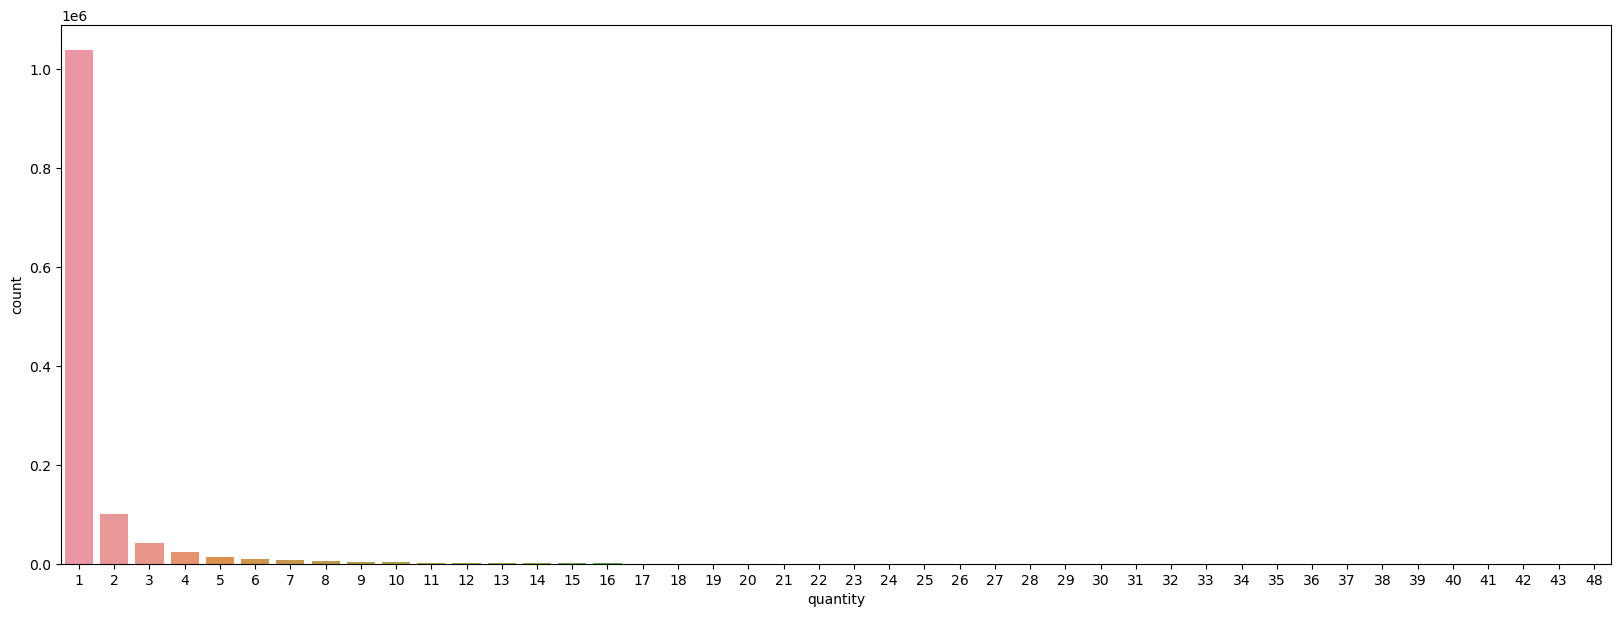

In [265]:
plt.subplots(figsize=(20, 7))
sns.countplot(data=df_transaction, x='quantity');

In [266]:
df_transaction.quantity.value_counts(normalize=True).apply(lambda x: "{:.2%}".format(x))

1     82.79%
2      8.03%
3      3.30%
4      1.88%
5      1.15%
6      0.79%
7      0.55%
8      0.39%
9      0.28%
10     0.20%
11     0.15%
12     0.11%
13     0.09%
14     0.07%
15     0.05%
16     0.04%
17     0.03%
18     0.02%
19     0.02%
20     0.01%
21     0.01%
22     0.01%
23     0.01%
24     0.00%
25     0.00%
26     0.00%
27     0.00%
29     0.00%
28     0.00%
33     0.00%
31     0.00%
32     0.00%
34     0.00%
36     0.00%
40     0.00%
35     0.00%
38     0.00%
41     0.00%
30     0.00%
39     0.00%
37     0.00%
48     0.00%
42     0.00%
43     0.00%
Name: quantity, dtype: object

1개 구매한 사람 82% 차지 


item price

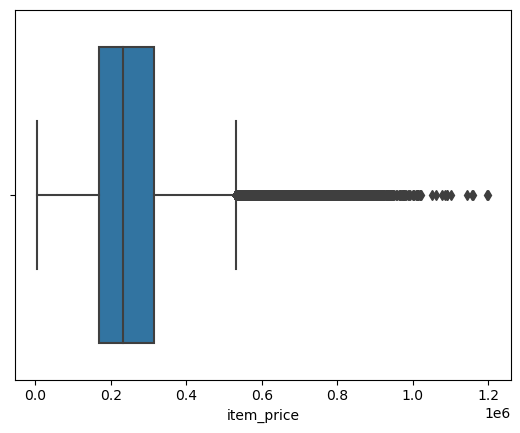

In [267]:
sns.boxplot(data=df_transaction, x= 'item_price');

In [268]:
df_transaction.item_price.describe().apply(lambda x: "{:.2f}".format(x))

count    1254585.00
mean      249974.44
std       111873.32
min         5600.00
25%       168373.00
50%       233540.00
75%       313647.00
max      1200357.00
Name: item_price, dtype: object

프로모션에 따른 여러 컬럼들과의 관계에서 유의미한 것 뭐지 



날짜별 고객별 구매정보 

In [269]:
# 배달 기간 -- 오류 
df_transaction['shipment_date_limit'] = pd.to_datetime(df_transaction['shipment_date_limit'])
df_transaction['created_at'] = pd.to_datetime(df_transaction['created_at'])

df_transaction['shipment_period'] = df_transaction.shipment_date_limit - df_transaction.created_at


# promotion -- 결측치 -- no promo
df_transaction.loc[df_transaction['promo_code'].isnull(), 'promo_code'] = 'Nopromo'


In [270]:
df_transaction

created_at  customer_id  \
0       2018-07-29 15:22:00         5868   
1       2018-07-30 12:40:00         4774   
2       2018-09-15 11:51:00         4774   
3       2018-11-01 11:23:00         4774   
4       2018-12-18 11:20:00         4774   
...                     ...          ...   
1254580 2021-09-21 22:10:00        25121   
1254581 2021-12-09 07:35:00        34829   
1254582 2021-12-11 01:20:00        99645   
1254583 2019-12-18 11:01:00        87319   
1254584 2019-12-19 12:47:00        58180   

                                   booking_id  \
0        186e2bee-0637-4710-8981-50c2d737bc42   
1        caadb57b-e808-4f94-9e96-8a7d4c9898db   
2        6000fffb-9c1a-4f4a-9296-bc8f6b622b50   
3        f5e530a7-4350-4cd1-a3bc-525b5037bcab   
4        0efc0594-dbbf-4f9a-b0b0-a488cfddf8a2   
...                                       ...   
1254580  66f02fa4-c62e-497a-8b6e-be239009b50a   
1254581  ccde6b83-ee42-4cce-b2cd-976574886eac   
1254582  5bcd3434-1dc6-44bb-ae63-fd19714cbd6c   
1254583  af7f291a-b01b-4bfd-89a9-237b16368b15   
1254584  b242e188-5f94-4448-a038-c5865842374b   

                                   session_id payment_method payment_status  \
0        3abaa6ce-e320-4e51-9469-d9f3fa328e86     Debit Card        Success   
1        2ee5ead1-f13e-4759-92df-7ff48475e970    Credit Card        Success   
2        93325fb6-eb00-4268-bb0e-6471795a0ad0            OVO        Success   
3        bcad5a61-1b67-448d-8ff4-781d67bc56e4    Credit Card        Success   
4        df1042ab-13e6-4072-b9d2-64a81974c51a    Credit Card        Success   
...                                       ...            ...            ...   
1254580  484eecde-9f4a-42de-a8df-7ce6668101f4     Debit Card         Failed   
1254581  954e1211-4d45-4d0b-ba84-53e80119592c            OVO        Success   
1254582  e6e6c108-abd0-49a2-b0a5-691117f9cfe1    Credit Card        Success   
1254583  bb6e5426-a3f3-426a-b99d-79173eaa234b    Credit Card        Success   
1254584  5e3183df-198b-40e0-b861-27ef694a832a          Gopay        Success   

         promo_amount   promo_code  shipment_fee shipment_date_limit  \
0                1415  WEEKENDSERU         10000 2018-08-03 05:07:00   
1                   0      Nopromo         10000 2018-08-03 01:29:00   
2                   0      Nopromo         10000 2018-09-18 08:41:00   
3                   0      Nopromo             0 2018-11-05 17:42:00   
4                   0      Nopromo             0 2018-12-23 17:24:00   
...               ...          ...           ...                 ...   
1254580             0      Nopromo             0 2021-09-27 00:43:00   
1254581          5010       AZ2022         10000 2021-12-12 07:52:00   
1254582          2181  WEEKENDSERU          5000 2021-12-12 13:28:00   
1254583          4503       AZ2022             0 2019-12-23 22:56:00   
1254584          4724      BUYMORE         10000 2019-12-23 06:02:00   

         shipment_location_lat  shipment_location_long  total_amount  \
0                    -8.227893              111.969107        199832   
1                     3.013470              107.802514        155526   
2                    -2.579428              115.743885        550696   
3                    -3.602334              120.363824        271012   
4                    -3.602334              120.363824        198753   
...                        ...                     ...           ...   
1254580              -6.869535              111.077145        226820   
1254581              -8.677264              115.176947        359203   
1254582              -6.185498              106.831093       1158159   
1254583              -7.155977              110.891858        184143   
1254584              -6.155983              106.723535        365963   

         product_id  quantity  item_price  shipment_date     created_at_new2  \
0             54728         1      191247              4 2018-07-29 15:22:00   
1             16193         1      145526              3 201

In [271]:
df_transaction1 = df_transaction.groupby(['created_at','customer_id']).agg({'promo_amount':'max','shipment_fee':'max', 'total_amount':'max',
                                                                          'quantity':'sum','shipment_period':'max'}).sort_index(ascending=True).reset_index()
df_transaction2 = df_transaction[['created_at','customer_id','booking_id','session_id','total_amount', 'promo_code', 'payment_method', 'payment_status']].drop_duplicates()

In [272]:
df_transaction1

created_at  customer_id  promo_amount  shipment_fee  \
0      2016-06-30 23:18:00        74089             0         10000   
1      2016-07-01 02:53:00         6183          6053         10000   
2      2016-07-01 09:45:00        16228             0         15000   
3      2016-07-01 22:32:00        73773             0         10000   
4      2016-07-02 05:28:00        37770             0         10000   
...                    ...          ...           ...           ...   
852522 2022-07-31 23:58:00        19551          5800         15000   
852523 2022-07-31 23:58:00        27522             0         10000   
852524 2022-07-31 23:58:00        81975             0             0   
852525 2022-07-31 23:59:00        19551          6489         10000   
852526 2022-07-31 23:59:00        22285             0          5000   

        total_amount  quantity shipment_period  
0             640795         3 3 days 18:17:00  
1             578826         2 5 days 00:12:00  
2             333792         1 2 days 09:25:00  
3             256670         1 4 days 17:30:00  
4             543010         2 2 days 10:36:00  
...              ...       ...             ...  
852522       1806077        11 4 days 06:02:00  
852523        238288         1 4 days 01:23:00  
852524        852675         4 3 days 21:36:00  
852525        202327         2 3 days 23:58:00  
852526        155339         1 4 days 14:57:00  

[852527 rows x 7 columns]

In [273]:
df_transaction2

created_at  customer_id  \
0       2018-07-29 15:22:00         5868   
1       2018-07-30 12:40:00         4774   
2       2018-09-15 11:51:00         4774   
3       2018-11-01 11:23:00         4774   
4       2018-12-18 11:20:00         4774   
...                     ...          ...   
1254580 2021-09-21 22:10:00        25121   
1254581 2021-12-09 07:35:00        34829   
1254582 2021-12-11 01:20:00        99645   
1254583 2019-12-18 11:01:00        87319   
1254584 2019-12-19 12:47:00        58180   

                                   booking_id  \
0        186e2bee-0637-4710-8981-50c2d737bc42   
1        caadb57b-e808-4f94-9e96-8a7d4c9898db   
2        6000fffb-9c1a-4f4a-9296-bc8f6b622b50   
3        f5e530a7-4350-4cd1-a3bc-525b5037bcab   
4        0efc0594-dbbf-4f9a-b0b0-a488cfddf8a2   
...                                       ...   
1254580  66f02fa4-c62e-497a-8b6e-be239009b50a   
1254581  ccde6b83-ee42-4cce-b2cd-976574886eac   
1254582  5bcd3434-1dc6-44bb-ae63-fd19714cbd6c   
1254583  af7f291a-b01b-4bfd-89a9-237b16368b15   
1254584  b242e188-5f94-4448-a038-c5865842374b   

                                   session_id  total_amount   promo_code  \
0        3abaa6ce-e320-4e51-9469-d9f3fa328e86        199832  WEEKENDSERU   
1        2ee5ead1-f13e-4759-92df-7ff48475e970        155526      Nopromo   
2        93325fb6-eb00-4268-bb0e-6471795a0ad0        550696      Nopromo   
3        bcad5a61-1b67-448d-8ff4-781d67bc56e4        271012      Nopromo   
4        df1042ab-13e6-4072-b9d2-64a81974c51a        198753      Nopromo   
...                                       ...           ...          ...   
1254580  484eecde-9f4a-42de-a8df-7ce6668101f4        226820      Nopromo   
1254581  954e1211-4d45-4d0b-ba84-53e80119592c        359203       AZ2022   
1254582  e6e6c108-abd0-49a2-b0a5-691117f9cfe1       1158159  WEEKENDSERU   
1254583  bb6e5426-a3f3-426a-b99d-79173eaa234b        184143       AZ2022   
1254584  5e3183df-198b-40e0-b861-27ef694a832a        365963      BUYMORE   

        payment_method payment_status  
0           Debit Card        Success  
1          Credit Card        Success  
2                  OVO        Success  
3          Credit Card        Success  
4          Credit Card        Success  
...                ...            ...  
1254580     Debit Card         Failed  
1254581            OVO        Success  
1254582    Credit Card        Success  
1254583    Credit Card        Success  
1254584          Gopay        Success  

[852584 rows x 8 columns]

In [274]:
# 합치기 
df_transaction_merge = pd.merge(df_transaction1, df_transaction2, on=['created_at', 'customer_id', 'total_amount'])

# 프로모션 유무 컬럼 추가 
df_transaction_merge['promo_yesno'] = df_transaction_merge.promo_code.apply(lambda x:'x' if x=='Nopromo' else 'o')

# 날짜  
df_transaction_merge['created_at_2'] =df_transaction_merge['created_at'].apply(lambda x: datetime.strftime(x, '%Y-%m'))
df_transaction_merge

created_at  customer_id  promo_amount  shipment_fee  \
0      2016-06-30 23:18:00        74089             0         10000   
1      2016-07-01 02:53:00         6183          6053         10000   
2      2016-07-01 09:45:00        16228             0         15000   
3      2016-07-01 22:32:00        73773             0         10000   
4      2016-07-02 05:28:00        37770             0         10000   
...                    ...          ...           ...           ...   
852522 2022-07-31 23:58:00        19551          5800         15000   
852523 2022-07-31 23:58:00        27522             0         10000   
852524 2022-07-31 23:58:00        81975             0             0   
852525 2022-07-31 23:59:00        19551          6489         10000   
852526 2022-07-31 23:59:00        22285             0          5000   

        total_amount  quantity shipment_period  \
0             640795         3 3 days 18:17:00   
1             578826         2 5 days 00:12:00   
2             333792         1 2 days 09:25:00   
3             256670         1 4 days 17:30:00   
4             543010         2 2 days 10:36:00   
...              ...       ...             ...   
852522       1806077        11 4 days 06:02:00   
852523        238288         1 4 days 01:23:00   
852524        852675         4 3 days 21:36:00   
852525        202327         2 3 days 23:58:00   
852526        155339         1 4 days 14:57:00   

                                  booking_id  \
0       2dd76c45-6ddb-46b4-9c91-c59d4f9b76ba   
1       b9724455-552e-4deb-9351-4a4fe4ee0b8f   
2       8035f5b3-2a7c-4e30-ab4a-9b3091edc37f   
3       5f390336-0a5f-4e0d-bfe1-df080269ce45   
4       faa3f7c3-7f2a-40e1-af74-acec3785c63a   
...                                      ...   
852522  44cad47a-bc7f-4ead-985c-e4183c7dc56d   
852523  5312f052-20c3-4034-b0d8-40d609ea51d6   
852524  bbee4544-3d89-44f4-8fb7-d1796d3cd45e   
852525  1f9b9f8a-1a72-4e4c-87a6-355390a7abf6   
852526  a43bfc27-6a49-465b-8690-901b8d79acef   

                                  session_id promo_code payment_method  \
0       607d864b-76b5-45a1-a45d-7fb666a03ea1    Nopromo        LinkAja   
1       c5d3792d-9220-47db-ad80-4932f3f88d0e     XX2022            OVO   
2       bbff775e-4166-46aa-bbfd-4ba6465add17    Nopromo     Debit Card   
3       8f385c80-1b70-4861-80ac-5eb3b5620fee    Nopromo     Debit Card   
4       df175a0e-f6e4-4d9a-a76a-38976e09ccf1    Nopromo    Credit Card   
...                                      ...        ...            ...   
852522  1a22623f-1ec1-412a-ba7a-e6dffcc46df9    Nopromo    Credit Card   
852523  fa4aee66-d7da-4a42-a54e-fdffed2bb302    Nopromo     Debit Card   
852524  6d4c72ec-b900-4c45-a37e-9cfe18452fc7    Nopromo     Debit Card   
852525  b0043d8b-2b6a-443a-80f2-567486e79bf9    Nopromo          Gopay   
852526  f837b3a2-7908-42df-8969-3f879ebb4c25    Nopromo        LinkAja   

       payment_status promo_yesno created_at_2  
0             Success           x      2016-06  
1             Success           o      2016-07  
2             Success           x      2016-07  
3             Success           x      2016-07  
4             Success           x      2016-07  
...               ...         ...          ...  
852522        Success           x      2022-07  
852523        Success           x      2022-07  
852524        Success           x      2022-07  
852525        Success           x      2022-07  
852526        Success           x      2022-07  

[852527 rows x 14 columns]

In [275]:
df_customer = pd.read_csv('customer.csv')

In [276]:
# 고객 성비
df_customer.gender.value_counts(normalize=True).apply(lambda x: "{:.2f}".format(x))

F    0.64
M    0.36
Name: gender, dtype: object

In [277]:
# df_customer + df_transaction_merge

cus_tran_merge = pd.merge(df_transaction_merge, df_customer, on=['customer_id'], how='right')
cus_tran_merge

created_at  customer_id  promo_amount  shipment_fee  \
0                      NaT         2870           NaN           NaN   
1                      NaT         8193           NaN           NaN   
2      2020-08-23 12:53:00         7279        2853.0       15000.0   
3      2020-08-31 13:34:00         7279           0.0       10000.0   
4      2020-09-08 13:38:00         7279           0.0           0.0   
...                    ...          ...           ...           ...   
901817 2021-12-07 17:31:00        40573           0.0       10000.0   
901818 2022-01-23 19:01:00        40573        4532.0       10000.0   
901819 2022-03-11 19:03:00        40573           0.0       25000.0   
901820 2022-04-27 20:00:00        40573           0.0       10000.0   
901821 2022-06-13 21:03:00        40573           0.0           0.0   

        total_amount  quantity shipment_period  \
0                NaN       NaN             NaT   
1                NaN       NaN             NaT   
2           844751.0       3.0 2 days 16:21:00   
3           391341.0       1.0 3 days 16:15:00   
4           154220.0       1.0 5 days 21:48:00   
...              ...       ...             ...   
901817     1200173.0       4.0 4 days 20:38:00   
901818      110483.0       1.0 2 days 06:40:00   
901819      276290.0       1.0 2 days 07:13:00   
901820      258774.0       1.0 1 days 10:40:00   
901821      551560.0       2.0 4 days 08:38:00   

                                  booking_id  \
0                                        NaN   
1                                        NaN   
2       1fb6f149-05ef-4a22-ac1a-cd5d98cd5510   
3       eed52035-1f80-422c-b0ac-a1c814e77bcf   
4       af568d06-c819-4ab4-a3e8-06857786ba10   
...                                      ...   
901817  6324e721-b59b-4c8b-9570-5ad30112be1e   
901818  65367fff-1522-4c80-a0f7-1306676bd947   
901819  7df40e00-5e2c-40c5-99f7-0e451ca82de4   
901820  ae2b3e5b-0053-4671-ae18-f5a60b8a14dd   
901821  7327ce54-eecb-4f75-894d-78bc3bd7a26a   

                                  session_id   promo_code  ... gender  \
0                                        NaN          NaN  ...      F   
1                                        NaN          NaN  ...      F   
2       9d0496a6-37f7-4d0a-8a04-5850a12d00a6  WEEKENDSERU  ...      M   
3       82396d8d-7d8a-436d-8e14-75f24aa35faa      Nopromo  ...      M   
4       348cc997-480b-467e-a502-1eed0f611e9d      Nopromo  ...      M   
...                                      ...          ...  ...    ...   
901817  f22b54dd-2766-4ac4-9e8e-9fb4572f6b03      Nopromo  ...      F   
901818  4bb58af9-b2df-4c48-bcb7-d68749625cee  WEEKENDSERU  ...      F   
901819  a9c839a8-f945-4edb-b262-1d9196e2f827      Nopromo  ...      F   
901820  fcbf4865-4006-4bab-b9ca-3c0c0241c23d      Nopromo  ...      F   
901821  bc333dd8-66bb-491d-a5b6-beea36e3a994      Nopromo  ...      F   

         birthdate device_type                             device_id  \
0       1996-06-14         iOS  c9c0de76-0a6c-4ac2-843f-65264ab9fe63   
1       1993-08-16     Android  fb331c3d-f42e-40fe-afe2-b4b73a8a6e25   
2       1989-01-23         iOS  d13dde0a-6ae1-43c3-83a7-11bbb922730b   
3       1989-01-23         iOS  d13dde0a-6ae1-43c3-83a7-11bbb922730b   
4       1989-01-23         iOS  d13dde0a-6ae1-43c3-83a7-11bbb922730b   
...            ...         ...                                   ...   
901817  1987-09-10     Android  b6bc29e0-5a22-47af-b31e-0972aafd4cab   
901818  1987-09-10     Android  b6bc29e0-5a22-47af-b31e-0972aafd4cab   
901819  1987-09-10     Android  b6bc29e0-5a22-47af-b31e-0972aafd4cab   
901820  1987-09-10     Android  b6bc29e0-5a22-47af-b31e-0972aafd4cab   
901821  1987-09-10     Android  b6bc29e0-5a22-47af-b31e-0972aafd4cab   

                                    device_version home_location_lat  \
0       iPhone; CPU iPhone OS 14_2_1 like Mac OS X         -1.043345   
1                                    Android 2.2.1         -6.212489   
2            iPad; CPU iPad

In [278]:

# # Convert columns to datetime
# cus_tran_merge['first_join_date'] = pd.to_datetime(cus_tran_merge['first_join_date'])
# cus_tran_merge['birthdate'] = pd.to_datetime(cus_tran_merge['birthdate'])
# cus_tran_merge['created_at'] = pd.to_datetime(cus_tran_merge['created_at'])

# # Other data processing steps

# # Calculate age
# current_date = datetime.now().date()
# cus_tran_merge['age'] = (current_date - cus_tran_merge['birthdate'].dt.date).dt.days // 365

# cus_tran_merge

In [279]:
# 합친 데이터 저장 
cus_tran_merge.to_csv('cus_tran_merge.csv', index=False)

In [280]:
# 데이터타입 변환
columns_datetype_change(cus_tran_merge,'first_join_date','datetime64')
columns_datetype_change(cus_tran_merge,'birthdate','datetime64')


cus_tran_merge['first_join_date'] = pd.to_datetime(cus_tran_merge['first_join_date'])
cus_tran_merge['join_date'] = cus_tran_merge['first_join_date'].dt.strftime('%Y-%m')
cus_tran_merge['join_month'] = cus_tran_merge['first_join_date'].dt.strftime('%m')
cus_tran_merge['join_day'] = cus_tran_merge['first_join_date'].dt.strftime('%d')
cus_tran_merge['join_year'] = cus_tran_merge['first_join_date'].dt.strftime('%Y')
# cus_tran_merge.drop(columns=['first_name','last_name','username','email','device_id','device_version'],axis=1,inplace=True)


# created_at_3 = 첫 구매 

cus_tran_merge['created_at_3'] = pd.to_datetime(cus_tran_merge['created_at']).dt.strftime('%Y-%m-%d')
cus_tran_merge['period_enrollment'] = (pd.to_datetime(cus_tran_merge['created_at']) - cus_tran_merge['first_join_date']).dt.days.fillna(-1)
# period_enrollment 가입 후 첫 구매까지의 기간  
from datetime import datetime
current_date = datetime.now().date()
cus_tran_merge['birthdate'] = pd.to_datetime(cus_tran_merge['birthdate'])
current_date = datetime.now().date()

cus_tran_merge

created_at  customer_id  promo_amount  shipment_fee  \
0                      NaT         2870           NaN           NaN   
1                      NaT         8193           NaN           NaN   
2      2020-08-23 12:53:00         7279        2853.0       15000.0   
3      2020-08-31 13:34:00         7279           0.0       10000.0   
4      2020-09-08 13:38:00         7279           0.0           0.0   
...                    ...          ...           ...           ...   
901817 2021-12-07 17:31:00        40573           0.0       10000.0   
901818 2022-01-23 19:01:00        40573        4532.0       10000.0   
901819 2022-03-11 19:03:00        40573           0.0       25000.0   
901820 2022-04-27 20:00:00        40573           0.0       10000.0   
901821 2022-06-13 21:03:00        40573           0.0           0.0   

        total_amount  quantity shipment_period  \
0                NaN       NaN             NaT   
1                NaN       NaN             NaT   
2           844751.0       3.0 2 days 16:21:00   
3           391341.0       1.0 3 days 16:15:00   
4           154220.0       1.0 5 days 21:48:00   
...              ...       ...             ...   
901817     1200173.0       4.0 4 days 20:38:00   
901818      110483.0       1.0 2 days 06:40:00   
901819      276290.0       1.0 2 days 07:13:00   
901820      258774.0       1.0 1 days 10:40:00   
901821      551560.0       2.0 4 days 08:38:00   

                                  booking_id  \
0                                        NaN   
1                                        NaN   
2       1fb6f149-05ef-4a22-ac1a-cd5d98cd5510   
3       eed52035-1f80-422c-b0ac-a1c814e77bcf   
4       af568d06-c819-4ab4-a3e8-06857786ba10   
...                                      ...   
901817  6324e721-b59b-4c8b-9570-5ad30112be1e   
901818  65367fff-1522-4c80-a0f7-1306676bd947   
901819  7df40e00-5e2c-40c5-99f7-0e451ca82de4   
901820  ae2b3e5b-0053-4671-ae18-f5a60b8a14dd   
901821  7327ce54-eecb-4f75-894d-78bc3bd7a26a   

                                  session_id   promo_code  ...  \
0                                        NaN          NaN  ...   
1                                        NaN          NaN  ...   
2       9d0496a6-37f7-4d0a-8a04-5850a12d00a6  WEEKENDSERU  ...   
3       82396d8d-7d8a-436d-8e14-75f24aa35faa      Nopromo  ...   
4       348cc997-480b-467e-a502-1eed0f611e9d      Nopromo  ...   
...                                      ...          ...  ...   
901817  f22b54dd-2766-4ac4-9e8e-9fb4572f6b03      Nopromo  ...   
901818  4bb58af9-b2df-4c48-bcb7-d68749625cee  WEEKENDSERU  ...   
901819  a9c839a8-f945-4edb-b262-1d9196e2f827      Nopromo  ...   
901820  fcbf4865-4006-4bab-b9ca-3c0c0241c23d      Nopromo  ...   
901821  bc333dd8-66bb-491d-a5b6-beea36e3a994      Nopromo  ...   

       home_location_long        home_location home_country first_join_date  \
0              101.360523       Sumatera Barat    Indonesia      2019-07-21   
1              106.818850         Jakarta Raya    Indonesia      2017-07-16   
2              116.428436  Nusa Tenggara Barat    Indonesia      2020-08-23   
3              116.428436  Nusa Tenggara Barat    Indonesia      2020-08-23   
4              116.428436  Nusa Tenggara Barat    Indonesia      2020-08-23   
...                   ...                  ...          ...             ...   
901817         106.283232               Banten    Indonesia      2021-07-17   
901818         106.283232               Banten    Indonesia      2021-07-17   
901819         106.283232               Banten    Indonesia      2021-07-17   
901820         106.283232               Banten    Indonesia      2021-07-17   
901821         106.283232               Banten    Indonesia      2021-07-17   

       join_date join_month join_day join_year created_at_3 period_enrollment  
0        2019-07         07       21      2019          NaN              -1.0  
1        2017-07         07       16      2017          NaN              -1.0  
2  

In [281]:
# Calculate age
current_date = datetime.now().date()

current_date

datetime.date(2023, 8, 28)

In [282]:
cus_tran_merge['birthdate']

0        1996-06-14
1        1993-08-16
2        1989-01-23
3        1989-01-23
4        1989-01-23
            ...    
901817   1987-09-10
901818   1987-09-10
901819   1987-09-10
901820   1987-09-10
901821   1987-09-10
Name: birthdate, Length: 901822, dtype: datetime64[ns]

In [283]:
# age는 현재 년도에서 태어난 년도를 뺀 값으로 오류가 있음
cus_tran_merge['age'] = current_date.year - cus_tran_merge['birthdate'].dt.year

# 오류를 제거하기 위해 월과 일을 오늘과 비교하여 8월 15 일 이전의 날이면 값을 제거
birthday_has_occurred = (current_date.month > cus_tran_merge['birthdate'].dt.month) | ((current_date.month == cus_tran_merge['birthdate'].dt.month) & (current_date.day >= cus_tran_merge['birthdate'].dt.day))

# age 에서 1을 제거한 adjusted_age가 진짜 나이
cus_tran_merge['adjusted_age'] = cus_tran_merge['age'] - birthday_has_occurred
cus_tran_merge

created_at  customer_id  promo_amount  shipment_fee  \
0                      NaT         2870           NaN           NaN   
1                      NaT         8193           NaN           NaN   
2      2020-08-23 12:53:00         7279        2853.0       15000.0   
3      2020-08-31 13:34:00         7279           0.0       10000.0   
4      2020-09-08 13:38:00         7279           0.0           0.0   
...                    ...          ...           ...           ...   
901817 2021-12-07 17:31:00        40573           0.0       10000.0   
901818 2022-01-23 19:01:00        40573        4532.0       10000.0   
901819 2022-03-11 19:03:00        40573           0.0       25000.0   
901820 2022-04-27 20:00:00        40573           0.0       10000.0   
901821 2022-06-13 21:03:00        40573           0.0           0.0   

        total_amount  quantity shipment_period  \
0                NaN       NaN             NaT   
1                NaN       NaN             NaT   
2           844751.0       3.0 2 days 16:21:00   
3           391341.0       1.0 3 days 16:15:00   
4           154220.0       1.0 5 days 21:48:00   
...              ...       ...             ...   
901817     1200173.0       4.0 4 days 20:38:00   
901818      110483.0       1.0 2 days 06:40:00   
901819      276290.0       1.0 2 days 07:13:00   
901820      258774.0       1.0 1 days 10:40:00   
901821      551560.0       2.0 4 days 08:38:00   

                                  booking_id  \
0                                        NaN   
1                                        NaN   
2       1fb6f149-05ef-4a22-ac1a-cd5d98cd5510   
3       eed52035-1f80-422c-b0ac-a1c814e77bcf   
4       af568d06-c819-4ab4-a3e8-06857786ba10   
...                                      ...   
901817  6324e721-b59b-4c8b-9570-5ad30112be1e   
901818  65367fff-1522-4c80-a0f7-1306676bd947   
901819  7df40e00-5e2c-40c5-99f7-0e451ca82de4   
901820  ae2b3e5b-0053-4671-ae18-f5a60b8a14dd   
901821  7327ce54-eecb-4f75-894d-78bc3bd7a26a   

                                  session_id   promo_code  ... home_country  \
0                                        NaN          NaN  ...    Indonesia   
1                                        NaN          NaN  ...    Indonesia   
2       9d0496a6-37f7-4d0a-8a04-5850a12d00a6  WEEKENDSERU  ...    Indonesia   
3       82396d8d-7d8a-436d-8e14-75f24aa35faa      Nopromo  ...    Indonesia   
4       348cc997-480b-467e-a502-1eed0f611e9d      Nopromo  ...    Indonesia   
...                                      ...          ...  ...          ...   
901817  f22b54dd-2766-4ac4-9e8e-9fb4572f6b03      Nopromo  ...    Indonesia   
901818  4bb58af9-b2df-4c48-bcb7-d68749625cee  WEEKENDSERU  ...    Indonesia   
901819  a9c839a8-f945-4edb-b262-1d9196e2f827      Nopromo  ...    Indonesia   
901820  fcbf4865-4006-4bab-b9ca-3c0c0241c23d      Nopromo  ...    Indonesia   
901821  bc333dd8-66bb-491d-a5b6-beea36e3a994      Nopromo  ...    Indonesia   

       first_join_date join_date join_month join_day join_year created_at_3  \
0           2019-07-21   2019-07         07       21      2019          NaN   
1           2017-07-16   2017-07         07       16      2017          NaN   
2           2020-08-23   2020-08         08       23      2020   2020-08-23   
3           2020-08-23   2020-08         08       23      2020   2020-08-31   
4           2020-08-23   2020-08         08       23      2020   2020-09-08   
...                ...       ...        ...      ...       ...          ...   
901817      2021-07-17   2021-07         07       17      2021   2021-12-07   
901818      2021-07-17   2021-07         07       17      2021   2022-01-23   
901819      2021-07-17   2021-07         07       17      2021   2022-03-11   
901820      2021-07-17   2021-07         07       17      2021   2022-04-27   
901821      2021-07-17   2021-07         07       17      2021   2022-06-13   

       period_enrollment age adjusted_age  
0                   -1.0  27           26  

In [284]:
cus_tran_merge.promo_yesno.head(16)

0     NaN
1     NaN
2       o
3       x
4       x
5       x
6       x
7       x
8       x
9       x
10      x
11      o
12      x
13      x
14      x
15      x
Name: promo_yesno, dtype: object

In [285]:
# Nan 값 -1로 변환
cus_tran_merge['promo_yesno'].fillna('x', inplace=True)

In [286]:
cus_tran_merge.promo_yesno.value_counts(normalize=True)

x    0.637935
o    0.362065
Name: promo_yesno, dtype: float64

In [287]:
# # 프로모션 적용여부에 따른 비율
# plt.figure(figsize=(5,5),facecolor='white')

# colors = ['#90CAF9','silver']
# wedgeprops={'width': 0.7, 'edgecolor': 'w', 'linewidth': 5}

# cus_tran_merge.promo_yesno.value_counts(normalize=True).plot.pie(textprops={'size':10},colors=colors,wedgeprops=wedgeprops,autopct='%.1f%%',counterclock=False,startangle=45)

# plt.title('Enable/Disable Promotion',fontsize=20,fontweight='bold')
# plt.ylabel('')
# plt.legend(['o:Enable promotion','x:Disable Promotion'],loc=[0.8,0]);

프로모션을 생각보다 사용하지 않음 

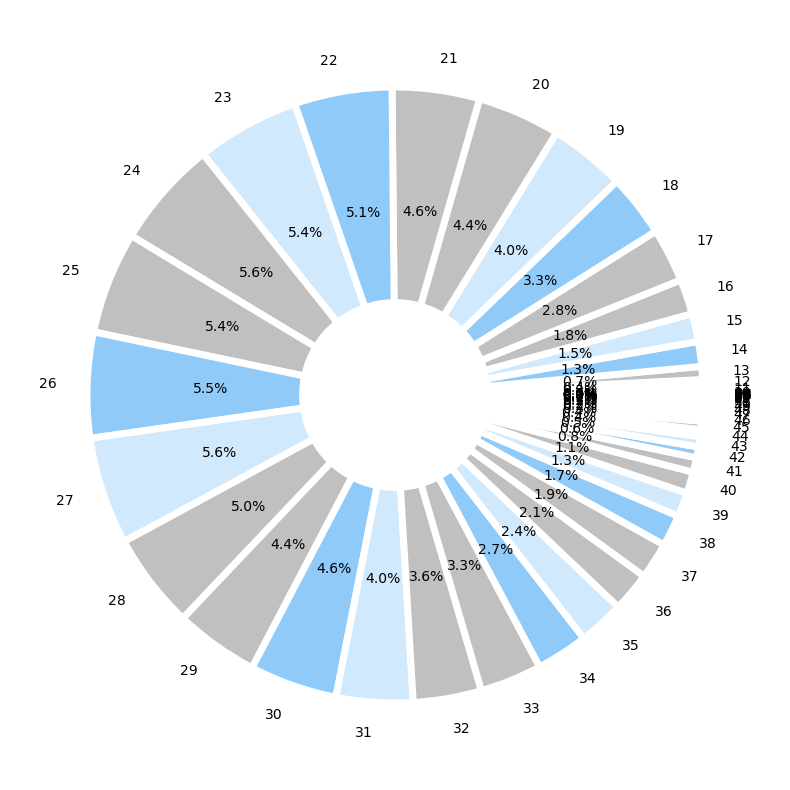

In [288]:
# Define your figure properties and colors
plt.figure(figsize=(10, 10), facecolor='white')
wedgeprops = {'width': 0.7, 'edgecolor': 'w', 'linewidth': 5}
colors = ['#90CAF9', '#D1E9FC', 'silver', 'silver']

# Sort the age values
sorted_ages = cus_tran_merge['adjusted_age'].unique()
sorted_ages.sort()

# Plot the pie chart for sorted ages
plt.pie(cus_tran_merge['adjusted_age'].value_counts().loc[sorted_ages], labels=sorted_ages, autopct='%1.1f%%', colors=colors, wedgeprops=wedgeprops)

# Show the pie chart
plt.show()

In [289]:
# 나이 10/20/30/40대로 표현 
cus_tran_merge['age2'] = cus_tran_merge['age'].apply(lambda x : (x // 10) *10)

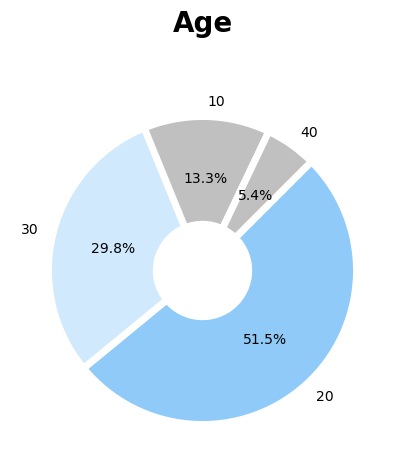

In [290]:
# 나이 10/20/30/40/50이상


plt.figure(figsize=(5,5),facecolor='white')
wedgeprops={'width': 0.7, 'edgecolor': 'w', 'linewidth': 5}
colors = ['#90CAF9','#D1E9FC','silver','silver']
cus_tran_merge[(cus_tran_merge.age2<50) & (cus_tran_merge.age2>0)].age2.value_counts(normalize=True).plot.pie(textprops={'size':10},colors=colors,wedgeprops=wedgeprops,autopct='%.1f%%',counterclock=False,startangle=45)
plt.title('Age',fontsize=20,fontweight='bold',y=1.1)
plt.ylabel('');

10대 13%
20대 51%
30대 29%
40대 5%

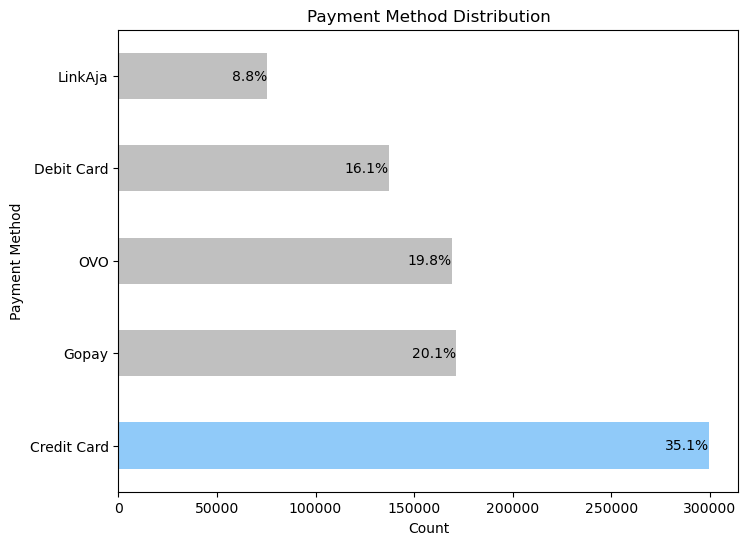

In [291]:

payment_counts = cus_tran_merge.payment_method.value_counts()

# Find the index of the highest count
max_index = payment_counts.idxmax()

# Set different color for the highest count
colors = ['silver' if method != max_index else '#90CAF9' for method in payment_counts.index]

# Plot the horizontal bar chart with color customization
plt.figure(figsize=(8, 6))
payment_counts.plot.barh(color=colors)
plt.xlabel('Count')
plt.ylabel('Payment Method')
plt.title('Payment Method Distribution')

# Add percentage labels
total_count = payment_counts.sum()
for i, count in enumerate(payment_counts):
    percentage = count / total_count * 100
    plt.text(count, i, f'{percentage:.1f}%', ha='right', va='center')

plt.show()

In [292]:
#신용카드로 결제 35%

In [293]:
product =  pd.read_csv('product.csv',on_bad_lines='skip')
product

id gender masterCategory subCategory            articleType  \
0      15970    Men        Apparel     Topwear                 Shirts   
1      39386    Men        Apparel  Bottomwear                  Jeans   
2      59263  Women    Accessories     Watches                Watches   
3      21379    Men        Apparel  Bottomwear            Track Pants   
4      53759    Men        Apparel     Topwear                Tshirts   
...      ...    ...            ...         ...                    ...   
44419  17036    Men       Footwear       Shoes           Casual Shoes   
44420   6461    Men       Footwear  Flip Flops             Flip Flops   
44421  18842    Men        Apparel     Topwear                Tshirts   
44422  46694  Women  Personal Care   Fragrance  Perfume and Body Mist   
44423  51623  Women    Accessories     Watches                Watches   

      baseColour  season    year   usage  \
0      Navy Blue    Fall  2011.0  Casual   
1           Blue  Summer  2012.0  Casual   
2         Silver  Winter  2016.0  Casual   
3          Black    Fall  2011.0  Casual   
4           Grey  Summer  2012.0  Casual   
...          ...     ...     ...     ...   
44419      White  Summer  2013.0  Casual   
44420        Red  Summer  2011.0  Casual   
44421       Blue    Fall  2011.0  Casual   
44422       Blue  Spring  2017.0  Casual   
44423       Pink  Winter  2016.0  Casual   

                                    productDisplayName  
0                     Turtle Check Men Navy Blue Shirt  
1                   Peter England Men Party Blue Jeans  
2                             Titan Women Silver Watch  
3        Manchester United Men Solid Black Track Pants  
4                                Puma Men Grey T-shirt  
...                                                ...  
44419                        Gas Men Caddy Casual Shoe  
44420               Lotto Men's Soccer Track Flip Flop  
44421             Puma Men Graphic Stellar Blue Tshirt  
44422                   Rasasi Women Blue Lady Perfume  
44423  Fossil Women Pink Dial Chronograph Watch ES3050  

[44424 rows x 10 columns]

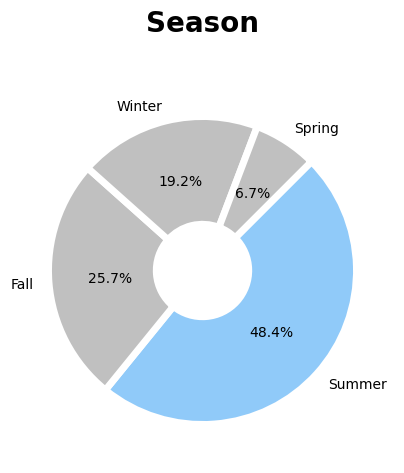

In [294]:
plt.figure(figsize=(5,5),facecolor='white')
colors = ['#90CAF9','silver','silver','silver']
wedgeprops={'width': 0.7, 'edgecolor': 'w', 'linewidth': 5}
product.season.value_counts(normalize=True).plot.pie(textprops={'size':10},colors=colors,wedgeprops=wedgeprops,autopct='%.1f%%',counterclock=False,startangle=45)
plt.title('Season',fontsize=20,fontweight='bold',y=1.1)
plt.ylabel('');

인도네시아의 계절은 크게 상관없을 듯 --( 건기/ 우기)

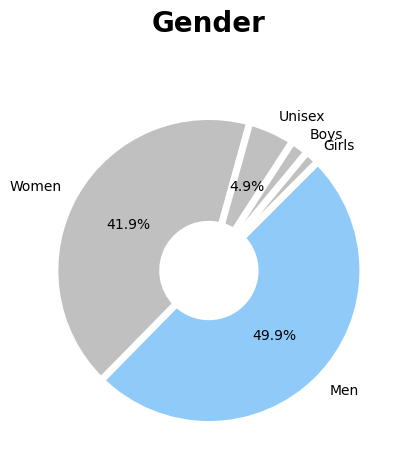

In [295]:
plt.figure(figsize=(5,5),facecolor='white')
# colors = ['#FF8A65','#BCAAA4','#BDBDBD','#FFF59D']
wedgeprops={'width': 0.7, 'edgecolor': 'w', 'linewidth': 5}
colors = ['#90CAF9','silver','silver','silver','silver']
def my_autopct(pct):
    return f'{pct:.1f}%' if pct >= 4 else ''
product.gender.value_counts(normalize=True).plot.pie(textprops={'size':10},colors=colors,wedgeprops=wedgeprops,autopct=my_autopct,counterclock=False,startangle=45)
plt.title('Gender',fontsize=20,fontweight='bold',y=1.1)
plt.ylabel('');

In [296]:
# 이용률은 여자가 높으나, 카테고리에 남자 비율 높음 -- 

# 여자들이 남편 또는 남자친구 옷을 사줘서 그런 것 같다는 개인적인 생각이 든다 

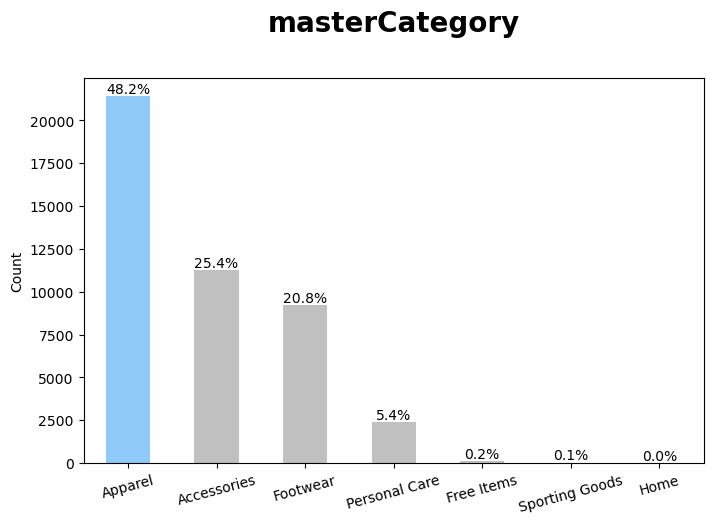

In [297]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5), facecolor='white')

subCategory_counts = product.masterCategory.value_counts()

colors = ['#90CAF9'] + ['silver'] * 8

subCategory_counts.plot.bar(color=colors)
plt.title('masterCategory', fontsize=20, fontweight='bold', y=1.1)
plt.xticks(rotation=15)
plt.ylabel('Count')
total_count = subCategory_counts.sum()
for i, count in enumerate(subCategory_counts):
    percentage = count / total_count * 100
    plt.text(i, count, f'{percentage:.1f}%', ha='center', va='bottom')


plt.show()

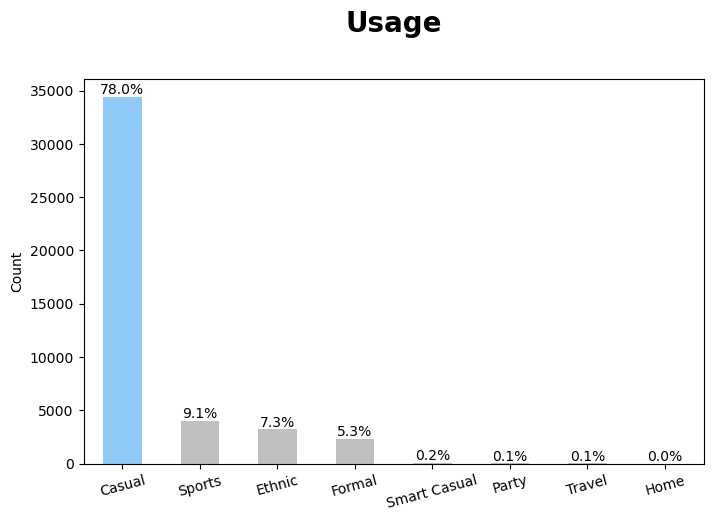

In [298]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5), facecolor='white')

usage_counts = product.usage.value_counts()

colors = ['#90CAF9'] + ['silver'] * 8

usage_counts.plot.bar(color=colors)
plt.title('Usage', fontsize=20, fontweight='bold', y=1.1)
plt.xticks(rotation=15)
plt.ylabel('Count')

total_count = usage_counts.sum()
for i, count in enumerate(usage_counts):
    percentage = count / total_count * 100
    plt.text(i, count, f'{percentage:.1f}%', ha='center', va='bottom')

캐쥬얼 대부분 차지

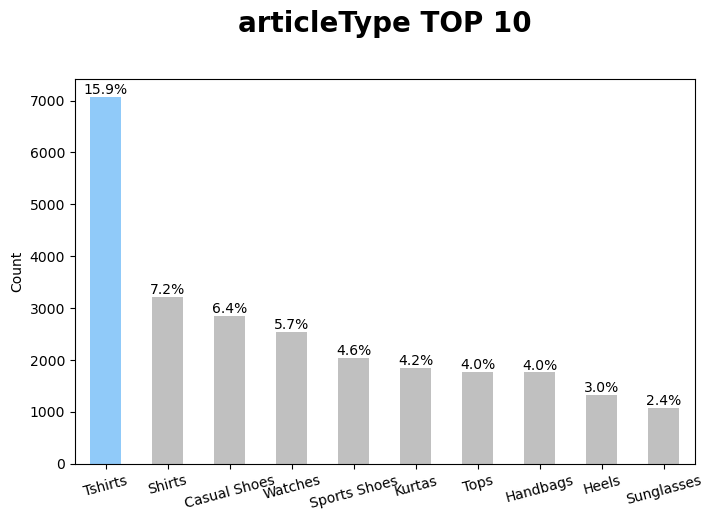

In [299]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5), facecolor='white')

articleType_counts = product.articleType.value_counts().head(10)

colors = ['#90CAF9'] + ['silver'] * 9

articleType_counts.plot.bar(color=colors)
plt.title('articleType TOP 10', fontsize=20, fontweight='bold', y=1.1)
plt.xticks(rotation=15)
plt.ylabel('Count')
articleType_counts = product.articleType.value_counts()
total_count = articleType_counts.sum()
for i, count in enumerate(articleType_counts):
    percentage = count / total_count * 100
    plt.text(i, count, f'{percentage:.1f}%', ha='center', va='bottom')
    if i==9:
        break

plt.show()

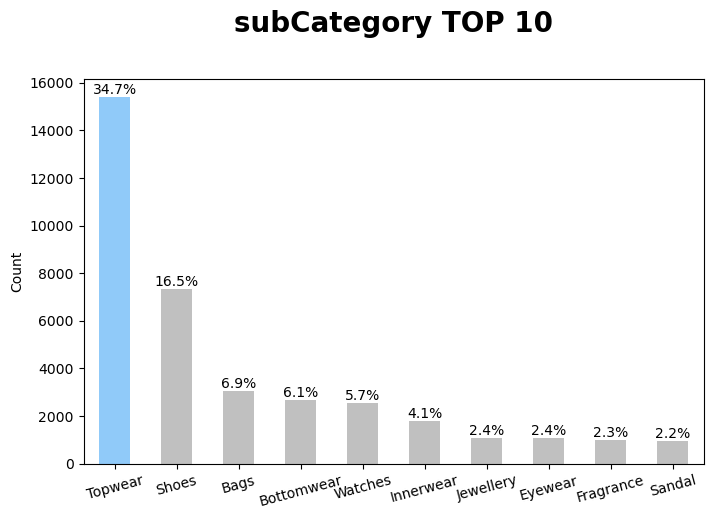

In [300]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5), facecolor='white')

articleType_counts = product.subCategory.value_counts().head(10)

colors = ['#90CAF9'] + ['silver'] * 9

articleType_counts.plot.bar(color=colors)
plt.title('subCategory TOP 10', fontsize=20, fontweight='bold', y=1.1)
plt.xticks(rotation=15)
plt.ylabel('Count')
articleType_counts = product.subCategory.value_counts()
total_count = articleType_counts.sum()
for i, count in enumerate(articleType_counts):
    percentage = count / total_count * 100
    plt.text(i, count, f'{percentage:.1f}%', ha='center', va='bottom')
    if i==9:
        break

plt.show()

상의 - 신발 - 가방 순으로 많음 

In [301]:
# 최근 2년 기준으로 다 알아보기
tranfinal_cus = cus_tran_merge[cus_tran_merge.created_at.notnull()]
tranfinal_cus['created_at'] = pd.to_datetime(tranfinal_cus['created_at'])  # 데이터 타입을 datetime으로 변환
tranfinal_cus['created_at_3'] = tranfinal_cus['created_at'].dt.strftime('%Y-%m-%d')
tranfinal_cus = tranfinal_cus[tranfinal_cus.created_at_3 > '2020-08-01']
tranfinal_cus.head()

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_18556\1174126546.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tranfinal_cus['created_at'] = pd.to_datetime(tranfinal_cus['created_at'])  # 데이터 타입을 datetime으로 변환
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_18556\1174126546.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tranfinal_cus['created_at_3'] = tranfinal_cus['created_at'].dt.strftime('%Y-%m-%d')


created_at  customer_id  promo_amount  shipment_fee  total_amount  \
2 2020-08-23 12:53:00         7279        2853.0       15000.0      844751.0   
3 2020-08-31 13:34:00         7279           0.0       10000.0      391341.0   
4 2020-09-08 13:38:00         7279           0.0           0.0      154220.0   
5 2020-09-16 13:48:00         7279           0.0       10000.0      412502.0   
6 2020-09-24 13:32:00         7279           0.0       10000.0      406435.0   

   quantity shipment_period                            booking_id  \
2       3.0 2 days 16:21:00  1fb6f149-05ef-4a22-ac1a-cd5d98cd5510   
3       1.0 3 days 16:15:00  eed52035-1f80-422c-b0ac-a1c814e77bcf   
4       1.0 5 days 21:48:00  af568d06-c819-4ab4-a3e8-06857786ba10   
5       2.0 3 days 08:50:00  d8c8337c-ef09-4ed3-801a-3e5fd22c3d8d   
6       2.0 2 days 07:12:00  1a9d2de2-8c8c-43f3-8ccb-9fbba08ea6e1   

                             session_id   promo_code  ... first_join_date  \
2  9d0496a6-37f7-4d0a-8a04-5850a12d00a6  WEEKENDSERU  ...      2020-08-23   
3  82396d8d-7d8a-436d-8e14-75f24aa35faa      Nopromo  ...      2020-08-23   
4  348cc997-480b-467e-a502-1eed0f611e9d      Nopromo  ...      2020-08-23   
5  70d1c010-60e4-440a-80df-9efb0132cfb7      Nopromo  ...      2020-08-23   
6  a083d201-314b-4b5d-9b12-0f2b6010846d      Nopromo  ...      2020-08-23   

  join_date join_month join_day join_year created_at_3 period_enrollment age  \
2   2020-08         08       23      2020   2020-08-23               0.0  34   
3   2020-08         08       23      2020   2020-08-31               8.0  34   
4   2020-08         08       23      2020   2020-09-08              16.0  34   
5   2020-08         08       23      2020   2020-09-16              24.0  34   
6   2020-08         08       23      2020   2020-09-24              32.0  34   

  adjusted_age age2  
2           33   30  
3           33   30  
4           33   30  
5           33   30  
6           33   30  

[5 rows x 37 columns]

In [302]:
tranfinal_cus.promo_yesno.value_counts(normalize=True)

x    0.650308
o    0.349692
Name: promo_yesno, dtype: float64

최근 2년 

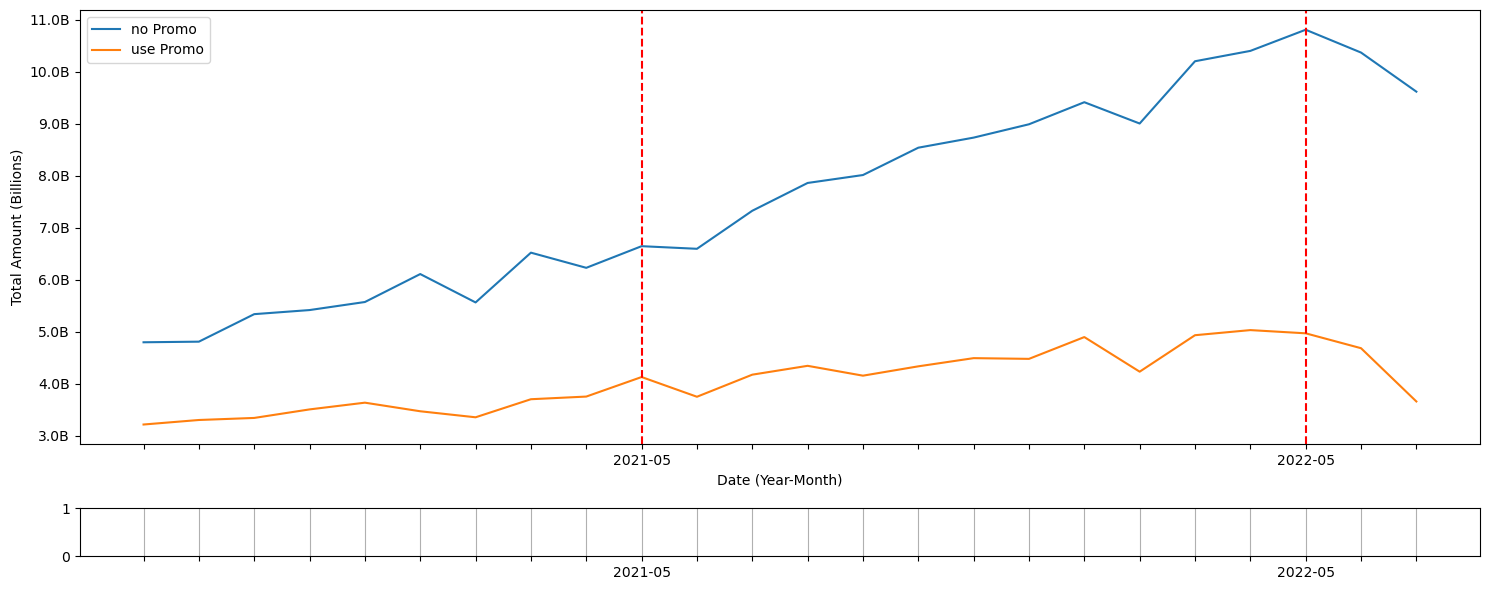

In [303]:
# 날짜별 프로모션 적용여부에 따른 매출
import matplotlib.gridspec as gridspec
import matplotlib.ticker as ticker


plt.figure(figsize=(15, 6))

# GridSpec을 사용하여 그래프와 실눈을 함께 그리기
gs = gridspec.GridSpec(2, 1, height_ratios=[0.9, 0.1])
ax = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1], sharex=ax)

# ax1 lineplot
tmp = tranfinal_cus[tranfinal_cus.payment_status=='Success']
tran_success_g = tmp.groupby(['created_at_2', 'promo_yesno'])['total_amount'].sum().reset_index()
sns.lineplot(data=tran_success_g, x='created_at_2', y='total_amount', hue='promo_yesno', hue_order = ['x', 'o'], ax = ax)

# ax1 y축 값 포맷 변경
def format_y_axis_label(value, _):
    return f'{value/1e9:.1f}B'


ax.get_yaxis().get_major_formatter().set_scientific(False)
ax.yaxis.set_major_formatter(ticker.FuncFormatter(format_y_axis_label))
ax.set_ylabel('Total Amount (Billions)')

# ax1 범례 수정
new_labels = ['no Promo', 'use Promo']
handles, _ = ax.get_legend_handles_labels()
ax.legend(handles, new_labels)

# ax2 x축 레이블 변경
xticklabels = tran_success_g['created_at_2'].unique()
x_values = [label if label.endswith('-05') else '' for label in xticklabels]
plt.xticks(range(len(xticklabels)), x_values, ha='center')
ax.set_xlabel('Date (Year-Month)')

# ax1 6월에 해당하는 부분에 선 추가
for i, label in enumerate(xticklabels):
    if label.endswith('-05'):
        ax.axvline(i, color='red', linestyle='--')
        
# ax2 실눈 설정
ax2.grid(True, axis='x')

plt.tight_layout()
plt.show()

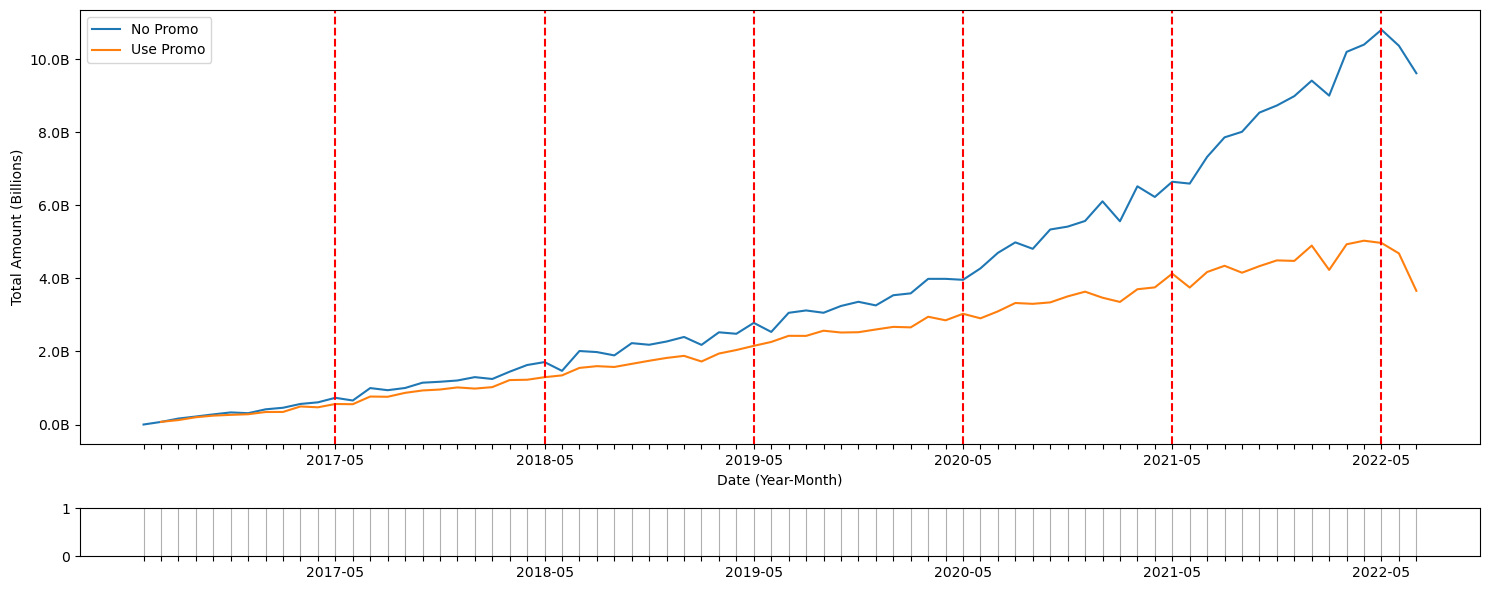

In [304]:
# 날짜별 프로모션 적용여부에 따른 매출
import matplotlib.gridspec as gridspec

plt.figure(figsize=(15, 6))

# GridSpec을 사용하여 그래프와 실눈을 함께 그리기
gs = gridspec.GridSpec(2, 1, height_ratios=[0.9, 0.1])
ax = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1], sharex=ax)

# ax1 lineplot
tmp = cus_tran_merge[cus_tran_merge.payment_status=='Success']
tran_success_g = tmp.groupby(['created_at_2', 'promo_yesno'])['total_amount'].sum().reset_index()
sns.lineplot(data=tran_success_g, x='created_at_2', y='total_amount', hue='promo_yesno', hue_order = ['x', 'o'], ax = ax)

# x축 레이블 변경
xticklabels = tran_success_g['created_at_2'].unique()
x_values = [label if label.endswith('-05') else '' for label in xticklabels]
plt.xticks(range(len(xticklabels)), x_values, ha='center')
ax.set_xlabel('Date (Year-Month)')

# ax1 y축 값 포맷 변경- 빌리언
ax.get_yaxis().get_major_formatter().set_scientific(False)
ax.yaxis.set_major_formatter(ticker.FuncFormatter(format_y_axis_label))
ax.set_ylabel('Total Amount (Billions)')

# 6월에 해당하는 부분에 선 추가
for i, label in enumerate(xticklabels):
    if label.endswith('-05'):
        ax.axvline(i, color='red', linestyle='--')

# 실눈 설정
ax2.grid(True, axis='x')

new_labels = ['No Promo', 'Use Promo']
handles, _ = ax.get_legend_handles_labels()
ax.legend(handles, new_labels)

plt.tight_layout()
plt.show()


In [305]:
tmp1=tmp.groupby(['created_at_2'])['total_amount'].sum().reset_index()
tmp1['amount_difference'] = (tmp1['total_amount'].diff().shift(-1))
tmp1['percent'] = (tmp1['amount_difference']/tmp1['total_amount']*100).shift()
tmp1['percent'].min()

-11.796223304480474

In [306]:
(15776684223.00-15051883083.00)/15776684223.00

0.04594128460423581

In [307]:
((9629733539.00+3664976026.00)-(4970217464.00+10806466759.00))/(4970217464.00+10806466759.00)   # 전체 매출에서 5월대비 7월 매출 감소율 15%


-0.15731915673267133

In [308]:
cus_tran_merge.head()

created_at  customer_id  promo_amount  shipment_fee  total_amount  \
0                 NaT         2870           NaN           NaN           NaN   
1                 NaT         8193           NaN           NaN           NaN   
2 2020-08-23 12:53:00         7279        2853.0       15000.0      844751.0   
3 2020-08-31 13:34:00         7279           0.0       10000.0      391341.0   
4 2020-09-08 13:38:00         7279           0.0           0.0      154220.0   

   quantity shipment_period                            booking_id  \
0       NaN             NaT                                   NaN   
1       NaN             NaT                                   NaN   
2       3.0 2 days 16:21:00  1fb6f149-05ef-4a22-ac1a-cd5d98cd5510   
3       1.0 3 days 16:15:00  eed52035-1f80-422c-b0ac-a1c814e77bcf   
4       1.0 5 days 21:48:00  af568d06-c819-4ab4-a3e8-06857786ba10   

                             session_id   promo_code  ... first_join_date  \
0                                   NaN          NaN  ...      2019-07-21   
1                                   NaN          NaN  ...      2017-07-16   
2  9d0496a6-37f7-4d0a-8a04-5850a12d00a6  WEEKENDSERU  ...      2020-08-23   
3  82396d8d-7d8a-436d-8e14-75f24aa35faa      Nopromo  ...      2020-08-23   
4  348cc997-480b-467e-a502-1eed0f611e9d      Nopromo  ...      2020-08-23   

  join_date join_month join_day join_year created_at_3 period_enrollment age  \
0   2019-07         07       21      2019          NaN              -1.0  27   
1   2017-07         07       16      2017          NaN              -1.0  30   
2   2020-08         08       23      2020   2020-08-23               0.0  34   
3   2020-08         08       23      2020   2020-08-31               8.0  34   
4   2020-08         08       23      2020   2020-09-08              16.0  34   

  adjusted_age age2  
0           26   20  
1           29   30  
2           33   30  
3           33   30  
4           33   30  

[5 rows x 37 columns]

최근 2년 

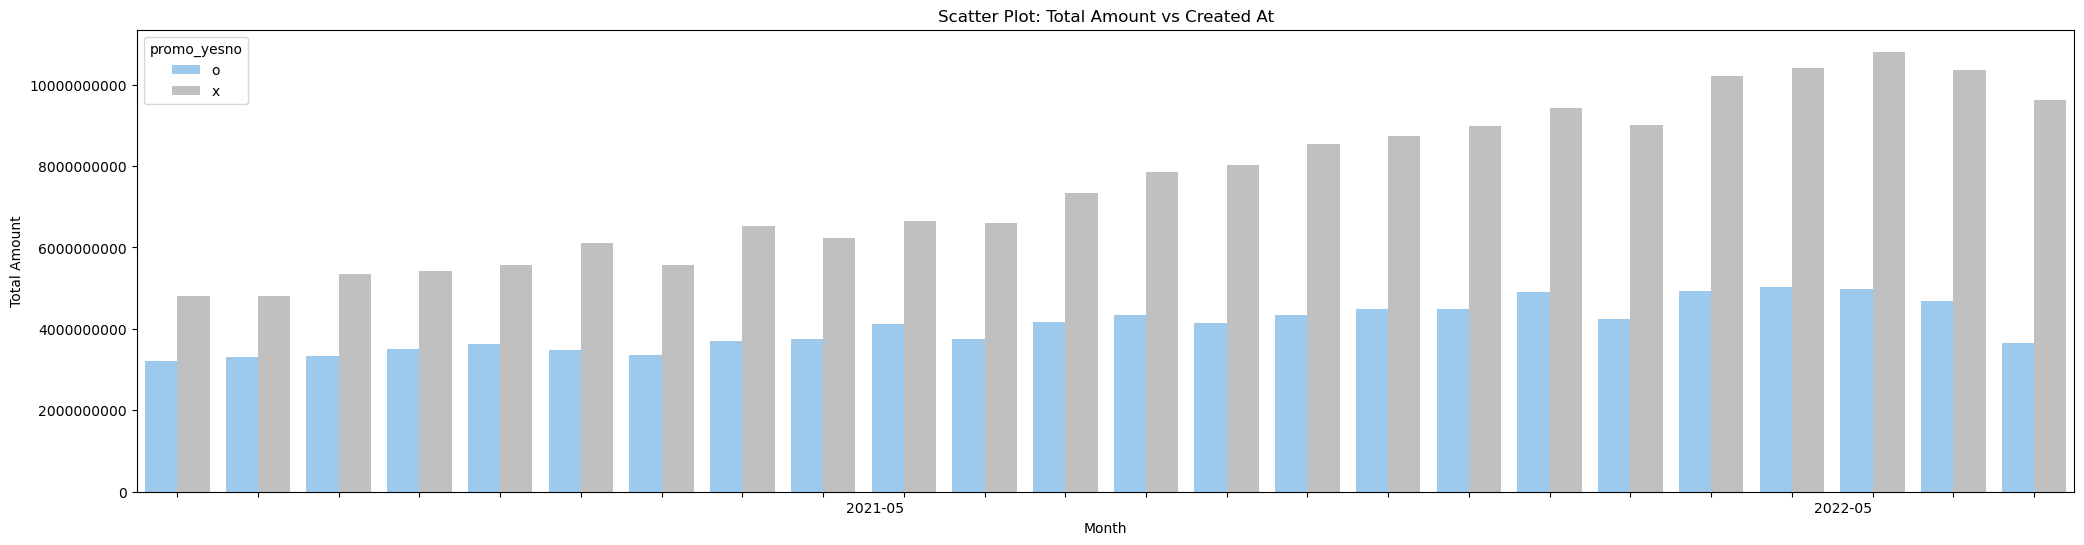

In [309]:
tmp = tranfinal_cus[tranfinal_cus.payment_status == 'Success'].groupby(['created_at_2', 'promo_yesno'])['total_amount'].sum().reset_index()

plt.figure(figsize=(25, 6))
colors = {'o': '#90CAF9', 'x': 'silver'}

sns.barplot(data=tmp, x='created_at_2', y='total_amount', hue='promo_yesno', palette=colors)

# Filter and format x-axis labels
xticklabels = tmp['created_at_2'].unique()
x_values = [label if label.endswith('-05') else '' for label in xticklabels]
x_positions = range(len(xticklabels))
plt.xticks(x_positions, x_values, rotation=0, ha='right')

plt.xlabel('Month')
plt.ylabel('Total Amount')
plt.title('Scatter Plot: Total Amount vs Created At')

# Display y-axis labels as actual numbers
plt.ticklabel_format(style='plain', axis='y')

plt.show()

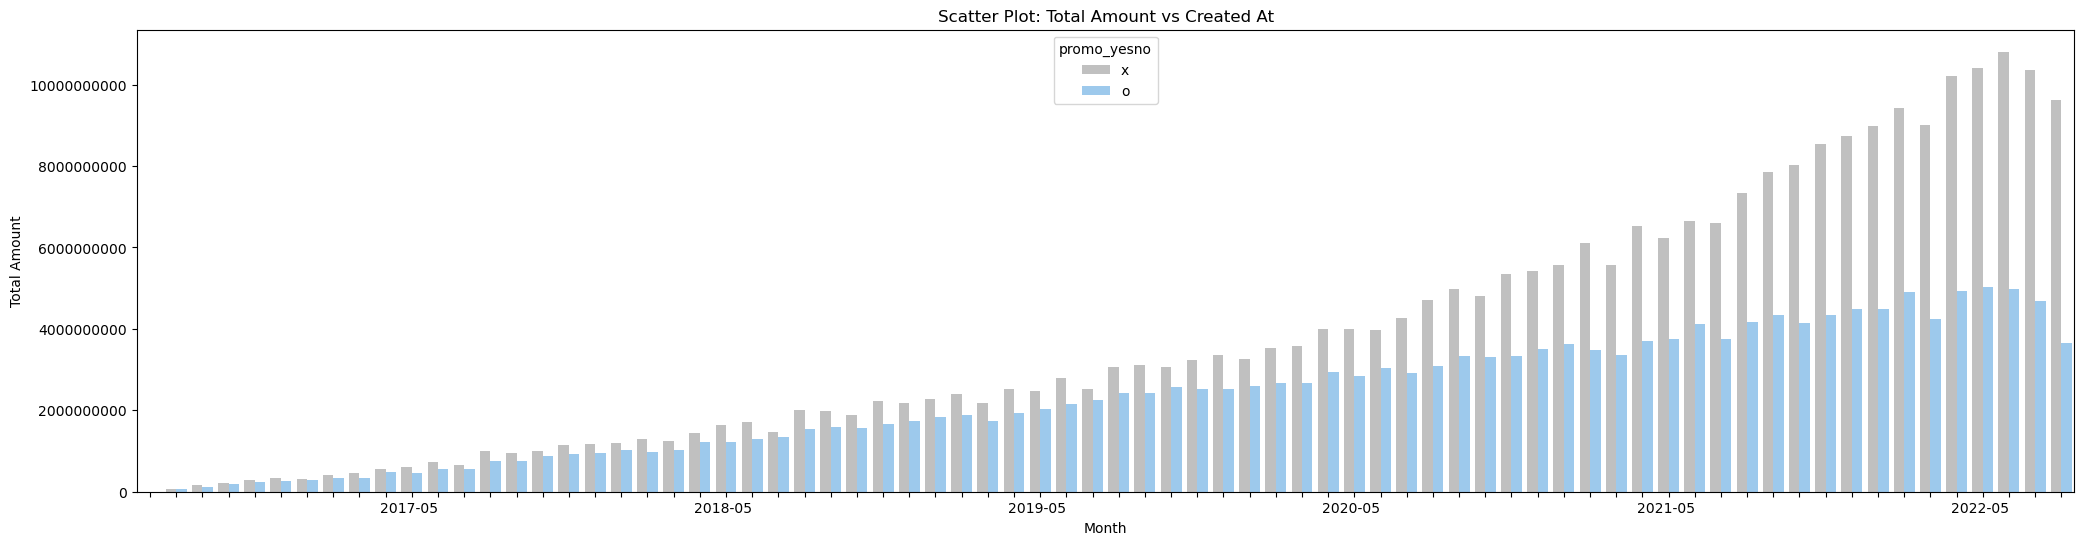

In [310]:
tmp = cus_tran_merge[cus_tran_merge.payment_status == 'Success'].groupby(['created_at_2', 'promo_yesno'])['total_amount'].sum().reset_index()

plt.figure(figsize=(25, 6))
colors = {'o': '#90CAF9', 'x': 'silver'}

sns.barplot(data=tmp, x='created_at_2', y='total_amount', hue='promo_yesno', palette=colors)

# Filter and format x-axis labels
xticklabels = tmp['created_at_2'].unique()
x_values = [label if label.endswith('-05') else '' for label in xticklabels]
x_positions = range(len(xticklabels))
plt.xticks(x_positions, x_values, rotation=0, ha='right')

plt.xlabel('Month')
plt.ylabel('Total Amount')
plt.title('Scatter Plot: Total Amount vs Created At')

# Display y-axis labels as actual numbers
plt.ticklabel_format(style='plain', axis='y')

plt.show()

In [311]:
(15051883083.00-13294709565)/15051883083.00*100

11.674110862478058

In [312]:

tranfinal_cus.promo_amount.describe()

count    531748.000000
mean       1866.591865
std        2987.807382
min           0.000000
25%           0.000000
50%           0.000000
75%        3650.000000
max       24519.000000
Name: promo_amount, dtype: float64

<Axes: xlabel='shipment_fee', ylabel='total_amount'>

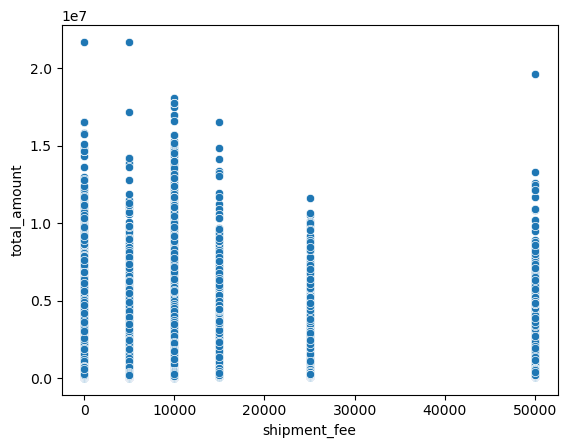

In [313]:
sns.scatterplot(data=tranfinal_cus, x='shipment_fee',y='total_amount')

최근 2년 

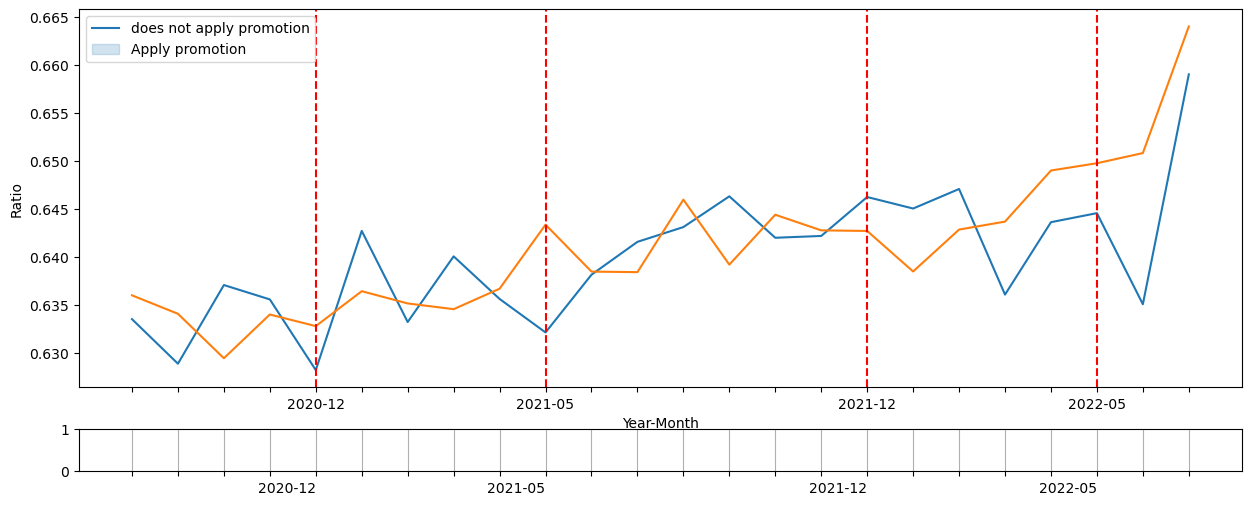

In [314]:
plt.figure(figsize=(15, 6))

# GridSpec을 사용하여 그래프와 실눈을 함께 그리기
gs = gridspec.GridSpec(2, 1, height_ratios=[0.9, 0.1])
ax = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1], sharex=ax)

# 날짜별 프로모션 적용 여부에 따른 남녀 비율 구하기
tran_success_g = tranfinal_cus.groupby(['created_at_2', 'promo_yesno', 'gender'])['gender'].count().unstack().reset_index()
tran_success_g['Total'] = tran_success_g[['F', 'M']].sum(axis=1)
tran_success_g['Female Ratio'] = tran_success_g['F'] / tran_success_g['Total']
tran_success_g['Male Ratio'] = tran_success_g['M'] / tran_success_g['Total']

# 날짜별 프로모션 적용 여부에 따른 여성 비율 그래프 그리기
sns.lineplot(data=tran_success_g, x='created_at_2', y='Female Ratio', hue='promo_yesno', ax=ax)


# x축 레이블 변경
xticklabels = tran_success_g['created_at_2'].unique()
x_values = [label if label.endswith('-12') or label.endswith('-05')  else '' for label in xticklabels]
plt.xticks(range(len(xticklabels)), x_values, ha='right')

ax.set_xlabel('Year-Month')

# y축 값 포맷 변경
ax.set_ylabel('Ratio')

# 6월에 해당하는 부분에 선 추가
for i, label in enumerate(xticklabels):
    if label.endswith('-12') or label.endswith('-05'):
        ax.axvline(i, color='red', linestyle='--')

# 실눈 설정
ax2.grid(True, axis='x')

# 범례 수정
ax.legend(['does not apply promotion', 'Apply promotion'], loc='best')

plt.show()

# 여성 기준의 그래프이고, 반대가 남자.

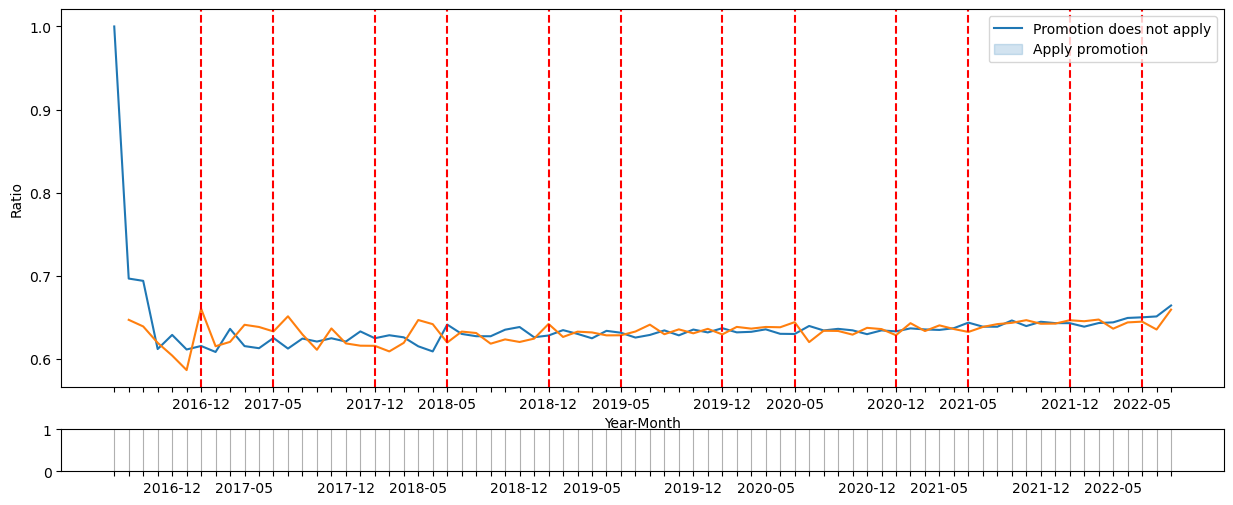

In [315]:
plt.figure(figsize=(15, 6))

# GridSpec을 사용하여 그래프와 실눈을 함께 그리기
gs = gridspec.GridSpec(2, 1, height_ratios=[0.9, 0.1])
ax = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1], sharex=ax)

# 날짜별 프로모션 적용 여부에 따른 남녀 비율 구하기
tran_success_g = cus_tran_merge.groupby(['created_at_2', 'promo_yesno', 'gender'])['gender'].count().unstack().reset_index()
tran_success_g['Total'] = tran_success_g[['F', 'M']].sum(axis=1)
tran_success_g['Female Ratio'] = tran_success_g['F'] / tran_success_g['Total']
tran_success_g['Male Ratio'] = tran_success_g['M'] / tran_success_g['Total']

# 날짜별 프로모션 적용 여부에 따른 여성 비율 그래프 그리기
sns.lineplot(data=tran_success_g, x='created_at_2', y='Female Ratio', hue='promo_yesno', ax=ax)


# x축 레이블 변경
xticklabels = tran_success_g['created_at_2'].unique()
x_values = [label if label.endswith('-12') or label.endswith('-05')  else '' for label in xticklabels]
plt.xticks(range(len(xticklabels)), x_values, ha='right')

ax.set_xlabel('Year-Month')

# y축 값 포맷 변경
ax.set_ylabel('Ratio')

# 6월에 해당하는 부분에 선 추가
for i, label in enumerate(xticklabels):
    if label.endswith('-12') or label.endswith('-05'):
        ax.axvline(i, color='red', linestyle='--')

# 실눈 설정
ax2.grid(True, axis='x')

# 범례 수정
ax.legend(['Promotion does not apply', 'Apply promotion'], loc='best')

plt.show()

# 여성 기준의 그래프이고, 반대가 남자.

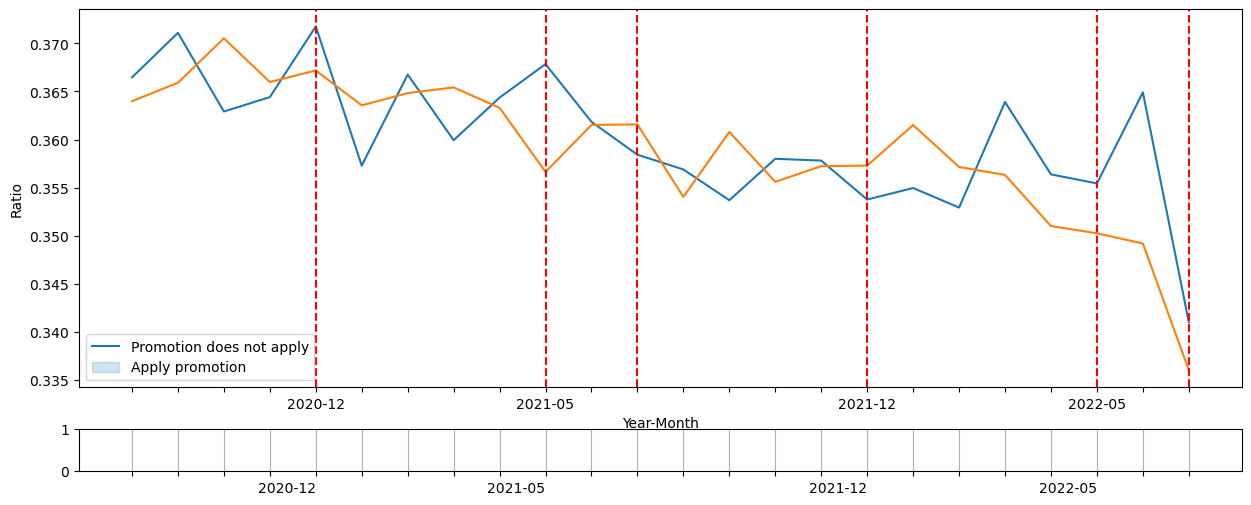

In [316]:
plt.figure(figsize=(15, 6))

# GridSpec을 사용하여 그래프와 실눈을 함께 그리기
gs = gridspec.GridSpec(2, 1, height_ratios=[0.9, 0.1])
ax = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1], sharex=ax)

# 날짜별 프로모션 적용 여부에 따른 남녀 비율 구하기
tran_success_g = tranfinal_cus.groupby(['created_at_2', 'promo_yesno', 'gender'])['gender'].count().unstack().reset_index()
tran_success_g['Total'] = tran_success_g[['F', 'M']].sum(axis=1)
tran_success_g['Female Ratio'] = tran_success_g['F'] / tran_success_g['Total']
tran_success_g['Male Ratio'] = tran_success_g['M'] / tran_success_g['Total']

# 날짜별 프로모션 적용 여부에 따른 여성 비율 그래프 그리기
sns.lineplot(data=tran_success_g, x='created_at_2', y='Male Ratio', hue='promo_yesno', ax=ax)


# x축 레이블 변경
xticklabels = tran_success_g['created_at_2'].unique()
x_values = [label if label.endswith('-12') or label.endswith('-05') else '' for label in xticklabels]
plt.xticks(range(len(xticklabels)), x_values, ha='right')

ax.set_xlabel('Year-Month')

# y축 값 포맷 변경
ax.set_ylabel('Ratio')

# 6월에 해당하는 부분에 선 추가
for i, label in enumerate(xticklabels):
    if label.endswith('-12') or label.endswith('-05') or label.endswith('-07'):
        ax.axvline(i, color='red', linestyle='--')

# 실눈 설정
ax2.grid(True, axis='x')

# 범례 수정
ax.legend(['Promotion does not apply', 'Apply promotion'], loc='best')

plt.show()

In [317]:
cus_tran_merge.describe()

customer_id   promo_amount   shipment_fee  total_amount  \
count  901822.000000  852527.000000  852527.000000  8.525270e+05   
mean    49856.248715    2042.196634    9189.902490  5.499301e+05   
std     28985.949938    3063.538307    9378.026087  8.153986e+05   
min         1.000000       0.000000       0.000000  1.089800e+04   
25%     24594.000000       0.000000       0.000000  2.037945e+05   
50%     49667.000000       0.000000   10000.000000  3.029940e+05   
75%     74964.000000    3994.000000   10000.000000  5.147085e+05   
max    100000.000000   24519.000000   50000.000000  2.350449e+07   

            quantity            shipment_period  home_location_lat  \
count  852527.000000                     852527      901822.000000   
mean        2.170810  3 days 12:27:41.553381887          -5.104379   
std         3.040723  1 days 10:42:03.070950725           3.094118   
min         1.000000            1 days 00:00:00         -10.845002   
25%         1.000000            2 days 06:09:00          -7.380696   
50%         1.000000            3 days 12:28:00          -6.242461   
75%         2.000000            4 days 18:39:00          -3.062878   
max        84.000000            6 days 01:00:00           5.818355   

       home_location_long  period_enrollment            age   adjusted_age  \
count       901822.000000      901822.000000  901822.000000  901822.000000   
mean           110.938984         559.700668      27.402707      26.718736   
std              6.408566         500.388874       7.285959       7.317949   
min             95.275319          -1.000000       7.000000       6.000000   
25%            106.860578         136.000000      22.000000      21.000000   
50%            110.158946         432.000000      27.000000      26.000000   
75%            113.192923         881.000000      32.000000      31.000000   
max            140.993119        2217.000000      69.000000      68.000000   

                age2  
count  901822.000000  
mean       22.876355  
std         7.830212  
min         0.000000  
25%        20.000000  
50%        20.000000  
75%        30.000000  
max        60.000000

In [318]:
# 주문을 성공한 경우 프로모션 적용. 비적용에 따른 남녀 비율
tranfinal_cus_notnull = cus_tran_merge[(cus_tran_merge.payment_status=='Success')].reset_index(drop=True)
tranfinal_cus_notnull_1 = tranfinal_cus_notnull[tranfinal_cus_notnull.promo_yesno=='o'].groupby(['created_at_2','gender']).count()['session_id'].reset_index()
tranfinal_cus_notnull_1_no = tranfinal_cus_notnull[tranfinal_cus_notnull.promo_yesno=='x'].groupby(['created_at_2','gender']).count()['booking_id'].reset_index()


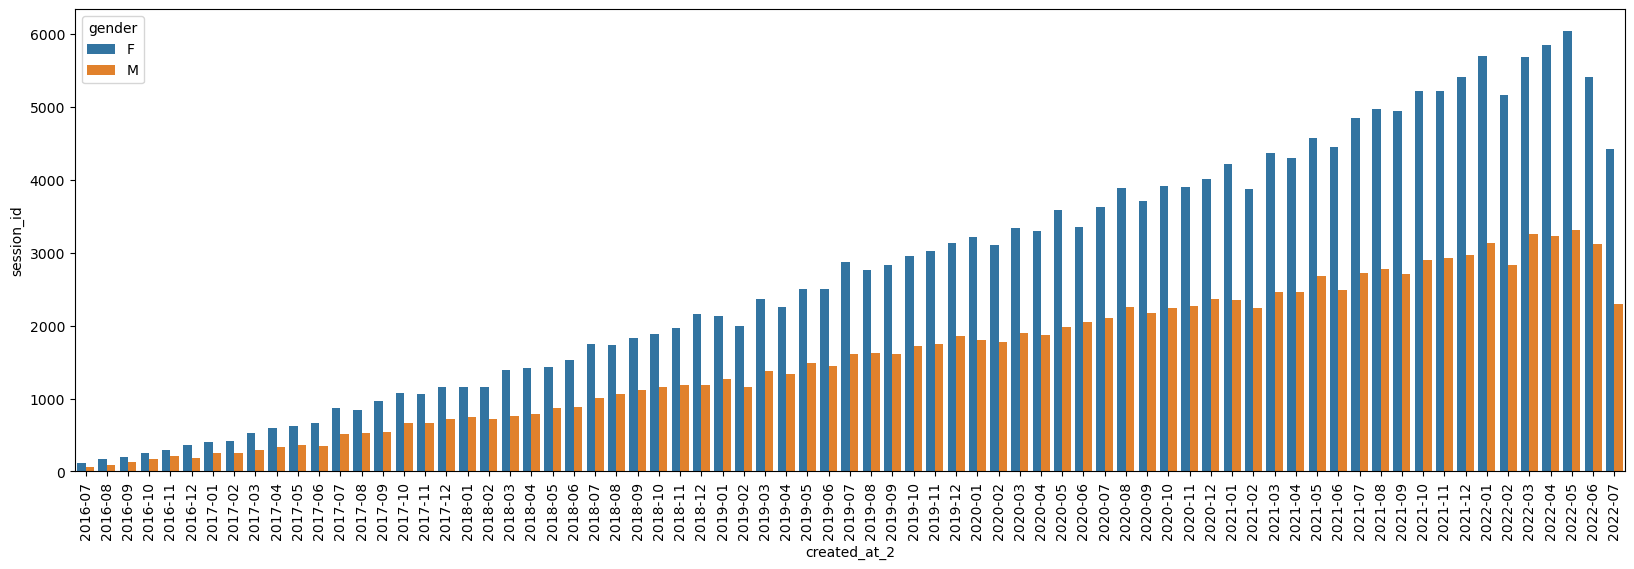

In [319]:

# 프로모션 사용한 남녀
plt.figure(figsize=(20, 6))
sns.barplot(x=tranfinal_cus_notnull_1.created_at_2,y=tranfinal_cus_notnull_1.session_id,hue=tranfinal_cus_notnull_1.gender)
plt.xticks(rotation=90);

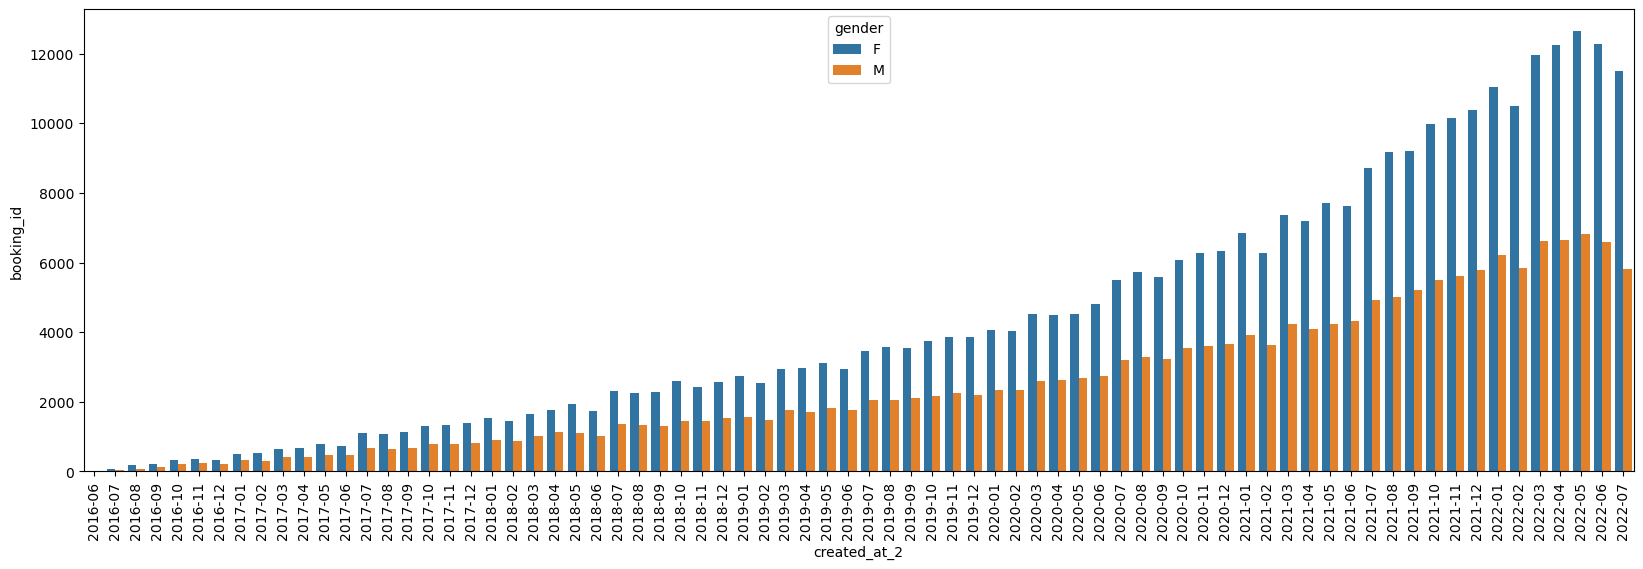

In [320]:
# 프로모션 사용하지 않은 남녀 
plt.figure(figsize=(20, 6))
sns.barplot(x=tranfinal_cus_notnull_1_no.created_at_2,y=tranfinal_cus_notnull_1_no.booking_id,hue=tranfinal_cus_notnull_1_no.gender)
plt.xticks(rotation=90);

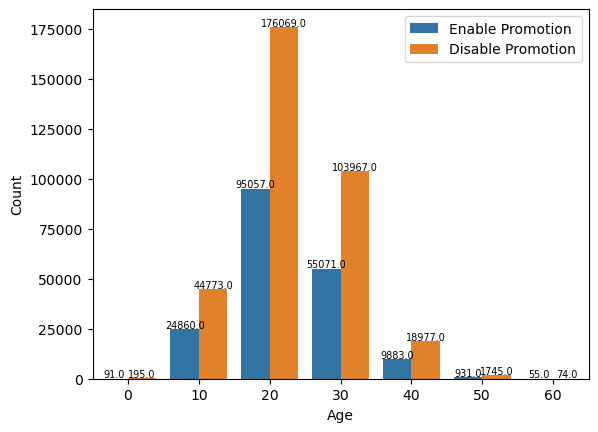

In [321]:
NA = sns.countplot(data=tranfinal_cus, x='age2',hue='promo_yesno')
plt.legend(['Enable Promotion','Disable Promotion'])
plt.xlabel('Age')
plt.ylabel('Count')
for patch in NA.patches:
    plt.text(x=patch.get_x() + patch.get_width()/2 ,y=patch.get_height() + len(tranfinal_cus)*0.001,s=patch.get_height(), ha='center',size=7)


In [322]:
cus_tran_merge.period_enrollment


0          -1.0
1          -1.0
2           0.0
3           8.0
4          16.0
          ...  
901817    143.0
901818    190.0
901819    237.0
901820    284.0
901821    331.0
Name: period_enrollment, Length: 901822, dtype: float64

In [323]:
tranfinal_cus_1 = cus_tran_merge[cus_tran_merge.created_at.notnull()].sort_values(['first_join_date', 'created_at'])
tranfinal_cus_1 = tranfinal_cus_1.groupby('customer_id').agg({
    'first_join_date': 'first',
    'created_at': 'first',
    'promo_yesno': 'first',
    'quantity': 'first',
    'period_enrollment': 'first',  # Use the correct column name here
    'payment_status': [('payment_status_success', lambda x: (x == 'Success').sum()),
                       ('payment_status_fail', lambda x: (x == 'Failed').sum()),
                       'first']
}).reset_index()
tranfinal_cus_1.columns = [f'{x[0]}_{x[1]}' if x[1] != '' else x[0] for x in tranfinal_cus_1.columns]
tranfinal_cus_1.head()

customer_id first_join_date_first    created_at_first promo_yesno_first  \
0            3            2018-08-25 2018-08-25 18:54:00                 o   
1            8            2021-02-13 2021-02-13 09:47:00                 o   
2            9            2021-06-26 2021-06-27 01:51:00                 x   
3           11            2022-03-06 2022-03-07 14:29:00                 o   
4           15            2019-09-28 2019-09-30 04:47:00                 x   

   quantity_first  period_enrollment_first  \
0             5.0                      0.0   
1             1.0                      0.0   
2             2.0                      1.0   
3             1.0                      1.0   
4             5.0                      2.0   

   payment_status_payment_status_success  payment_status_payment_status_fail  \
0                                     49                                   2   
1                                      7                                   0   
2                                      6                                   0   
3                                      1                                   0   
4                                      5                                   0   

  payment_status_first  
0              Success  
1              Success  
2              Success  
3              Success  
4              Success

In [324]:
tranfinal_cus_1['first_join_date_first2'] = tranfinal_cus_1['first_join_date_first'].dt.strftime('%Y-%m')


In [325]:
test1 = tranfinal_cus_1[(tranfinal_cus_1['period_enrollment_first']==0)&(tranfinal_cus_1['payment_status_first']=='Success')]


In [326]:
# 신규가입자중 당일구매하는 비율
test1.shape[0]/df_customer.shape[0]

0.224

In [327]:
test2 = tranfinal_cus_1[(tranfinal_cus_1['payment_status_first']=='Success')]
test2['period_enrollment_first'].value_counts()

0.0     22400
1.0     14958
2.0      5384
3.0      2652
4.0      1352
5.0       738
6.0       438
7.0       224
8.0       153
9.0        67
10.0       34
11.0       29
12.0       19
13.0       14
15.0        5
14.0        5
Name: period_enrollment_first, dtype: int64

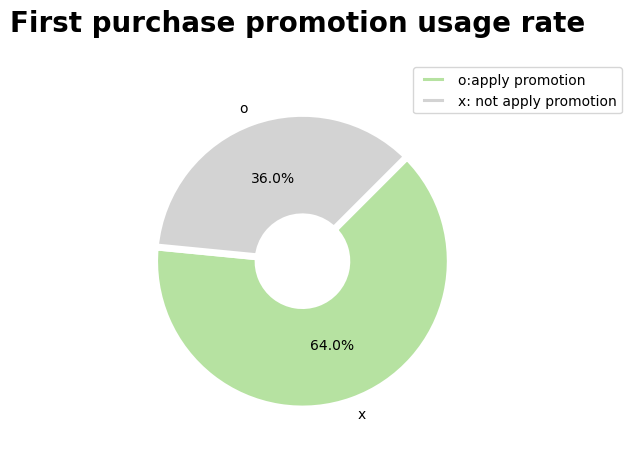

In [328]:
colors = [ '#B6E2A1','lightgrey']
wedgeprops={'width': 0.7, 'edgecolor': 'w', 'linewidth': 5}
plt.title('First purchase promotion usage rate ',fontsize=20,fontweight='bold',y=1.1)
test1.promo_yesno_first.value_counts().plot.pie(textprops={'size':10},colors=colors,wedgeprops=wedgeprops,autopct='%.1f%%',counterclock=False,startangle=45)
plt.ylabel('')
plt.legend(['o:apply promotion','x: not apply promotion'],loc=[0.8,0.9])

매월 프로모션 있지만, 월별로 있다보니까 - 프로모션 과도하게 남용하고 있어서 사람들이 그냥 구매하는 것이 아닌가 싶음 

In [329]:
df_customer.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 15 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   customer_id         100000 non-null  int64  
 1   first_name          100000 non-null  object 
 2   last_name           100000 non-null  object 
 3   username            100000 non-null  object 
 4   email               100000 non-null  object 
 5   gender              100000 non-null  object 
 6   birthdate           100000 non-null  object 
 7   device_type         100000 non-null  object 
 8   device_id           100000 non-null  object 
 9   device_version      100000 non-null  object 
 10  home_location_lat   100000 non-null  float64
 11  home_location_long  100000 non-null  float64
 12  home_location       100000 non-null  object 
 13  home_country        100000 non-null  object 
 14  first_join_date     100000 non-null  object 
dtypes: float64(2), int64(1), object(12)

In [330]:
# first_join_date 데이터 형 변환 
df_customer['first_join_date2'] = pd.to_datetime(df_customer['first_join_date']).dt.strftime('%Y-%m')

In [331]:
n=df_customer.groupby('first_join_date2')['customer_id'].count().reset_index()
n.columns=['join_data1','count1']
m=test1.groupby(['first_join_date_first2'])['customer_id'].count().reset_index()
m.columns=['join_data2','count2']
n_m = pd.concat([n,m],axis=1)
n_m['percent'] = round(n_m['count2'] / n_m['count1'] * 100,0)
n_m.head()

join_data1  count1 join_data2  count2  percent
0    2016-06       6    2016-06       1     17.0
1    2016-07     825    2016-07     141     17.0
2    2016-08     720    2016-08     185     26.0
3    2016-09     751    2016-09     188     25.0
4    2016-10     881    2016-10     248     28.0

In [332]:
n_m['count1'].sum()

100000

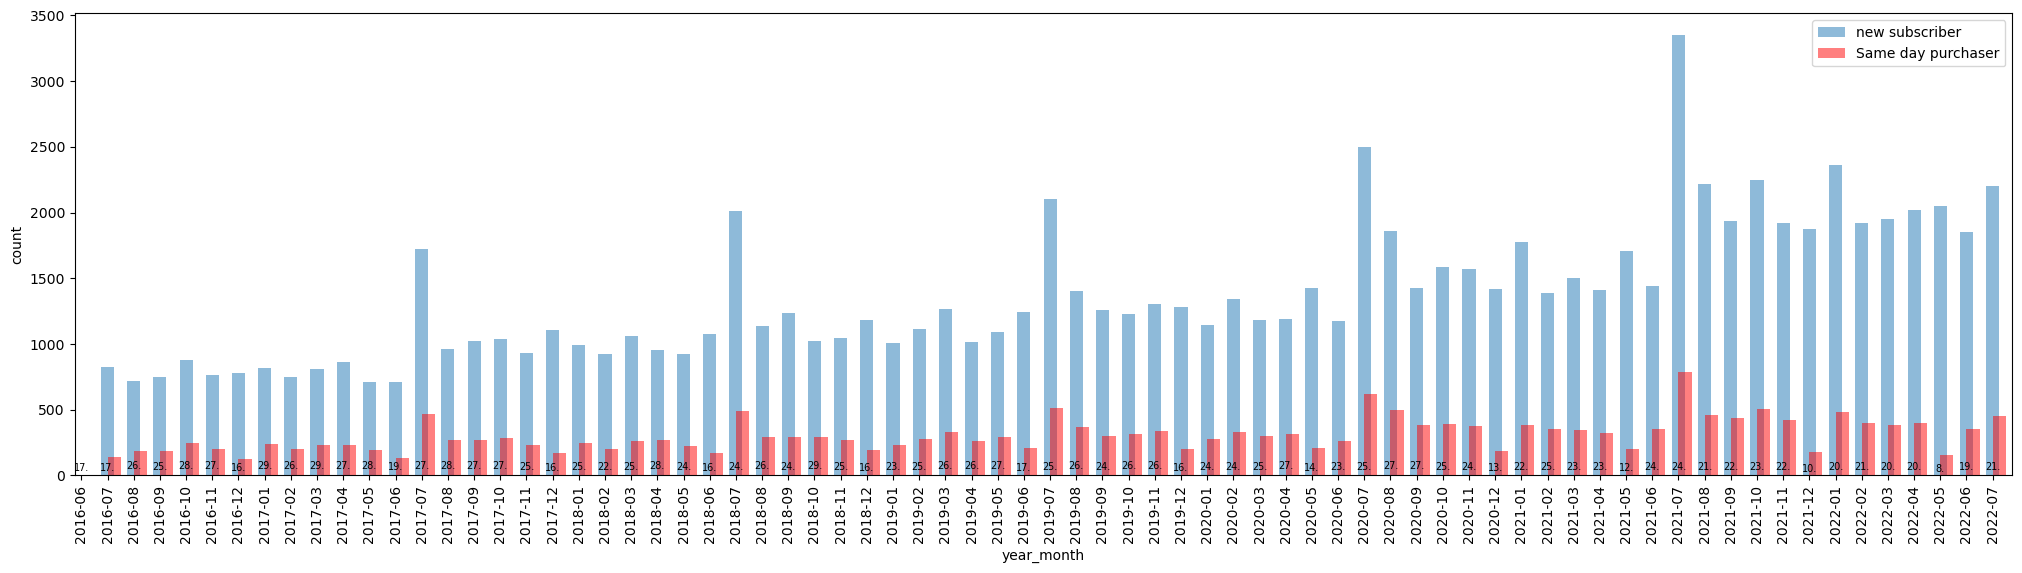

In [333]:
# 신규가입 후 당일구매한 고객
plt.figure(figsize=(25, 6))
df_customer.groupby('first_join_date2')['customer_id'].count().plot.bar(width=0.5, align='center', alpha=0.5)
test1.groupby(['first_join_date_first2'])['customer_id'].count().plot.bar(width=0.5, align='edge', alpha=0.5,color='r')

plt.legend(['new subscriber','Same day purchaser'])
plt.ylabel('count')
plt.xlabel('year_month')
for i, j in enumerate(n_m['percent']):
    plt.text(i, j + 5, f'{j:.0f}.', ha='center', va='bottom', size=7)

In [334]:
df_customer['first_join_date2']

0        2019-07
1        2017-07
2        2020-08
3        2021-10
4        2021-04
          ...   
99995    2020-10
99996    2017-11
99997    2018-09
99998    2020-05
99999    2021-07
Name: first_join_date2, Length: 100000, dtype: object

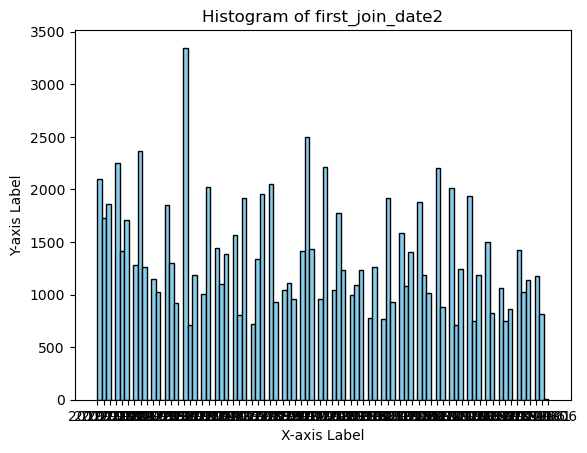

In [335]:
import matplotlib.pyplot as plt

# Assuming df_customer['first_join_date2'] is your data
plt.hist(df_customer['first_join_date2'], bins=100, color='skyblue', edgecolor='black')
plt.xlabel('X-axis Label')  # Replace 'X-axis Label' with your desired label
plt.ylabel('Y-axis Label')  # Replace 'Y-axis Label' with your desired label
plt.title('Histogram of first_join_date2')  # Replace with your desired title
plt.show()

In [336]:
for i in range(0,20):
    print(f'신규가입 {i}일차 : ',
    tranfinal_cus_1[(tranfinal_cus_1['period_enrollment_first']==i)&(tranfinal_cus_1.payment_status_first=='Success')].shape[0],
    '명, ',
    round(tranfinal_cus_1[(tranfinal_cus_1['period_enrollment_first']==i)&(tranfinal_cus_1.payment_status_first=='Success')].shape[0]/df_customer.shape[0]*100),'%')


신규가입 0일차 :  22400 명,  22 %
신규가입 1일차 :  14958 명,  15 %
신규가입 2일차 :  5384 명,  5 %
신규가입 3일차 :  2652 명,  3 %
신규가입 4일차 :  1352 명,  1 %
신규가입 5일차 :  738 명,  1 %
신규가입 6일차 :  438 명,  0 %
신규가입 7일차 :  224 명,  0 %
신규가입 8일차 :  153 명,  0 %
신규가입 9일차 :  67 명,  0 %
신규가입 10일차 :  34 명,  0 %
신규가입 11일차 :  29 명,  0 %
신규가입 12일차 :  19 명,  0 %
신규가입 13일차 :  14 명,  0 %
신규가입 14일차 :  5 명,  0 %
신규가입 15일차 :  5 명,  0 %
신규가입 16일차 :  0 명,  0 %
신규가입 17일차 :  0 명,  0 %
신규가입 18일차 :  0 명,  0 %
신규가입 19일차 :  0 명,  0 %


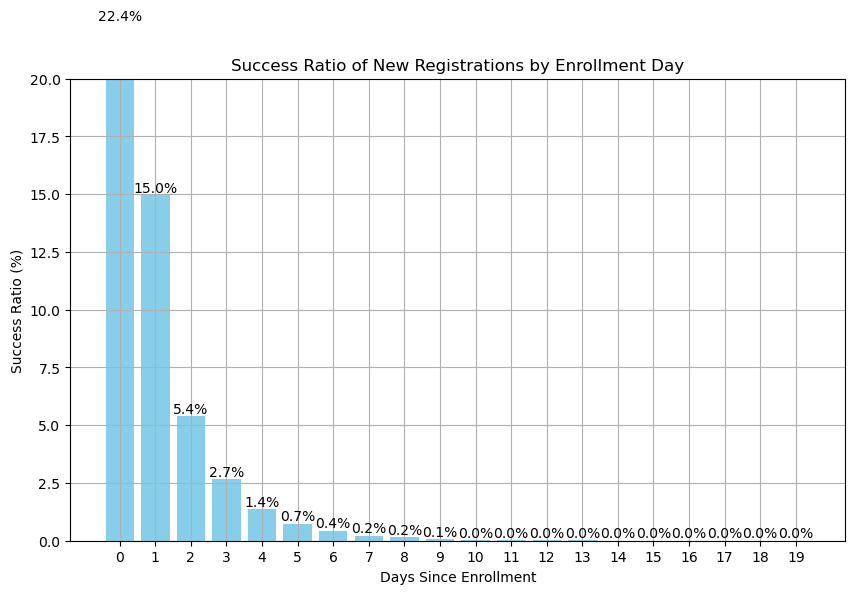

In [337]:
import matplotlib.pyplot as plt

# Assuming tranfinal_cus_1 is your DataFrame and df_customer is the total customer DataFrame

success_ratios = []
days = []

for i in range(0, 20):
    success_count = tranfinal_cus_1[
        (tranfinal_cus_1['period_enrollment_first'] == i) &
        (tranfinal_cus_1['payment_status_first'] == 'Success')
    ].shape[0]

    success_ratio = success_count / df_customer.shape[0] * 100
    success_ratios.append(success_ratio)
    days.append(i)

plt.figure(figsize=(10, 6))
bars = plt.bar(days, success_ratios, color='skyblue')  # Change color to sky blue
plt.xlabel('Days Since Enrollment')
plt.ylabel('Success Ratio (%)')
plt.title('Success Ratio of New Registrations by Enrollment Day')
plt.xticks(days)
plt.ylim(0, 20)  # Adjust y-axis limits to reduce the ratio display
plt.grid(True)

# Annotate the bars with percentage values
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval, f'{yval:.1f}%', ha='center', va='bottom', color='black')

plt.show()


In [338]:
for i in range(0,10):
    print(f'신규가입 {i}일차 : ',tranfinal_cus_1[(tranfinal_cus_1['period_enrollment_first']==i)].groupby(['promo_yesno_first'])['customer_id'].count())




신규가입 0일차 :  promo_yesno_first
o     8427
x    15010
Name: customer_id, dtype: int64
신규가입 1일차 :  promo_yesno_first
o     5629
x    10048
Name: customer_id, dtype: int64
신규가입 2일차 :  promo_yesno_first
o    1970
x    3645
Name: customer_id, dtype: int64
신규가입 3일차 :  promo_yesno_first
o    1009
x    1757
Name: customer_id, dtype: int64
신규가입 4일차 :  promo_yesno_first
o    516
x    892
Name: customer_id, dtype: int64
신규가입 5일차 :  promo_yesno_first
o    265
x    509
Name: customer_id, dtype: int64
신규가입 6일차 :  promo_yesno_first
o    161
x    290
Name: customer_id, dtype: int64
신규가입 7일차 :  promo_yesno_first
o     86
x    148
Name: customer_id, dtype: int64
신규가입 8일차 :  promo_yesno_first
o     57
x    102
Name: customer_id, dtype: int64
신규가입 9일차 :  promo_yesno_first
o    35
x    36
Name: customer_id, dtype: int64


# promotion


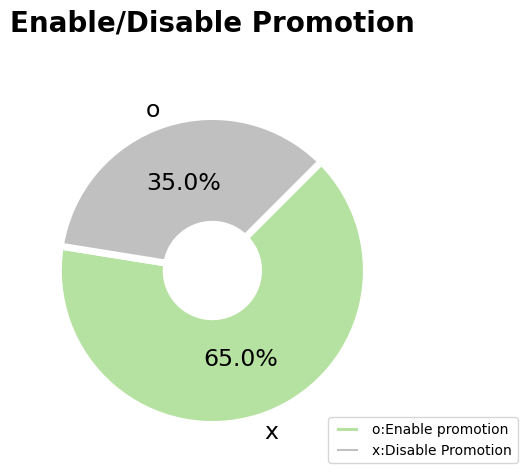

In [339]:


# 프로모션 적용여부에 따른 비율
plt.figure(figsize=(5,5),facecolor='white')
colors = ['#B6E2A1','silver']
wedgeprops={'width': 0.7, 'edgecolor': 'w', 'linewidth': 5}
tranfinal_cus.promo_yesno.value_counts(normalize=True).plot.pie(textprops={'size':17},colors=colors,wedgeprops=wedgeprops,autopct='%.1f%%',counterclock=False,startangle=45)
plt.title('Enable/Disable Promotion',fontsize=20,fontweight='bold',y=1.1)
plt.ylabel('')
plt.legend(['o:Enable promotion','x:Disable Promotion'],loc=[0.8,0]);

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_18556\3974823244.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp['promo_yes_num'] = tmp['promo_yesno'].replace({'o': 1, 'x': 0})
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_18556\3974823244.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp['promo_no_num'] = tmp['promo_yesno'].replace({'o': 0, 'x': 1})


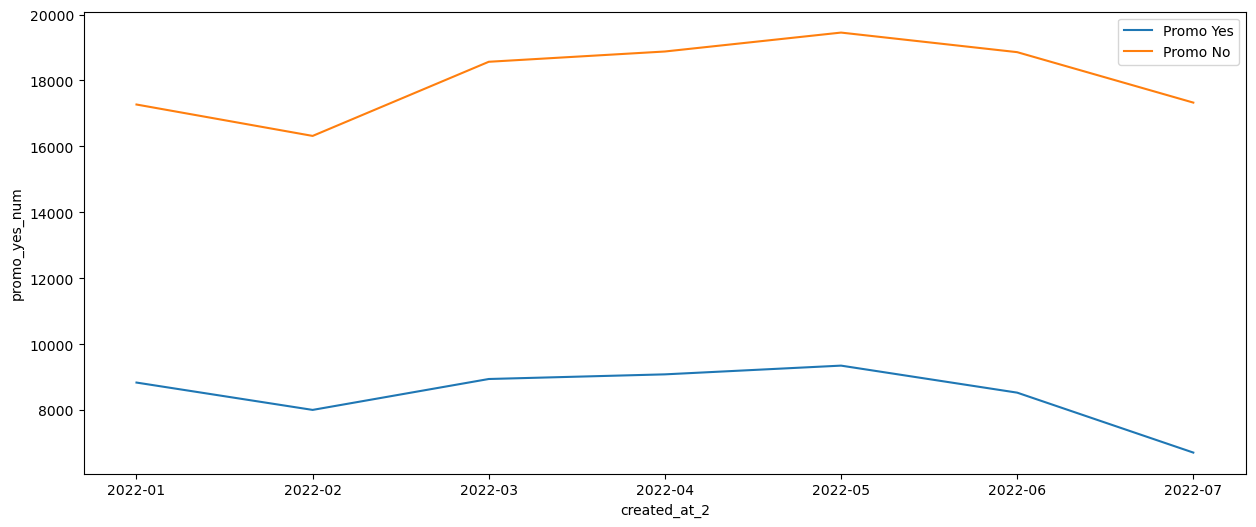

In [340]:
import matplotlib.gridspec as gridspec
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(15, 6))

# ax1 lineplot
tmp = tranfinal_cus[tranfinal_cus.payment_status=='Success']

# tmp yesno edit
tmp['promo_yes_num'] = tmp['promo_yesno'].replace({'o': 1, 'x': 0})
tmp['promo_no_num'] = tmp['promo_yesno'].replace({'o': 0, 'x': 1})

tran_success_g_yes = tmp.groupby(['created_at_2'])['promo_yes_num'].sum().reset_index()
tran_success_g_no = tmp.groupby(['created_at_2'])['promo_no_num'].sum().reset_index()

# x 축 22년도 이후값만 가져오기
tran_success_g_yes = tran_success_g_yes.iloc[17:,:]
tran_success_g_no = tran_success_g_no.iloc[17:,:]

# 2개 lineplot 그리기 with labels for the legend
sns.lineplot(data=tran_success_g_yes, x='created_at_2', y='promo_yes_num', label='Promo Yes')
sns.lineplot(data=tran_success_g_no, x='created_at_2', y='promo_no_num', label='Promo No')

plt.legend()  # This line will display the legend
plt.show()

In [341]:
# 프로모션의 주말과 평일
import datetime

# Assuming 'created_at' column is not in datetime format in tranfinal_cus
tranfinal_cus['created_at'] = pd.to_datetime(tranfinal_cus['created_at'])

tmp = tranfinal_cus.groupby(['created_at','promo_code']).size().reset_index()
tmp['date'] = tmp['created_at'].dt.date
tmp['time'] = tmp['created_at'].dt.time
tmp['week'] = tmp['created_at'].dt.strftime('%A')
tmp


created_at   promo_code  0        date      time    week
0      2020-08-02 00:01:00    LIBURDONG  1  2020-08-02  00:01:00  Sunday
1      2020-08-02 00:02:00      Nopromo  1  2020-08-02  00:02:00  Sunday
2      2020-08-02 00:04:00      Nopromo  1  2020-08-02  00:04:00  Sunday
3      2020-08-02 00:08:00      Nopromo  1  2020-08-02  00:08:00  Sunday
4      2020-08-02 00:09:00  WEEKENDSERU  2  2020-08-02  00:09:00  Sunday
...                    ...          ... ..         ...       ...     ...
469677 2022-07-31 23:56:00      Nopromo  3  2022-07-31  23:56:00  Sunday
469678 2022-07-31 23:57:00    LIBURDONG  1  2022-07-31  23:57:00  Sunday
469679 2022-07-31 23:57:00      Nopromo  3  2022-07-31  23:57:00  Sunday
469680 2022-07-31 23:58:00      Nopromo  4  2022-07-31  23:58:00  Sunday
469681 2022-07-31 23:59:00      Nopromo  2  2022-07-31  23:59:00  Sunday

[469682 rows x 6 columns]

In [342]:
tmp[tmp.promo_code!='Nopromo'].groupby(['week','promo_code']).size().reset_index()

week     promo_code      0
0      Friday         AZ2022   9269
1      Friday        BUYMORE   7044
2      Friday         SC2022   1231
3      Friday        STARTUP   1162
4      Friday         XX2022   4718
5      Monday         AZ2022  11281
6      Monday        BUYMORE   8634
7      Monday         SC2022   1455
8      Monday        STARTUP   1495
9      Monday         XX2022   5689
10   Saturday      LIBURDONG   5290
11   Saturday  WEEKENDMANTAP   5282
12   Saturday    WEEKENDSERU  15180
13     Sunday      LIBURDONG   6102
14     Sunday  WEEKENDMANTAP   5920
15     Sunday    WEEKENDSERU  17293
16   Thursday         AZ2022   9440
17   Thursday        BUYMORE   7174
18   Thursday         SC2022   1217
19   Thursday        STARTUP   1218
20   Thursday         XX2022   4846
21    Tuesday         AZ2022   9839
22    Tuesday        BUYMORE   7467
23    Tuesday         SC2022   1325
24    Tuesday        STARTUP   1292
25    Tuesday         XX2022   5083
26  Wednesday         AZ2022   9524
27  Wednesday        BUYMORE   7151
28  Wednesday         SC2022   1214
29  Wednesday        STARTUP   1206
30  Wednesday         XX2022   4978

In [343]:
tranfinal_cus['week'] = tranfinal_cus['created_at'].dt.strftime('%A')

In [344]:
tranfinal_cus[tranfinal_cus.promo_code!='Nopromo'].groupby(['week','promo_code']).size().reset_index()


week     promo_code      0
0      Friday         AZ2022   9594
1      Friday        BUYMORE   7220
2      Friday         SC2022   1235
3      Friday        STARTUP   1168
4      Friday         XX2022   4790
5      Monday         AZ2022  11752
6      Monday        BUYMORE   8901
7      Monday         SC2022   1464
8      Monday        STARTUP   1508
9      Monday         XX2022   5784
10   Saturday      LIBURDONG   5409
11   Saturday  WEEKENDMANTAP   5368
12   Saturday    WEEKENDSERU  16125
13     Sunday      LIBURDONG   6225
14     Sunday  WEEKENDMANTAP   6049
15     Sunday    WEEKENDSERU  18448
16   Thursday         AZ2022   9753
17   Thursday        BUYMORE   7363
18   Thursday         SC2022   1223
19   Thursday        STARTUP   1222
20   Thursday         XX2022   4951
21    Tuesday         AZ2022  10191
22    Tuesday        BUYMORE   7674
23    Tuesday         SC2022   1334
24    Tuesday        STARTUP   1301
25    Tuesday         XX2022   5169
26  Wednesday         AZ2022   9907
27  Wednesday        BUYMORE   7332
28  Wednesday         SC2022   1218
29  Wednesday        STARTUP   1208
30  Wednesday         XX2022   5062

In [345]:
# 프로모션별로 적용되는 상품 확인
tran_product = pd.merge(df_transaction, product, left_on='product_id',right_on='id',how='left')
tran_product.drop(columns=['id','shipment_location_lat','shipment_location_long'],axis=1,inplace=True)
tran_product['created_at'] = pd.to_datetime(tran_product['created_at'])
tran_product['date'] = (tran_product['created_at'])
tran_product['time'] = tran_product['created_at']
tran_product['week'] =  tran_product['date'].dt.strftime('%A')
tran_product[~tran_product.promo_code.isnull()]['customer_id'].unique() # 프로모션을 한번이라도 사용했던 사람들
tran_product[tran_product.promo_code.isnull()]['customer_id'].unique() # 프로모션을 사용하지않은 사람들

prom_N = set(tran_product[tran_product.promo_code.isnull()]['customer_id'].unique()) - set(tran_product[~tran_product.promo_code.isnull()]['customer_id'].unique())
len(prom_N)

0

In [346]:
tran_product.groupby(['promo_code','masterCategory']).count()['session_id'].reset_index()


promo_code  masterCategory  session_id
0          AZ2022     Accessories       33279
1          AZ2022         Apparel       63283
2          AZ2022        Footwear       27097
3          AZ2022      Free Items         306
4          AZ2022            Home           2
5          AZ2022   Personal Care        7218
6          AZ2022  Sporting Goods          73
7         BUYMORE     Accessories       24696
8         BUYMORE         Apparel       47285
9         BUYMORE        Footwear       20647
10        BUYMORE      Free Items         233
11        BUYMORE            Home           3
12        BUYMORE   Personal Care        5408
13        BUYMORE  Sporting Goods          47
14      LIBURDONG     Accessories        7800
15      LIBURDONG         Apparel       14997
16      LIBURDONG        Footwear        6488
17      LIBURDONG      Free Items          88
18      LIBURDONG   Personal Care        1680
19      LIBURDONG  Sporting Goods          14
20        Nopromo     Accessories      196029
21        Nopromo         Apparel      372830
22        Nopromo        Footwear      160202
23        Nopromo      Free Items        1871
24        Nopromo            Home          12
25        Nopromo   Personal Care       41683
26        Nopromo  Sporting Goods         431
27         SC2022     Accessories        4284
28         SC2022         Apparel        8020
29         SC2022        Footwear        3416
30         SC2022      Free Items          31
31         SC2022   Personal Care         884
32         SC2022  Sporting Goods           9
33        STARTUP     Accessories        4188
34        STARTUP         Apparel        7899
35        STARTUP        Footwear        3377
36        STARTUP      Free Items          28
37        STARTUP   Personal Care         909
38        STARTUP  Sporting Goods           9
39  WEEKENDMANTAP     Accessories        7684
40  WEEKENDMANTAP         Apparel       14286
41  WEEKENDMANTAP        Footwear        6319
42  WEEKENDMANTAP      Free Items          81
43  WEEKENDMANTAP   Personal Care        1618
44  WEEKENDMANTAP  Sporting Goods          11
45    WEEKENDSERU     Accessories       22937
46    WEEKENDSERU         Apparel       44048
47    WEEKENDSERU        Footwear       19203
48    WEEKENDSERU      Free Items         194
49    WEEKENDSERU            Home           1
50    WEEKENDSERU   Personal Care        5009
51    WEEKENDSERU  Sporting Goods          50
52         XX2022     Accessories       16795
53         XX2022         Apparel       31568
54         XX2022        Footwear       13639
55         XX2022      Free Items         155
56         XX2022            Home           1
57         XX2022   Personal Care        3579
58         XX2022  Sporting Goods          32

In [351]:
# 월별 매출 확인 / x축은 배송받은 날짜 / y축 success 기준 매출 (total amount)
# 사용 컬럼 : payment_status, created_at_new2(shipment_date_limit - shipment_date 한 주문날짜), total_amount 

df_revenue_per_month = df_transaction[['payment_status', 'created_at_new2', 'total_amount']]
df_revenue_per_month

payment_status     created_at_new2  total_amount
0              Success 2018-07-29 15:22:00        199832
1              Success 2018-07-30 12:40:00        155526
2              Success 2018-09-15 11:51:00        550696
3              Success 2018-11-01 11:23:00        271012
4              Success 2018-12-18 11:20:00        198753
...                ...                 ...           ...
1254580         Failed 2021-09-21 22:10:00        226820
1254581        Success 2021-12-09 07:35:00        359203
1254582        Success 2021-12-11 01:20:00       1158159
1254583        Success 2019-12-18 11:01:00        184143
1254584        Success 2019-12-19 12:47:00        365963

[1254585 rows x 3 columns]

In [352]:
df_revenue_per_month=df_revenue_per_month[df_revenue_per_month['payment_status']=='Success']
# df에 success만 저장

In [353]:
# 2022년 월별 매출 1~ 7월 뽑아내기 


df_revenue_per_month['created_at_new2'] = pd.to_datetime(df_revenue_per_month['created_at_new2'])  # Convert to datetime

# Extract year, month, and day into separate columns
df_revenue_per_month['year'] = df_revenue_per_month['created_at_new2'].dt.year
df_revenue_per_month['month'] = df_revenue_per_month['created_at_new2'].dt.month
df_revenue_per_month['day'] = df_revenue_per_month['created_at_new2'].dt.day

df_revenue_per_month

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_18556\2149532059.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_revenue_per_month['created_at_new2'] = pd.to_datetime(df_revenue_per_month['created_at_new2'])  # Convert to datetime
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_18556\2149532059.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_revenue_per_month['year'] = df_revenue_per_month['created_at_new2'].dt.year
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_18556\

payment_status     created_at_new2  total_amount  year  month  day
0              Success 2018-07-29 15:22:00        199832  2018      7   29
1              Success 2018-07-30 12:40:00        155526  2018      7   30
2              Success 2018-09-15 11:51:00        550696  2018      9   15
3              Success 2018-11-01 11:23:00        271012  2018     11    1
4              Success 2018-12-18 11:20:00        198753  2018     12   18
...                ...                 ...           ...   ...    ...  ...
1254579        Success 2020-11-12 18:19:00        287688  2020     11   12
1254581        Success 2021-12-09 07:35:00        359203  2021     12    9
1254582        Success 2021-12-11 01:20:00       1158159  2021     12   11
1254583        Success 2019-12-18 11:01:00        184143  2019     12   18
1254584        Success 2019-12-19 12:47:00        365963  2019     12   19

[1201035 rows x 6 columns]

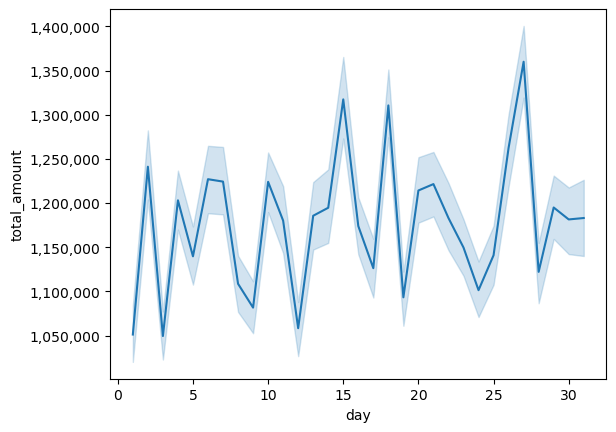

In [354]:
# 2022 
df_revenue_per_month_2022=df_revenue_per_month[df_revenue_per_month['year']==2022]
df_revenue_per_month_2022[df_revenue_per_month_2022['month']== 7] #7월만 확인 



ax = sns.lineplot(data=df_revenue_per_month_2022, x='day', y='total_amount')

ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:,.0f}'))  # Format as integers with commas

plt.show()



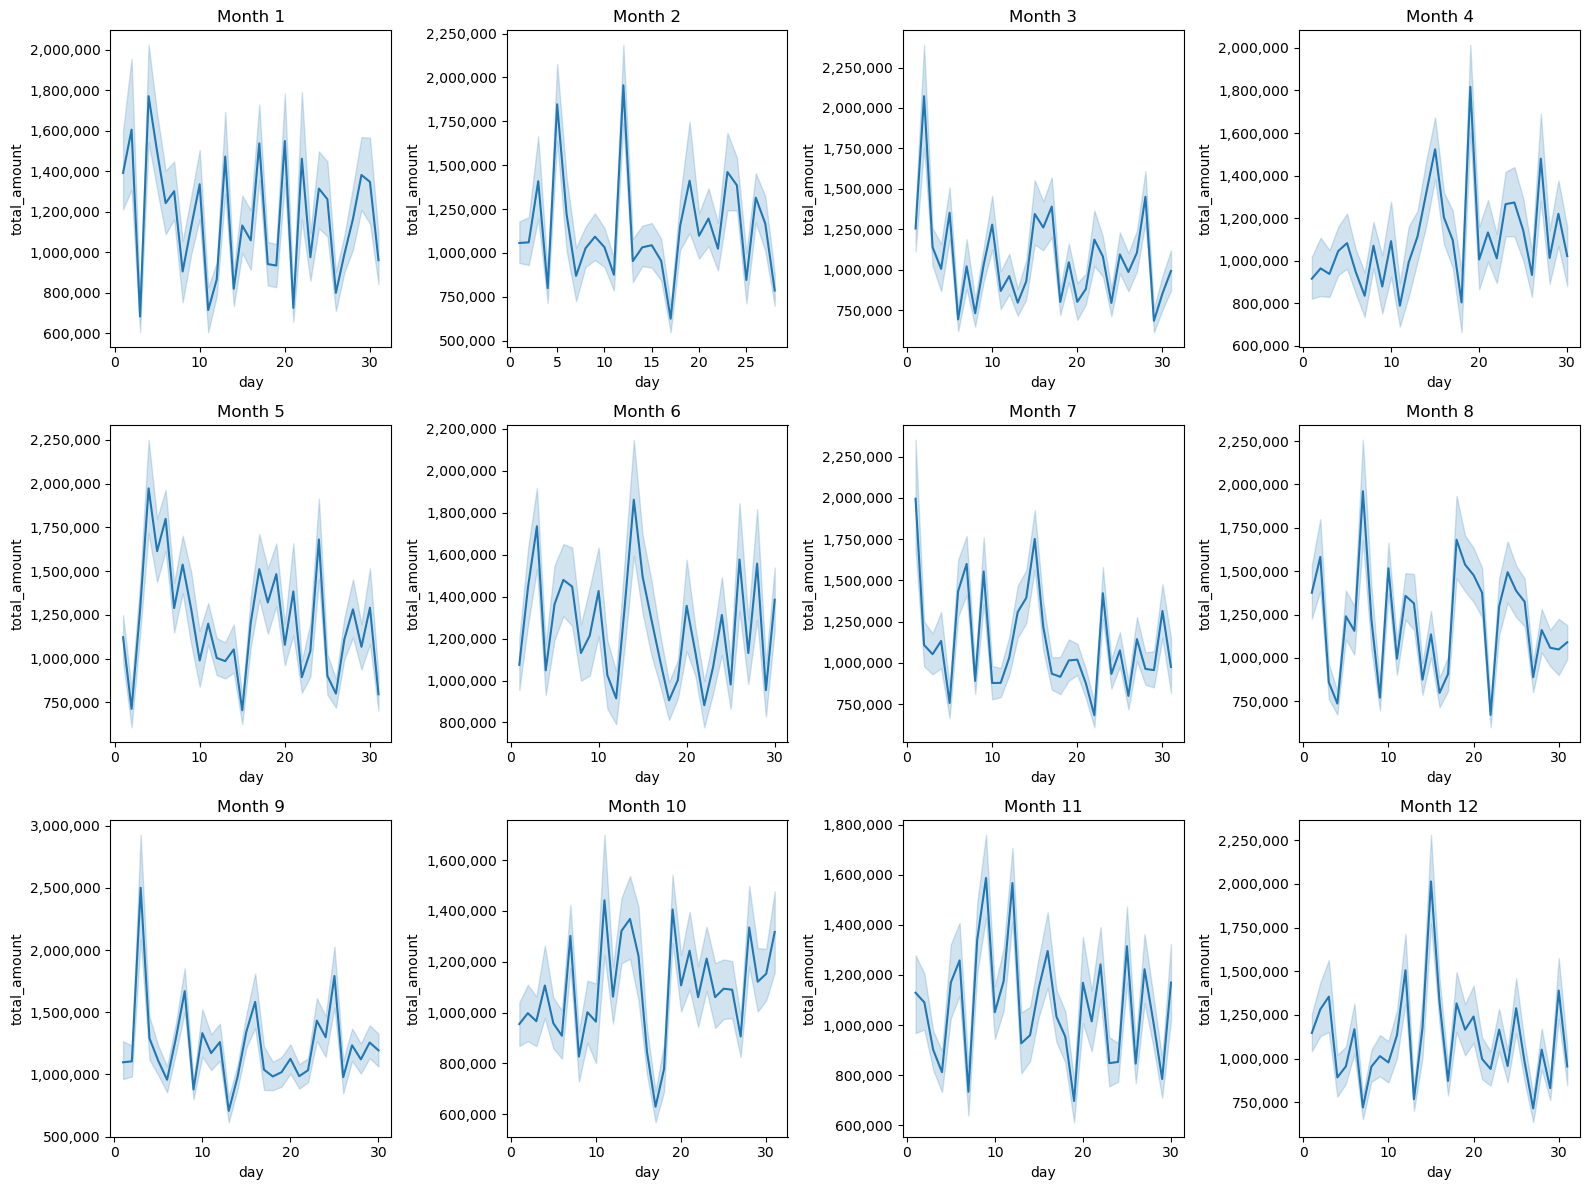

In [355]:
# 2019

import seaborn as sns
import matplotlib.pyplot as plt

# Filter the data for the year 2022
df_revenue_per_month_2019 = df_revenue_per_month[df_revenue_per_month['year'] == 2019]

# Create a subplot with 3 rows and 4 columns
fig, axes = plt.subplots(3, 4, figsize=(16, 12))  # Adjust figsize as needed

# Iterate through the months and plot each one
for month in range(1, 13):  # Loop from January (1) to December (12)
    row = (month - 1) // 4  # Calculate the row index (0-2)
    col = (month - 1) % 4   # Calculate the column index (0-3)

    # Filter data for the specific month
    df_month = df_revenue_per_month_2019[df_revenue_per_month_2019['month'] == month]

    # Create a line plot for the month on the specified subplot
    ax = sns.lineplot(data=df_month, x='day', y='total_amount', ax=axes[row, col])

    # Format the y-axis
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:,.0f}'))

    # Set titles for each subplot
    ax.set_title(f'Month {month}')

# Adjust the layout
plt.tight_layout()

# Show the subplots
plt.show()


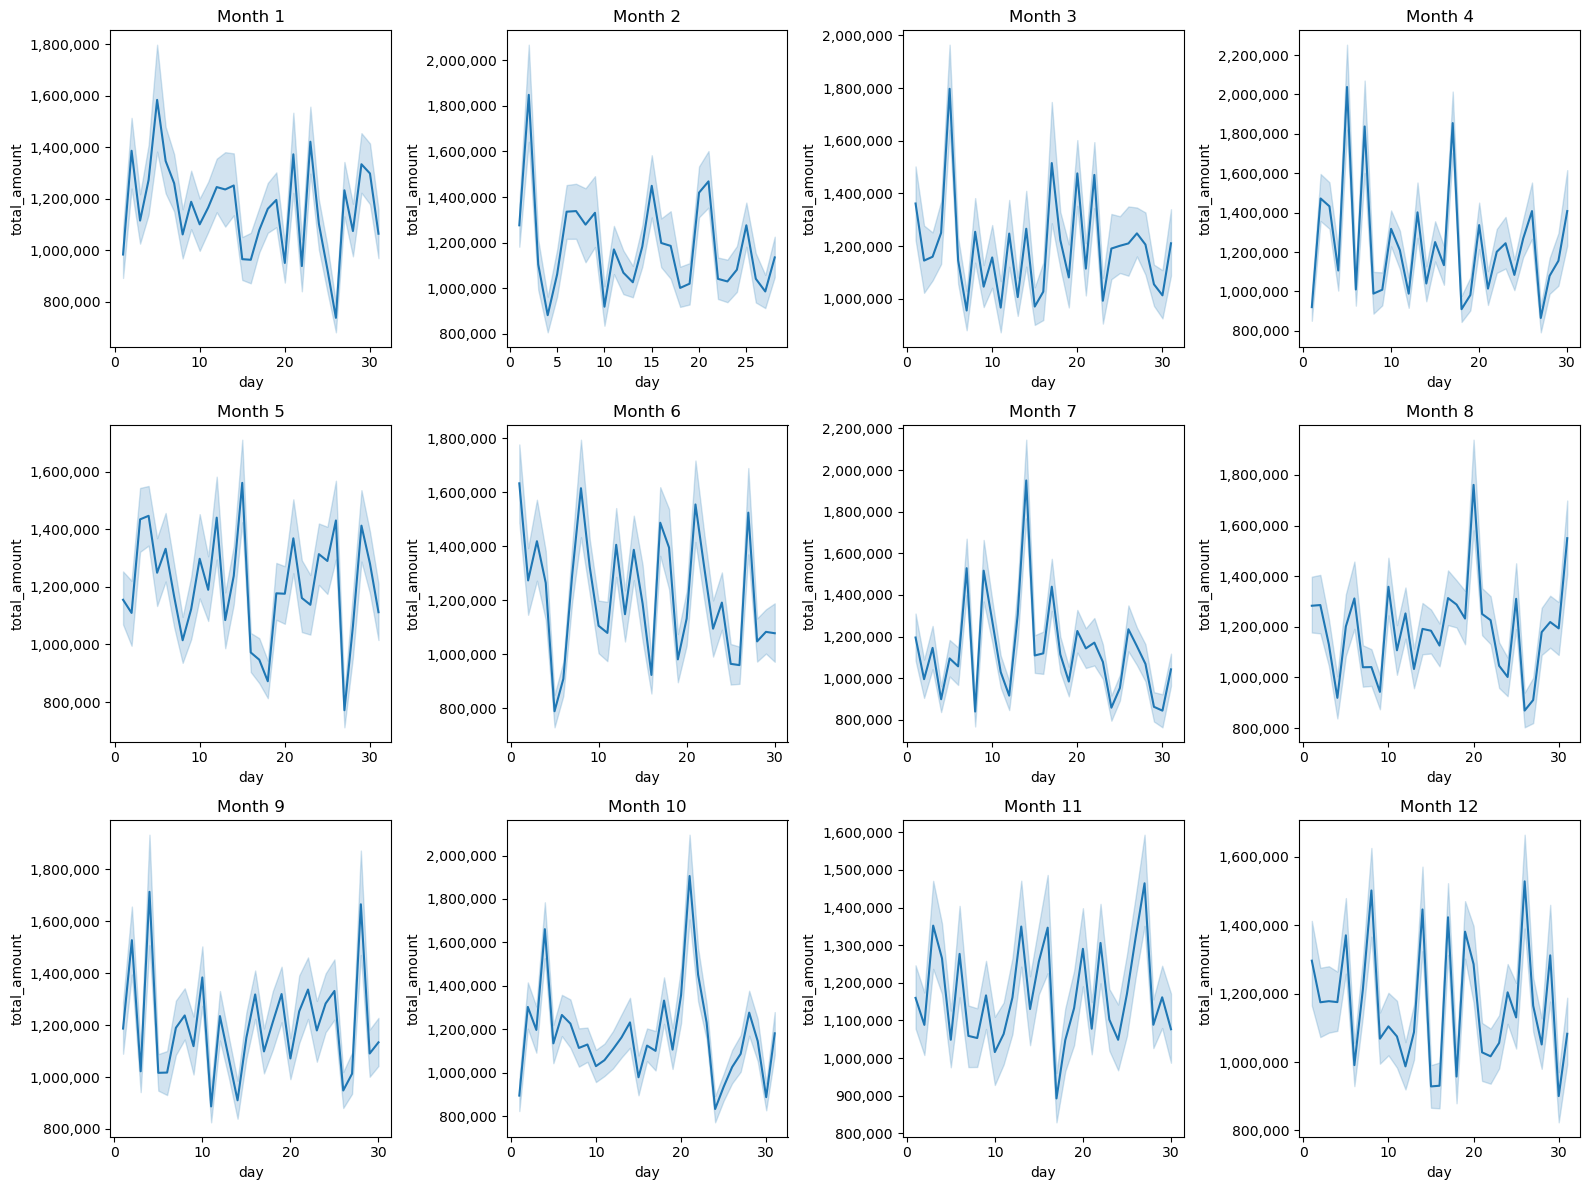

In [356]:

# Filter the data for the year 2022
df_revenue_per_month_2021 = df_revenue_per_month[df_revenue_per_month['year'] == 2021]

# Create a subplot with 3 rows and 4 columns
fig, axes = plt.subplots(3, 4, figsize=(16, 12))  # Adjust figsize as needed

# Iterate through the months and plot each one
for month in range(1, 13):  # Loop from January (1) to December (12)
    row = (month - 1) // 4  # Calculate the row index (0-2)
    col = (month - 1) % 4   # Calculate the column index (0-3)

    # Filter data for the specific month
    df_month = df_revenue_per_month_2021[df_revenue_per_month_2021['month'] == month]

    # Create a line plot for the month on the specified subplot
    ax = sns.lineplot(data=df_month, x='day', y='total_amount', ax=axes[row, col])

    # Format the y-axis
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:,.0f}'))

    # Set titles for each subplot
    ax.set_title(f'Month {month}')

# Adjust the layout
plt.tight_layout()

# Show the subplots
plt.show()


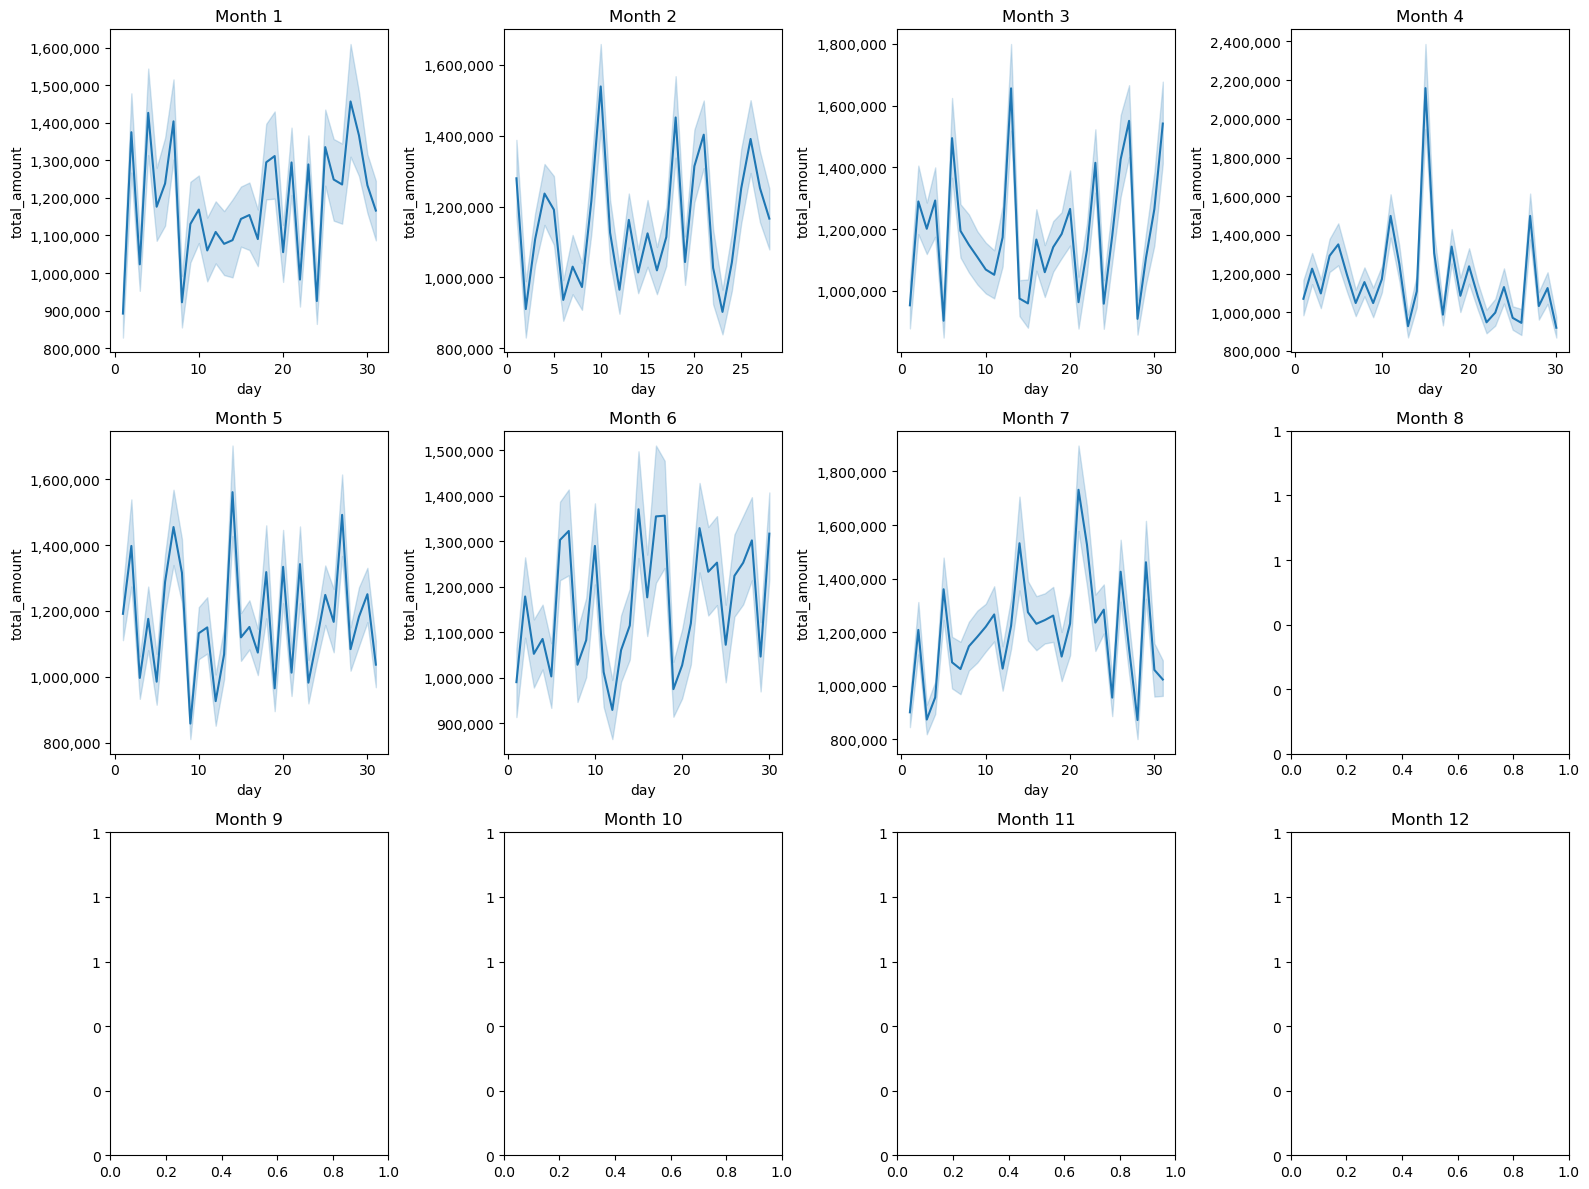

In [357]:
# 2022

import seaborn as sns
import matplotlib.pyplot as plt

# Filter the data for the year 2022
df_revenue_per_month_2022 = df_revenue_per_month[df_revenue_per_month['year'] == 2022]

# Create a subplot with 3 rows and 4 columns
fig, axes = plt.subplots(3, 4, figsize=(16, 12))  # Adjust figsize as needed

# Iterate through the months and plot each one
for month in range(1, 13):  # Loop from January (1) to December (12)
    row = (month - 1) // 4  # Calculate the row index (0-2)
    col = (month - 1) % 4   # Calculate the column index (0-3)

    # Filter data for the specific month
    df_month = df_revenue_per_month_2022[df_revenue_per_month_2022['month'] == month]

    # Create a line plot for the month on the specified subplot
    ax = sns.lineplot(data=df_month, x='day', y='total_amount', ax=axes[row, col])

    # Format the y-axis
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:,.0f}'))

    # Set titles for each subplot
    ax.set_title(f'Month {month}')

# Adjust the layout
plt.tight_layout()

# Show the subplots
plt.show()


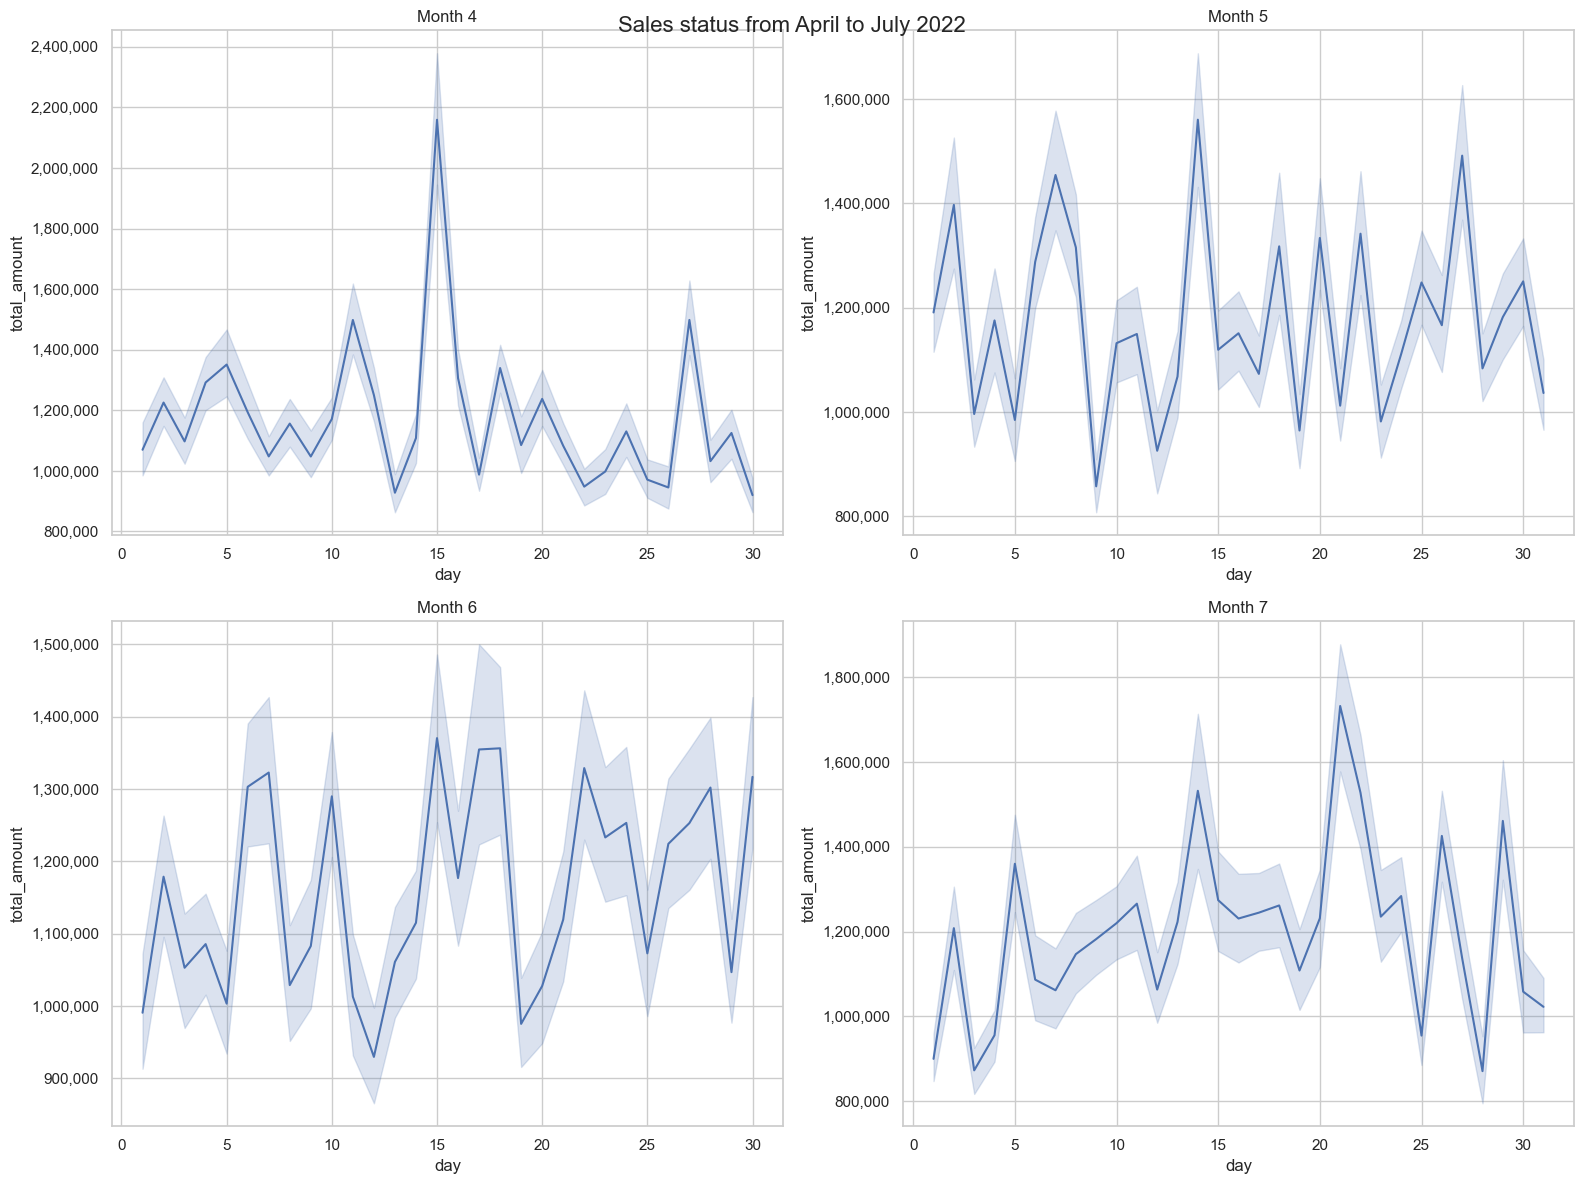

In [392]:
# 2022 4~ 7월 매출 


import seaborn as sns
import matplotlib.pyplot as plt


df_revenue_per_month_2022 = df_revenue_per_month[df_revenue_per_month['year'] == 2022]


df_revenue_per_month_4_to_7 = df_revenue_per_month_2022[(df_revenue_per_month_2022['month'] >= 4) & (df_revenue_per_month_2022['month'] <= 7)]

fig, axes = plt.subplots(2, 2, figsize=(16, 12))  # Adjust figsize as needed


for month, ax in zip(range(4, 8), axes.ravel()):
    
    df_month = df_revenue_per_month_4_to_7[df_revenue_per_month_4_to_7['month'] == month]

    
    sns.lineplot(data=df_month, x='day', y='total_amount', ax=ax)

    # Format the y-axis
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:,.0f}'))

    # Set titles for each subplot
    ax.set_title(f'Month {month}')


plt.tight_layout()

plt.suptitle('Sales status from April to July 2022', fontsize=16)
plt.show()


In [359]:
counts =  df_revenue_per_month_2022['payment_status'].value_counts()
counts

Success    273323
Name: payment_status, dtype: int64

In [360]:
df_revenue_per_month_2022

payment_status     created_at_new2  total_amount  year  month  day
40             Success 2022-01-19 11:25:00       1078709  2022      1   19
41             Success 2022-03-07 10:53:00        311231  2022      3    7
42             Success 2022-04-23 11:43:00        117133  2022      4   23
43             Success 2022-06-09 12:18:00        245215  2022      6    9
183            Success 2022-01-09 18:44:00        369557  2022      1    9
...                ...                 ...           ...   ...    ...  ...
1254563        Success 2022-01-10 13:51:00        196191  2022      1   10
1254572        Success 2022-04-15 01:10:00        246186  2022      4   15
1254573        Success 2022-05-09 19:43:00        387326  2022      5    9
1254574        Success 2022-06-08 02:44:00        237077  2022      6    8
1254575        Success 2022-07-07 09:48:00        485334  2022      7    7

[273323 rows x 6 columns]

In [361]:

df_revenue_per_month_2022['counts'] = 1
df_revenue_per_month_2022

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_18556\4180115989.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_revenue_per_month_2022['counts'] = 1


payment_status     created_at_new2  total_amount  year  month  day  \
40             Success 2022-01-19 11:25:00       1078709  2022      1   19   
41             Success 2022-03-07 10:53:00        311231  2022      3    7   
42             Success 2022-04-23 11:43:00        117133  2022      4   23   
43             Success 2022-06-09 12:18:00        245215  2022      6    9   
183            Success 2022-01-09 18:44:00        369557  2022      1    9   
...                ...                 ...           ...   ...    ...  ...   
1254563        Success 2022-01-10 13:51:00        196191  2022      1   10   
1254572        Success 2022-04-15 01:10:00        246186  2022      4   15   
1254573        Success 2022-05-09 19:43:00        387326  2022      5    9   
1254574        Success 2022-06-08 02:44:00        237077  2022      6    8   
1254575        Success 2022-07-07 09:48:00        485334  2022      7    7   

         counts  
40            1  
41            1  
42            1  
43            1  
183           1  
...         ...  
1254563       1  
1254572       1  
1254573       1  
1254574       1  
1254575       1  

[273323 rows x 7 columns]

In [362]:
df_revenue_per_month_2022['counts']

40         1
41         1
42         1
43         1
183        1
          ..
1254563    1
1254572    1
1254573    1
1254574    1
1254575    1
Name: counts, Length: 273323, dtype: int64

In [380]:
order_counts = df_revenue_per_month_2022.groupby(['month', 'day'])['counts'].sum().tolist()
order_counts

[1125,
 1364,
 1342,
 1222,
 1104,
 1058,
 1187,
 1157,
 1240,
 1325,
 1120,
 1120,
 1045,
 1020,
 1320,
 1385,
 1372,
 1201,
 1229,
 1123,
 1107,
 1218,
 1571,
 1308,
 1258,
 1158,
 1086,
 1133,
 1252,
 1591,
 1447,
 1320,
 1027,
 1199,
 1221,
 1277,
 1446,
 1299,
 1181,
 1141,
 1213,
 1037,
 1309,
 1435,
 1424,
 1106,
 1176,
 1207,
 1259,
 1241,
 1502,
 1553,
 1107,
 1139,
 1226,
 1137,
 1355,
 1443,
 1488,
 1163,
 1188,
 1265,
 1103,
 1269,
 1546,
 1331,
 1242,
 1158,
 1209,
 1126,
 1307,
 1673,
 1432,
 1193,
 1162,
 1217,
 1247,
 1304,
 1553,
 1345,
 1358,
 1288,
 1222,
 1170,
 1353,
 1612,
 1491,
 1276,
 1252,
 1312,
 1242,
 1395,
 1479,
 1521,
 1386,
 1243,
 1298,
 1250,
 1341,
 1663,
 1523,
 1325,
 1352,
 1190,
 1366,
 1365,
 1617,
 1625,
 1340,
 1334,
 1282,
 1242,
 1363,
 1515,
 1521,
 1264,
 1342,
 1273,
 1290,
 1399,
 1567,
 1572,
 1300,
 1246,
 1175,
 1286,
 1502,
 1580,
 1438,
 1271,
 1370,
 1171,
 1202,
 1382,
 1545,
 1539,
 1292,
 1201,
 1248,
 1308,
 1269,
 1514,
 1450,

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_18556\1732091514.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_revenue_per_month_4_to_7['counts'] = 1


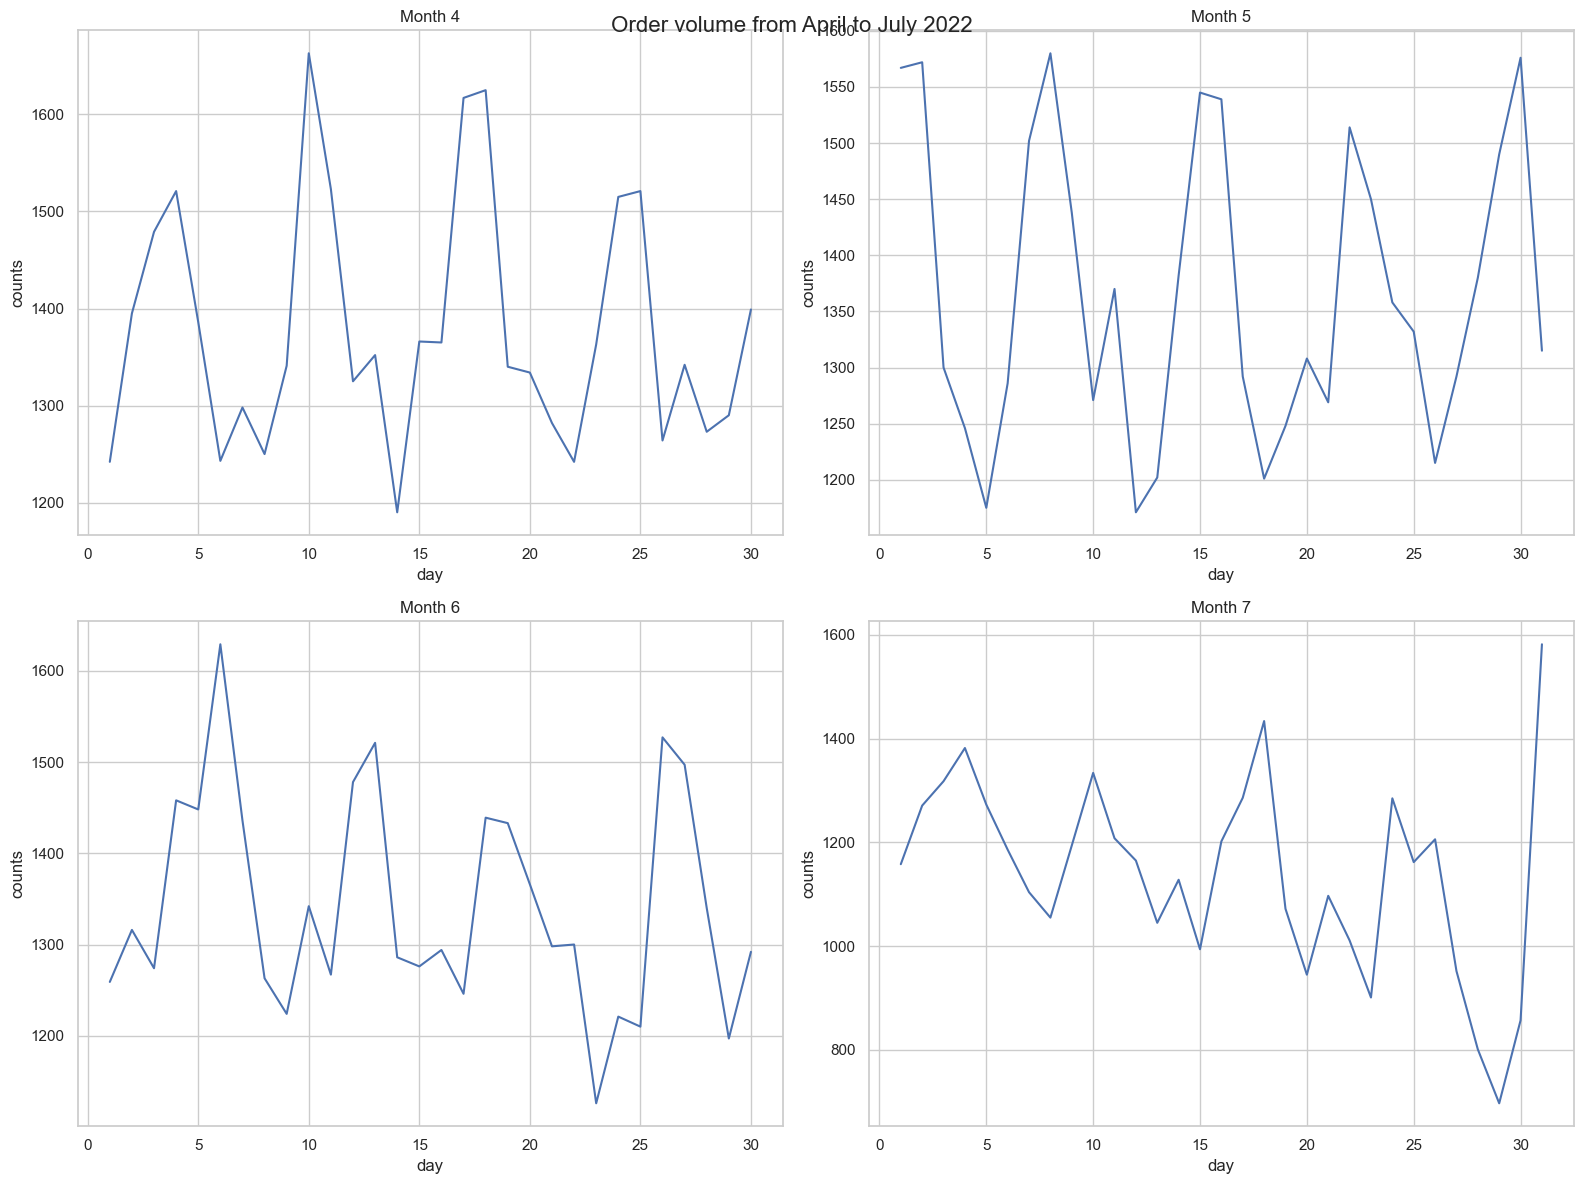

In [394]:
# 2022 4~ 7월 주문량

import seaborn as sns
import matplotlib.pyplot as plt


fig, axes = plt.subplots(2, 2, figsize=(16, 12))  # Adjust figsize as needed
df_revenue_per_month_4_to_7['counts'] = 1
for month, ax in zip(range(4, 8), axes.ravel()):
    # Filter the data for the specific month
    df_month = df_revenue_per_month_4_to_7[df_revenue_per_month_4_to_7['month'] == month]

    # Calculate order counts for each day in the month
    sum_counts_by_day = df_month.groupby('day')['counts'].sum().reset_index()

    # Create a line plot for the current month
    sns.lineplot(data=sum_counts_by_day, x='day', y='counts', ax=ax)

    # Set titles for each subplot
    ax.set_title(f'Month {month}')

plt.tight_layout()

plt.suptitle('Order volume from April to July 2022', fontsize=16)
plt.show()
